# Introduction
This project will involve forecasting time series data related to median real estate prices in various zipcodes in order to answer the client's question: "What are the top 5 zipcodes for us to invest in?" This question is a bit vague, and will require some domain knowledge to answer. To approach this project, a CRISP-DM workflow will be followed.<br>
<br>
#### Outline:
[Business Understanding](#business_understanding)<br>
[Data Understanding](#data_understanding)<br>
[Data Preparation](#data_preparation)<br>

<a id='business_understanding'></a>
# Business Understanding:
A couple things to immediately note about the question at hand:
<ol>
    <li>
        Whether the client is looking at investment in residential/commercial real estate (or both) is not established. Taking a look at the <a href='https://www.zillow.com/research/data/'>Zillow Research Page</a>, from which the data is sourced, reveals that the prices are in reference to residential properties. This is valuable to know, as it narrows the scope of consideration for market forces that might be in effect at any given time, and removes possibility of inconsistences of market type among the zipcodes.</li>
    <li>        
The time horizon for these investments is not defined. Shorter-term investments that could bring faster returns typically have more risk involved due to price volatility. Less volatile markets with stable growth are typically good targets for longer term investment. Diversification is generally accepted to be a good strategy in any investment portfolio, so it may be wise to consider some split between these two strategies. With real estate, one could assume that the holding period of the assets would be longer than, say, with stock investment, since real estate is less liquid. This might mean that a short holding period may be more like a year, and a longer holding period around 5 or even 10 years. More exposure to the data will reveal some strategic insights. It is also important to note that long-term real-estate investments can be leased in the short-term. Although it is not established whether the client is a landlord or property management company, these services can be provided by third parties, so for any type of investor holding real estate for years at a time, this is a good profit strategy. In all, logic would suggest that the strategy should be investing in properties which have strong expected growth over a time horizon, and leasing the property during that time horizon.</li></ol>
<br>
 Although the <a href='https://www.investopedia.com/articles/basics/04/022004.asp'>Efficient Market Hypothesis</a>, which states that market prices reflect all current available knowledge affecting the investment, has been shown to be demonstrably false (as indicated by the level of diversity in the returns of individual investors in markets), it is not completely without merit or unworthy of consideration. Especially when dealing with median prices for real estate in a region, such as this dataset, one can expect that a fair deal of knowledge about the future expectations for the real estate of that region is already factored into the averaged market price seen. Further, depending on the number of zipcodes in the dataset, doing individualized research to understand fundamental developments occuring in each may be unfeasible. However, if the list is narrowed down to a few, further investigation may be appropriate.<br>
 <br>
 Since models will have a range of values within the confidence interval, the low side may or may not be higher than the initial investment, a good way to narrow down the pool of zipcodes to consider might involve using the lower end of the confidence interval at a projection period of 5 years out, and seeing if it is higher than the initial investment, therefore showing good confidence that in a worst case scenario, the investor would not be likely to LOSE any money on the investment. Also, any losses may be offset by leasing the properties over the course of the investment period.<br>
 <br>
 Another filtering method that may be employed would be to find the average monthly return of each zipcode, and focus on those zipcodes which consistently outperformed in repeated sampling of random time windows. Since the data spans across the Great Recession, this would also indicate which zipcodes had real estate which was more resilient to the crisis, further justifying investor confidence.

<a id='data_understanding'></a>
# Data Understanding:
- The data to be used for this project has been made available in a .csv file 'zillow_data.csv' contained in this repository. The data is in Wide Format, meaning that the dates for the time series are the headers of columns. This means that the data will have to be melted using pandas in order to get it into Long Format, which will be necessary for modeling the time series.
- Further data about the zip codes may later be obtained from the internet, depending on the project's needs, after the list of potential investments has been considerably narrowed down.

In [7]:
# Importing the necessary libraries
import matplotlib.pyplot as plt
import my_functions as mf
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.stattools as st
from operator import itemgetter

In [8]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Plot styling
plt.style.use('ggplot')
from jupyterthemes import jtplot
jtplot.style()

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 7

## Loading DataFrame and Initial Feature Inspection

In [11]:
# Getting a look at the raw data
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

A question to answer immediately is whether the RegionID or RegionName represents the zip code of a region. A few quick google searches reveal that the RegionName column contains the zip codes.

In [12]:
# Getting the number of rows and columns
df.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [13]:
# We can see that there are a lot of rows, 14723, in the dataset.
# Checking to see if there is the same number of unique zip codes (RegionName)
df.RegionName.nunique()

14723

In [14]:
# We see that there are 14723 unique zip codes in the database. For clarity, I will rename
# the RegionName column to 'zipcode':
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
df.head(15)

RegionID  zipcode           City State              Metro     CountyName  \
0      84654    60657        Chicago    IL            Chicago           Cook   
1      90668    75070       McKinney    TX  Dallas-Fort Worth         Collin   
2      91982    77494           Katy    TX            Houston         Harris   
3      84616    60614        Chicago    IL            Chicago           Cook   
4      93144    79936        El Paso    TX            El Paso        El Paso   
5      91733    77084        Houston    TX            Houston         Harris   
6      61807    10467       New York    NY           New York          Bronx   
7      84640    60640        Chicago    IL            Chicago           Cook   
8      91940    77449           Katy    TX            Houston         Harris   
9      97564    94109  San Francisco    CA      San Francisco  San Francisco   
10     62037    11226       New York    NY           New York          Kings   
11     71831    32162   The Villages    FL       The Villages         Sumter   
12     62087    11375       New York    NY           New York         Queens   
13     62045    11235       New York    NY           New York          Kings   
14     74101    37013      Nashville    TN          Nashville       Davidson   

    SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0          1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1          2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2          3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3          4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4          5   77300.0   77300.0   77300.0  ...   119100   119400   120000   
5          6   95000.0   95200.0   95400.0  ...   157900   158700   160200   
6          7  152900.0  152700.0  152600.0  ...   394400   400000   407300   
7          8  216500.0  216700.0  216900.0  ...   798000   787100   776100   
8          9   95400.0   95600.0   95800.0  ...   166800   167400   168400   
9         10  766000.0  771100.0  776500.0  ...  3767700  3763900  3775000   
10        11  162000.0  162300.0  162600.0  ...   860200   851000   853900   
11        12  101000.0  100700.0  100400.0  ...   249900   250400   249900   
12        13  252400.0  251800.0  251400.0  ...  1022600  1033700  1048600   
13        14  190500.0  191000.0  191500.0  ...   767300   777300   788800   
14        15  112400.0  112700.0  113000.0  ...   193000   194900   196600   

    2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1    314100   315000   316600   318100   319600   321100   321800  
2    320400   320800   321200   321200   323000   326900   329900  
3   1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4    120300   120300   120300   120300   120500   121000   121500  
5    161900   162800   162800   162800   162900   163500   164300  
6    411600   413200   414300   413900   411400   413200   417900  
7    774900   777900   777900   778500   780500   782800   782800  
8    169600   170900   172300   173300   174200   175400   176200  
9   3799700  3793900  3778700  3770800  3763100  3779800  3813500  
10   870000   885100   887800   890500   901700   930700   963200  
11   248700   247500   247100   246800   247500   249800   251800  
12  1066400  1081200  1088800  1092700  1089500  1084000  1084600  
13   793900   796000   799700   806600   810600   813400   816200  
14   198800   201300   203800   205900   207600   210000   211900  

[15 rows x 272 columns]

In [15]:
# It appears the SizeRank column is in ascending order, no description of this column is given
df.SizeRank

0            1
1            2
2            3
3            4
4            5
         ...  
14718    14719
14719    14720
14720    14721
14721    14722
14722    14723
Name: SizeRank, Length: 14723, dtype: int64

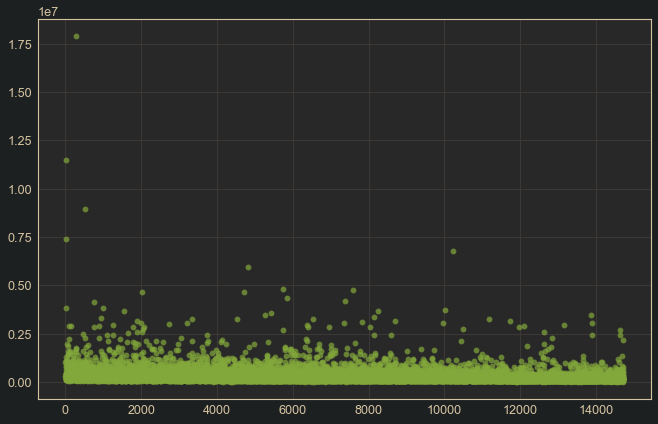

In [16]:
# Does SizeRank have any correlation to most recent prices?
plt.figure(figsize=(11,7))
plt.scatter(df.SizeRank, df['2018-04'], alpha=0.7);

In [17]:
# Althought the largest outliers in most recent prices fall in the earlier size ranks,
# there does not appear to be any significant correlation beyond that. This feature is probably
# not valuable.

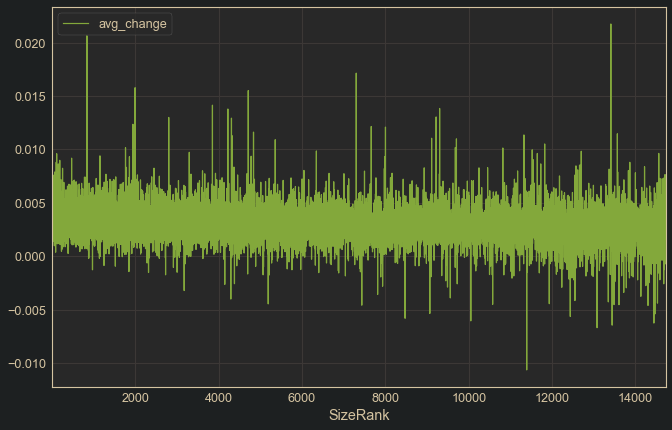

In [18]:
# I would like to see another relationship, that between SizeRank and the average monthly change
# of a zipcode over the whole time period
pct_change = df.set_index('SizeRank').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName', 
                                                   'RegionID',
                                                   'zipcode',]).T.pct_change()
avg_change = pd.DataFrame(pct_change.mean(), columns=['avg_change'])
avg_change.plot()

In [19]:
avg_change.head()

avg_change
SizeRank            
1           0.004295
2           0.001215
3           0.001757
4           0.003682
5           0.001728

In [20]:
# Adding SizeRank back as a column for compatibility with functions
avg_change = avg_change.reset_index()
avg_change.head()

SizeRank  avg_change
0         1    0.004295
1         2    0.001215
2         3    0.001757
3         4    0.003682
4         5    0.001728

In [21]:
# A look at the pearson correlation score for the two columns
avg_change.corr()

SizeRank  avg_change
SizeRank    1.000000   -0.124774
avg_change -0.124774    1.000000

Linear Regression for avg_change~SizeRank


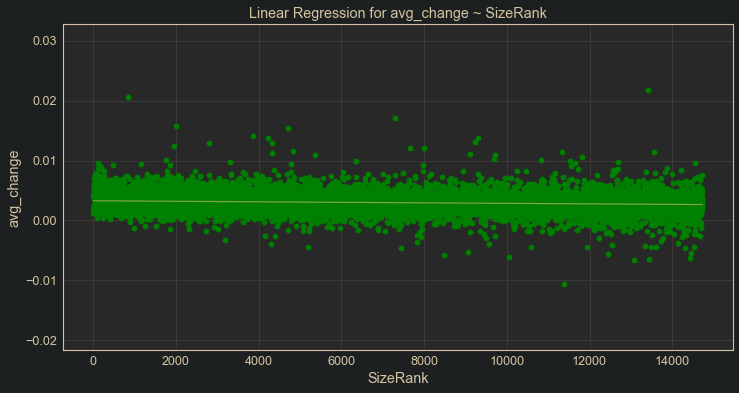

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_change   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     232.8
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           3.65e-52
Time:                        13:39:14   Log-Likelihood:                 75316.
No. Observations:               14723   AIC:                        -1.506e+05
Df Residuals:                   14721   BIC:                        -1.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0033   2.39e-05    136.700      0.000       0.003       0.003
SizeRank   -4.298e-08   2.82e-09    -15.258      0.000   -4.85e-08   -3.75e-08
==============================================================================
Omnibus:                     3405.502   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52557.288
Skew:                           0.691   Prob(JB):                         0.00
Kurtosis:                      12.152   Cond. No.                     1.70e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Test for homoscedasticity of residuals:


F_statistic      p_value
Goldfeld-Quandt     1.55542  1.12559e-71

Normality Test Results for ['residuals']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 residuals 
 Statistic 
 0.496387 
 0.937573 
 
 
 p-value 
 0.000000 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 residuals 
 114.871991 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 residuals 
 
 
 
 
 Statistic 
 52557.287540 
 
 
 p-value 
 0.000000 
 
 
 Skew 
 0.691120 
 
 
 Kurtosis 
 12.152223

Skew: 0.691120172619765
Kurtosis: 9.152222715093057


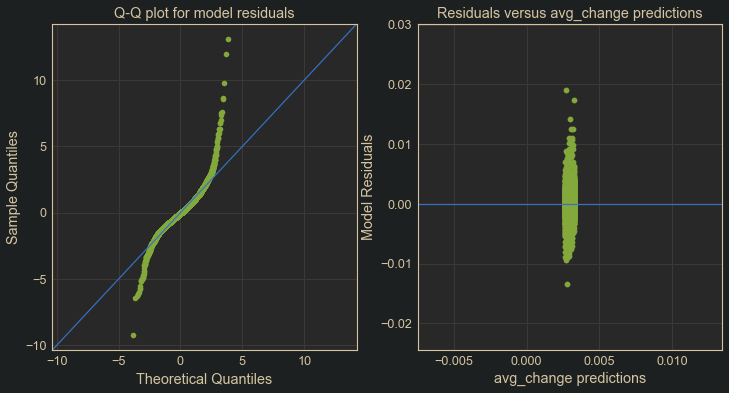

In [22]:
# There does appear to be a small amount of negative correlation between the SizeRank and the
# overall average monthly change of a zipcode. Let's test this relationship further with a
# linear regression.
mf.do_a_linreg(avg_change, 'SizeRank', 'avg_change')

In the above regression, the coefficient for the SizeRank feature's influence on a zipcode's overall average monthly return, though apparently significant, is extremely small, and negligible. Further, the assumptions of the regression were not met, and the R-squared was woeful anyhow. I will assume this feature is not valuable, and ignore it from here.

<a id='data_preparation'></a>
# Data Preparation:

In [23]:
# Dropping the SizeRank column, as well as the RegionID
df.drop(columns=['RegionID', 'SizeRank'], inplace=True)

In [24]:
# Melting dataframe to convert into Long Format
df2 = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName'], var_name='date')
df2.head()

zipcode      City State              Metro CountyName     date     value
0    60657   Chicago    IL            Chicago       Cook  1996-04  334200.0
1    75070  McKinney    TX  Dallas-Fort Worth     Collin  1996-04  235700.0
2    77494      Katy    TX            Houston     Harris  1996-04  210400.0
3    60614   Chicago    IL            Chicago       Cook  1996-04  498100.0
4    79936   El Paso    TX            El Paso    El Paso  1996-04   77300.0

In [25]:
# We can see that the unpivoted dataframe is quite long, with nearly 4 million rows
len(df2)

3901595

In [26]:
# Converting 'date' column to datetime format
df2.date = pd.to_datetime(df2.date, format='%Y-%m')
df2.date

0         1996-04-01
1         1996-04-01
2         1996-04-01
3         1996-04-01
4         1996-04-01
             ...    
3901590   2018-04-01
3901591   2018-04-01
3901592   2018-04-01
3901593   2018-04-01
3901594   2018-04-01
Name: date, Length: 3901595, dtype: datetime64[ns]

In [27]:
# checking 'value' column for missing data:
df2.value.isna().sum()

156891

In [28]:
# There are many missing values, but I will leave them in place for now

# Grouping the data by zipcode
groups = df2.groupby('zipcode')
len(groups)

14723

In [29]:
from IPython.display import display

1001
1002
1005
1007
1008
1010


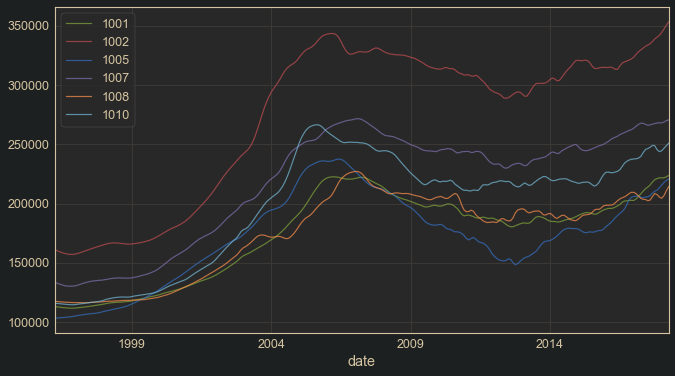

In [30]:
# A quick look at the first 6 zipcodes:
for i, (name, group) in enumerate(groups):
    print(name)
    group.set_index('date').value.plot(figsize=(11,6), alpha=0.7, label=name)
    if i >= 5:
        break
        
plt.legend();

Above we can start to see that not all zipcodes are growing at the same overall rate, and that the 2007 crisis had greater or more long lasting effects on certain ones. For instance, zipcode 01008 and 01001 both had less of a decline post-2007 than zipcode 01005, but they have all seemed to recover to around their pre-crash levels. Earlier, we saw that the average among all zip codes is higher than it was before the crash, meaning some zipcodes have been growing better than others since the low point around 2013, certainly better than the ones above, which all are pretty close to breaking even with their previous highs.

## Finding outperforming zip codes

In [31]:
# First using percent changes
pct_change = df.set_index('zipcode').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName'
                                                  ]).T.pct_change()

In [32]:
pct_change.head()

zipcode     60657     75070     77494     60614     79936     77084     10467  \
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1996-05  0.003591  0.005091  0.008555  0.005621  0.000000  0.002105 -0.001308   
1996-06  0.003280 -0.000844  0.000000  0.004392  0.000000  0.002101 -0.000655   
1996-07  0.003269 -0.005492 -0.007069  0.002982  0.000000  0.003145 -0.001311   
1996-08  0.002666 -0.008921 -0.011391  0.001784  0.001294  0.002090 -0.000656   

zipcode     60640     77449     94109  ...     3765      84781     12429  \
1996-04       NaN       NaN       NaN  ...       NaN       NaN       NaN   
1996-05  0.000924  0.002096  0.006658  ... -0.008663  0.002943  0.000000   
1996-06  0.000923  0.002092  0.007003  ... -0.008739  0.002201 -0.001277   
1996-07  0.000461  0.003132  0.006954  ... -0.010076  0.002196  0.000000   
1996-08  0.000461  0.003122  0.006906  ... -0.008906  0.001461 -0.001279   

zipcode     97028     12720     1338      3293      40404     81225     89155  
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1996-05  0.002937  0.001600 -0.003171 -0.002157  0.003503  0.006803 -0.000567  
1996-06  0.001464  0.001597 -0.003181 -0.001081  0.003490  0.006757 -0.001134  
1996-07  0.000000  0.000000 -0.003191 -0.002165  0.003478  0.006711 -0.000568  
1996-08 -0.000731  0.000000 -0.003202 -0.001085  0.005199  0.006667 -0.000568  

[5 rows x 14723 columns]

Median for 60657: 0.004016387138366273
Mean for 60657: 0.0042950361785796054
Normality Test Results for [60657]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60657 
 Statistic 
 4.952419e-01 
 0.988272 
 
 
 p-value 
 2.559368e-60 
 0.030556 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60657 
 0.970426 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60657 
 
 
 
 
 Statistic 
 1.042787 
 
 
 p-value 
 0.593693 
 
 
 Skew 
 -0.078841 
 
 
 Kurtosis 
 2.735547

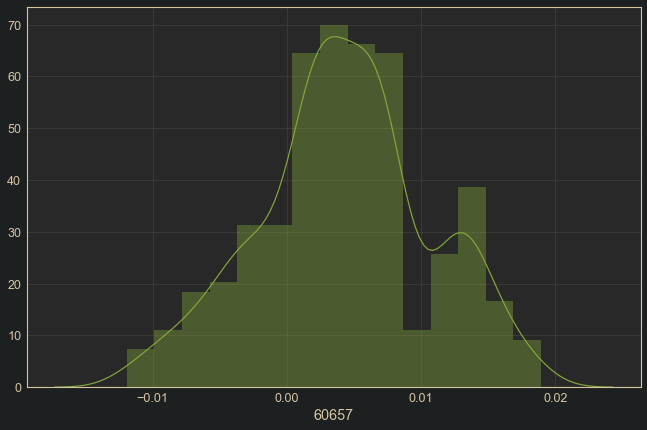

Median for 75070: 0.002254961175804371
Mean for 75070: 0.0012151485394771924
Normality Test Results for [75070]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 75070 
 Statistic 
 4.897961e-01 
 9.421729e-01 
 
 
 p-value 
 6.380644e-59 
 1.105654e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 75070 
 5.644502 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 75070 
 
 
 
 
 Statistic 
 4.307768e+01 
 
 
 p-value 
 4.423863e-10 
 
 
 Skew 
 -5.530765e-01 
 
 
 Kurtosis 
 4.640908e+00

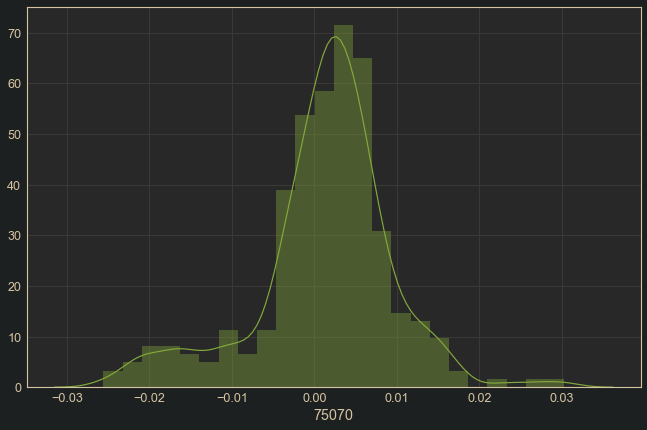

Median for 77494: 0.0013373421057769619
Mean for 77494: 0.00175682453435862
Normality Test Results for [77494]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 77494 
 Statistic 
 4.886697e-01 
 9.440606e-01 
 
 
 p-value 
 1.233816e-58 
 1.722436e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 77494 
 4.750811 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 77494 
 
 
 
 
 Statistic 
 4.542569e+01 
 
 
 p-value 
 1.367529e-10 
 
 
 Skew 
 6.968922e-02 
 
 
 Kurtosis 
 5.027358e+00

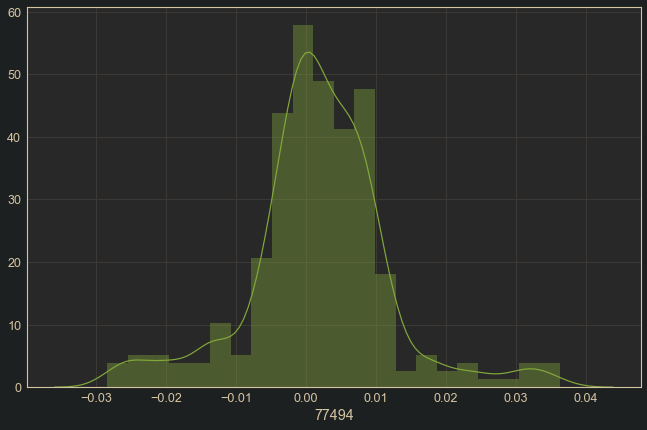

Median for 60614: 0.003648611561309134
Mean for 60614: 0.0036818024757118103
Normality Test Results for [60614]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60614 
 Statistic 
 4.945085e-01 
 0.987546 
 
 
 p-value 
 3.957235e-60 
 0.022071 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60614 
 0.888871 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60614 
 
 
 
 
 Statistic 
 1.131290 
 
 
 p-value 
 0.567994 
 
 
 Skew 
 -0.154046 
 
 
 Kurtosis 
 2.910981

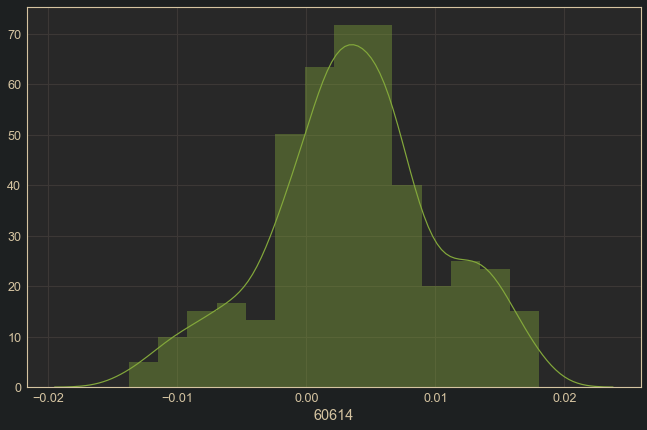

Median for 79936: 0.0012714809964918805
Mean for 79936: 0.001728273319979783
Normality Test Results for [79936]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 79936 
 Statistic 
 4.954825e-01 
 9.577079e-01 
 
 
 p-value 
 2.218038e-60 
 5.729984e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 79936 
 3.097394 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 79936 
 
 
 
 
 Statistic 
 3.524575e+01 
 
 
 p-value 
 2.220667e-08 
 
 
 Skew 
 7.404179e-01 
 
 
 Kurtosis 
 4.005626e+00

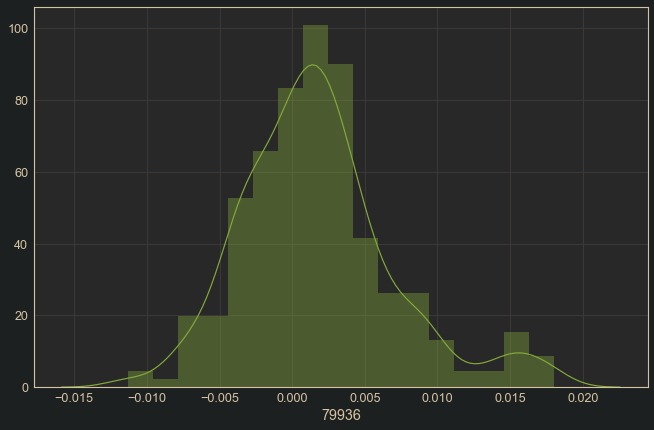

In [33]:
# Checking how normal the distributions are to determine if mean is a reliable statistic to use
for i in range(5):
    subset = pct_change.iloc[:, i]
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [34]:
# We can see that while some of the zipcodes have normally distributed percent changes,
# some do not, so mean may not be the best comparison, and median may be more robust.
# First, I'd like to see how the distributions of log returns look
log_rets = np.log(df.set_index('zipcode').drop(columns=['City', 
                                                   'State', 
                                                   'Metro', 
                                                   'CountyName'
                                                  ]).T).diff()
log_rets.head()

zipcode     60657     75070     77494     60614     79936     77084     10467  \
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1996-05  0.003584  0.005078  0.008519  0.005606  0.000000  0.002103 -0.001309   
1996-06  0.003274 -0.000845  0.000000  0.004382  0.000000  0.002099 -0.000655   
1996-07  0.003264 -0.005507 -0.007094  0.002977  0.000000  0.003140 -0.001311   
1996-08  0.002662 -0.008961 -0.011456  0.001782  0.001293  0.002088 -0.000656   

zipcode     60640     77449     94109  ...     3765      84781     12429  \
1996-04       NaN       NaN       NaN  ...       NaN       NaN       NaN   
1996-05  0.000923  0.002094  0.006636  ... -0.008701  0.002939  0.000000   
1996-06  0.000923  0.002090  0.006979  ... -0.008777  0.002199 -0.001278   
1996-07  0.000461  0.003127  0.006930  ... -0.010127  0.002194  0.000000   
1996-08  0.000461  0.003117  0.006883  ... -0.008946  0.001460 -0.001280   

zipcode     97028     12720     1338      3293      40404     81225     89155  
1996-04       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1996-05  0.002933  0.001599 -0.003176 -0.002160  0.003497  0.006780 -0.000567  
1996-06  0.001463  0.001596 -0.003186 -0.001082  0.003484  0.006734 -0.001135  
1996-07  0.000000  0.000000 -0.003197 -0.002167  0.003472  0.006689 -0.000568  
1996-08 -0.000731  0.000000 -0.003207 -0.001085  0.005186  0.006645 -0.000568  

[5 rows x 14723 columns]

Median for 60657: 0.004008342975265755
Mean for 60657: 0.004265745529291026
Normality Test Results for [60657]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60657 
 Statistic 
 4.952133e-01 
 0.988135 
 
 
 p-value 
 2.603280e-60 
 0.028736 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60657 
 0.971525 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60657 
 
 
 
 
 Statistic 
 1.129386 
 
 
 p-value 
 0.568535 
 
 
 Skew 
 -0.095309 
 
 
 Kurtosis 
 2.742442

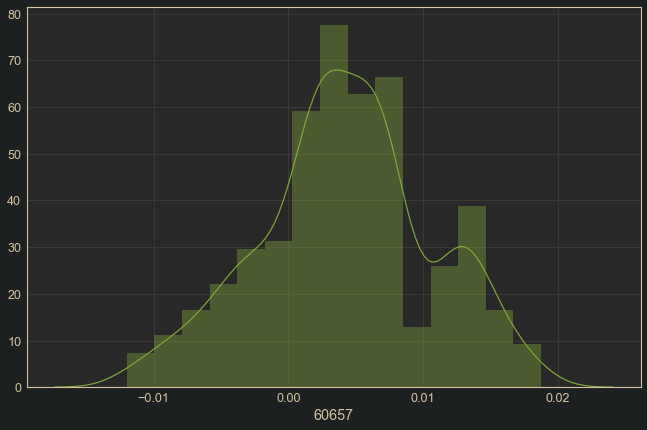

Median for 75070: 0.00225241976995072
Mean for 75070: 0.0011794334265765088
Normality Test Results for [75070]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 75070 
 Statistic 
 4.896633e-01 
 9.404321e-01 
 
 
 p-value 
 6.897024e-59 
 7.403229e-09 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 75070 
 5.807307 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 75070 
 
 
 
 
 Statistic 
 4.543445e+01 
 
 
 p-value 
 1.361552e-10 
 
 
 Skew 
 -5.946513e-01 
 
 
 Kurtosis 
 4.648018e+00

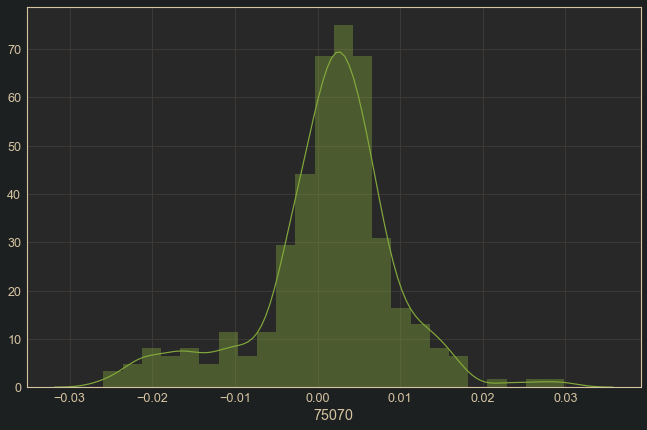

Median for 77494: 0.0013364486127782627
Mean for 77494: 0.0017037087021628033
Normality Test Results for [77494]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 77494 
 Statistic 
 4.885057e-01 
 9.443247e-01 
 
 
 p-value 
 1.357920e-58 
 1.833962e-08 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 77494 
 4.774342 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 77494 
 
 
 
 
 Statistic 
 4.384197e+01 
 
 
 p-value 
 3.018825e-10 
 
 
 Skew 
 8.646898e-03 
 
 
 Kurtosis 
 4.996330e+00

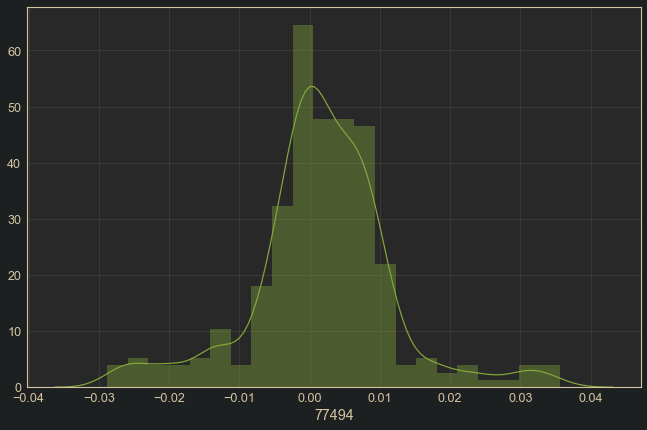

Median for 60614: 0.0036419698370986353
Mean for 60614: 0.003654124445246147
Normality Test Results for [60614]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 60614 
 Statistic 
 4.944704e-01 
 0.987231 
 
 
 p-value 
 4.047864e-60 
 0.019177 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 60614 
 0.901185 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 60614 
 
 
 
 
 Statistic 
 1.373603 
 
 
 p-value 
 0.503183 
 
 
 Skew 
 -0.172390 
 
 
 Kurtosis 
 2.922544

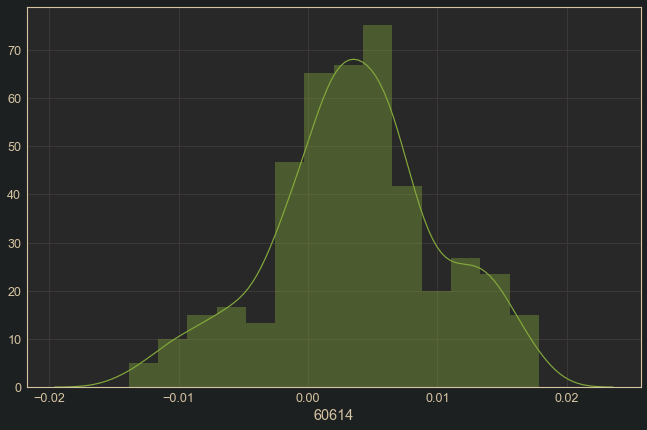

Median for 79936: 0.0012706733330958286
Mean for 79936: 0.0017129557090425275
Normality Test Results for [79936]:
-------------------------------------------------------------------------------------------


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 79936 
 Statistic 
 4.954567e-01 
 9.591054e-01 
 
 
 p-value 
 2.252322e-60 
 8.491392e-07 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 79936 
 3.006986 
 0.776 
 
 
 Jarque-Bera: 
 
 
 
 79936 
 
 
 
 
 Statistic 
 3.334479e+01 
 
 
 p-value 
 5.744751e-08 
 
 
 Skew 
 7.210552e-01 
 
 
 Kurtosis 
 3.975532e+00

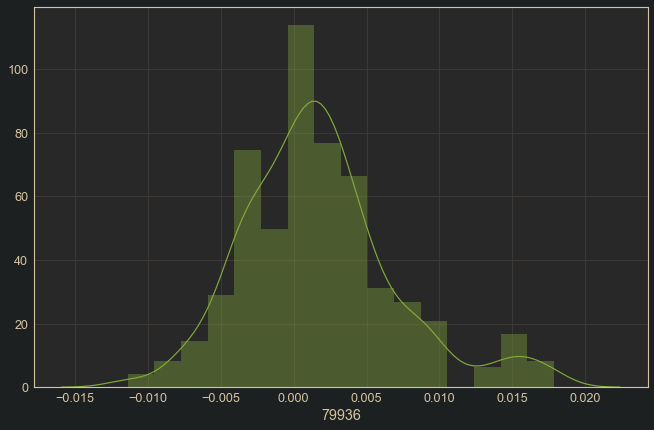

In [35]:
for i in range(5):
    subset = log_rets.iloc[:, i]
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [36]:
# We can see that this didn't fix the normality of the zipcodes. 
# Since medians can sometimes ignore important information about outliers,
# and since the idea here is to find zipcodes which outperformed over time, AND were resilient
# during the crash, it may be better to allow the outliers to have a more weighted impact on
# central tendency so that highly negative values punish the scores.
# I will use both median and mean compare zipcode performance, and compare the two
medians = pct_change.median()
medians.head()

zipcode
60657    0.004016
75070    0.002255
77494    0.001337
60614    0.003649
79936    0.001271
dtype: float64

In [37]:
# Now I'd like to look at the 10 best performers
ten_best_median = medians.sort_values(ascending=False).iloc[:10]
ten_best_median

zipcode
27980    0.023173
30032    0.019451
49636    0.018076
80216    0.016942
89030    0.016561
30288    0.014827
43206    0.014523
94621    0.014402
29405    0.013652
89512    0.013589
dtype: float64

In [38]:
# And now to do the same with the means of log returns:
log_ret_means = log_rets.mean()
log_ret_means.head()

zipcode
60657    0.004266
75070    0.001179
77494    0.001704
60614    0.003654
79936    0.001713
dtype: float64

In [39]:
ten_best_means = log_ret_means.sort_values(ascending=False).iloc[:10]
ten_best_means

zipcode
27980    0.021365
30032    0.020352
80216    0.016964
89030    0.015623
94621    0.015365
43206    0.013883
89512    0.013676
30288    0.013591
95351    0.012892
32435    0.012830
dtype: float64

I now have a list of the ten best performing zip codes according to their median monthly returns and mean log returns over the time period. Some of the same zip codes appear on both lists, so these may make good contenders for inspection. I notice that zip code 49636 is entirely absent from the best performers according to mean, though it is third on the list according to median. This is probably demonstrating the effect of how medians give less weight to outliers. As stated before, the performance based on means may be better for this project, because if another housing market crash occurs, we want to know which zip codes were most resilient during the last one, which is reflected in their low outliers. 

zipcode      City State           Metro  CountyName       date  value
13409    27980  Hertford    NC  Elizabeth City  Perquimans 1996-04-01    NaN
28132    27980  Hertford    NC  Elizabeth City  Perquimans 1996-05-01    NaN
42855    27980  Hertford    NC  Elizabeth City  Perquimans 1996-06-01    NaN
57578    27980  Hertford    NC  Elizabeth City  Perquimans 1996-07-01    NaN
72301    27980  Hertford    NC  Elizabeth City  Perquimans 1996-08-01    NaN

zipcode            City State    Metro CountyName       date  value
842      30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-04-01    NaN
15565    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-05-01    NaN
30288    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-06-01    NaN
45011    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-07-01    NaN
59734    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-08-01    NaN

zipcode        City State          Metro CountyName       date  value
14341    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-04-01    NaN
29064    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-05-01    NaN
43787    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-06-01    NaN
58510    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-07-01    NaN
73233    49636  Glen Arbor    MI  Traverse City   Leelanau 1996-08-01    NaN

zipcode    City State   Metro CountyName       date  value
7302     80216  Denver    CO  Denver     Denver 1996-04-01    NaN
22025    80216  Denver    CO  Denver     Denver 1996-05-01    NaN
36748    80216  Denver    CO  Denver     Denver 1996-06-01    NaN
51471    80216  Denver    CO  Denver     Denver 1996-07-01    NaN
66194    80216  Denver    CO  Denver     Denver 1996-08-01    NaN

zipcode             City State      Metro CountyName       date  value
1998     89030  North Las Vegas    NV  Las Vegas      Clark 1996-04-01    NaN
16721    89030  North Las Vegas    NV  Las Vegas      Clark 1996-05-01    NaN
31444    89030  North Las Vegas    NV  Las Vegas      Clark 1996-06-01    NaN
46167    89030  North Las Vegas    NV  Las Vegas      Clark 1996-07-01    NaN
60890    89030  North Las Vegas    NV  Las Vegas      Clark 1996-08-01    NaN

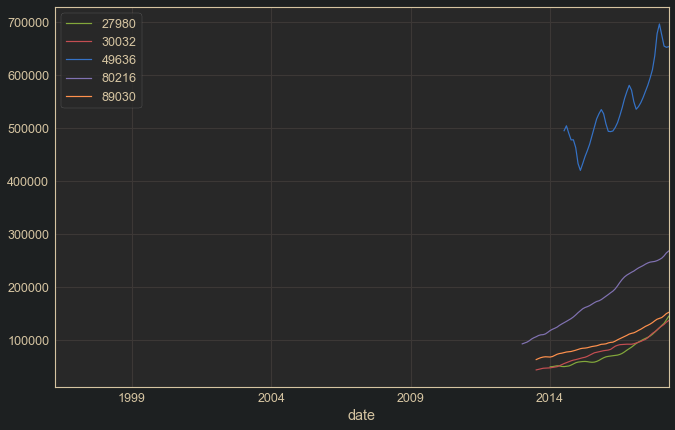

In [40]:
# I would like to compare the top five zipcodes from each list, to see if there is a visible
# difference in their performance
# First the top performers based on median:
for i in range(5):
    name = ten_best_median.index[i]
    zip_code = groups.get_group(name)
    display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.legend();

We can see that we've run into a problem related to NaN values. The zip codes above do not have data going back further than around 2014, which is after the recovery of the crash. This would explain why the central tendency of their returns would seem to outperform zip codes that had data during the crash.

zipcode      City State           Metro  CountyName       date  value
13409    27980  Hertford    NC  Elizabeth City  Perquimans 1996-04-01    NaN
28132    27980  Hertford    NC  Elizabeth City  Perquimans 1996-05-01    NaN
42855    27980  Hertford    NC  Elizabeth City  Perquimans 1996-06-01    NaN
57578    27980  Hertford    NC  Elizabeth City  Perquimans 1996-07-01    NaN
72301    27980  Hertford    NC  Elizabeth City  Perquimans 1996-08-01    NaN

zipcode            City State    Metro CountyName       date  value
842      30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-04-01    NaN
15565    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-05-01    NaN
30288    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-06-01    NaN
45011    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-07-01    NaN
59734    30032  Candler-Mcafee    GA  Atlanta     Dekalb 1996-08-01    NaN

zipcode    City State   Metro CountyName       date  value
7302     80216  Denver    CO  Denver     Denver 1996-04-01    NaN
22025    80216  Denver    CO  Denver     Denver 1996-05-01    NaN
36748    80216  Denver    CO  Denver     Denver 1996-06-01    NaN
51471    80216  Denver    CO  Denver     Denver 1996-07-01    NaN
66194    80216  Denver    CO  Denver     Denver 1996-08-01    NaN

zipcode             City State      Metro CountyName       date  value
1998     89030  North Las Vegas    NV  Las Vegas      Clark 1996-04-01    NaN
16721    89030  North Las Vegas    NV  Las Vegas      Clark 1996-05-01    NaN
31444    89030  North Las Vegas    NV  Las Vegas      Clark 1996-06-01    NaN
46167    89030  North Las Vegas    NV  Las Vegas      Clark 1996-07-01    NaN
60890    89030  North Las Vegas    NV  Las Vegas      Clark 1996-08-01    NaN

zipcode     City State          Metro CountyName       date  value
4712     94621  Oakland    CA  San Francisco    Alameda 1996-04-01    NaN
19435    94621  Oakland    CA  San Francisco    Alameda 1996-05-01    NaN
34158    94621  Oakland    CA  San Francisco    Alameda 1996-06-01    NaN
48881    94621  Oakland    CA  San Francisco    Alameda 1996-07-01    NaN
63604    94621  Oakland    CA  San Francisco    Alameda 1996-08-01    NaN

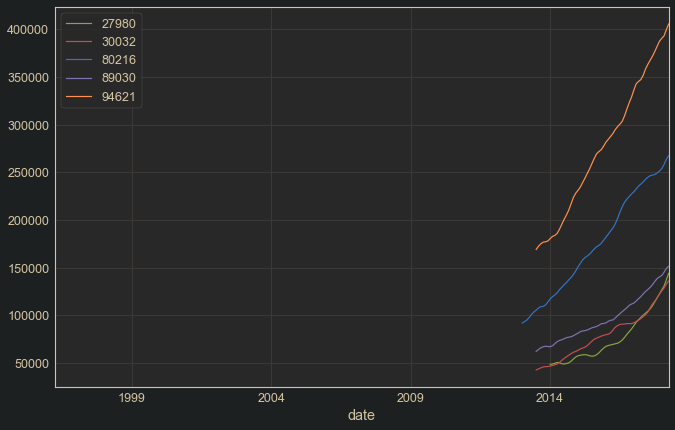

In [41]:
# Looking at the best performing based on mean
for i in range(5):
    name = ten_best_means.index[i]
    zip_code = groups.get_group(name)
    display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.legend();

Again, we are seeing the same problem. Zip codes which did not have data going back past around 2014 showing better performance than zip codes which had data during the crash.

In [50]:
# Before I do, I may need a list of zipcodes containing large amounts of NaN values, because
# these could cause misrepresentations when combined with the rest of the zipcodes which have
# more historical data.
counts = {}
for name, group in groups:
    count = group.value.isna().sum()
    if count > 0:
        counts[name] = count

In [51]:
# Let's see how many zipcodes are missing values
len(counts)

1039

In [52]:
# Finding the number of dates in the data
for i, (name, group) in enumerate(groups):
    print("Number of dates in the data:", len(group.values))
    if i == 0:
        break

Number of dates in the data: 265


In [53]:
# We can see there are 1039 zip codes for which there is incomplete data over the time frame
# This is not a huge amount, but it does add a bit of complexity when comparing the performance
# of zip codes.
# Let's see how many values are missing from each of these zip codes, keeping in mind that
# there are 265 dates in total
N = 2000
res = dict(sorted(counts.items(), key = itemgetter(1), reverse = True)[:N]) 
for k, v in res.items():
    print(k, v)

2116 219
4009 219
16625 219
19954 219
22625 219
28039 219
28088 219
31527 219
32435 219
35759 219
35760 219
35810 219
35816 219
35824 219
39202 219
39216 219
43406 219
43443 219
43450 219
43466 219
43619 219
44491 219
45872 219
46320 219
46327 219
47336 219
47371 219
47373 219
47512 219
48157 219
49245 219
49253 219
49636 219
49950 219
53015 219
54230 219
56441 219
62215 219
62216 219
62440 219
62870 219
62882 219
62922 219
65259 219
66739 219
67544 219
68730 219
70431 219
70515 219
70647 219
72718 219
73173 219
74857 219
97435 219
97467 219
97499 219
10456 213
11749 213
12428 213
12458 213
13797 213
15943 213
21225 213
27980 213
29405 213
30288 213
32764 213
35773 213
35806 213
37184 213
38858 213
38862 213
38868 213
43013 213
43206 213
43211 213
43219 213
43569 213
44411 213
44449 213
49284 213
49799 213
50233 213
62401 213
65020 213
65556 213
65786 213
67062 213
67117 213
67156 213
70615 213
70812 213
75210 213
75941 213
78593 213
88044 213
88047 213
88048 213
89512 213
93268 213
93

In [54]:
# In order to truly compare zipcodes, we will need to only compare their average returns over
# time periods for which they share data.

### Looking at zipcodes without missing data

In [55]:
# First step is to compare all the zipcodes with full data, then compare the best from that 
# category with those for whom the data is more limited.
# I am going to stick with using means because I want low outliers caused by the crash to
# penalize the average scores more, so that I am left with the most resilient zip codes
indices = [ind for ind in log_ret_means.index if ind not in counts.keys()]
ten_best_means = log_ret_means.loc[indices].sort_values(ascending=False).iloc[:10]
ten_best_means

zipcode
11211    0.009472
11222    0.009263
11216    0.009063
7302     0.008872
11215    0.008700
11975    0.008692
11930    0.008553
80449    0.008290
90291    0.008228
20001    0.008161
dtype: float64

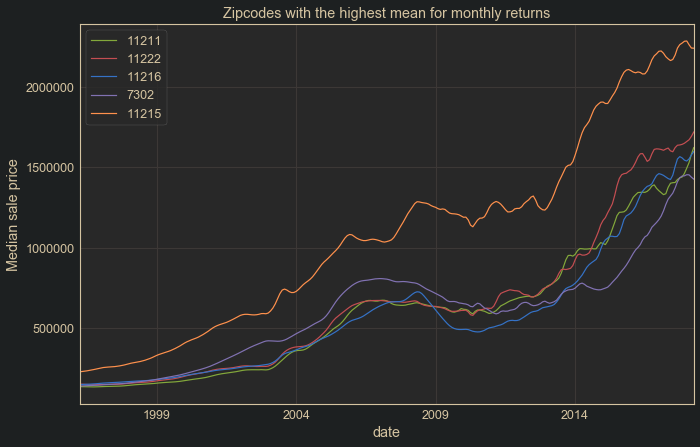

In [56]:
for i in range(5):
    name = ten_best_means.index[i]
    zip_code = groups.get_group(name)
    #display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.title("Zipcodes with the highest mean for monthly returns")
plt.ylabel("Median sale price")
plt.legend();

In [57]:
# As we can see, this has resulted in filtering to zip codes which were extraordinarily
# resilient to the crash, with some barely responding to the crisis.
# Another thing to note here is that these represent extremely expensive neighborhoods,
# which makes sense, since the wealthy would have been the least impacted by the economic crash
# This should make a handy benchmark to compare the monthly returns of zip codes which had
# incomplete data.
# Just out of curiosity, I'd like to run this process using the medians
indices = [ind for ind in medians.index if ind not in counts.keys()]
ten_best_medians = medians.loc[indices].sort_values(ascending=False).iloc[:10]
ten_best_medians

zipcode
2119     0.012136
94590    0.010776
2121     0.010699
94601    0.010652
86334    0.010645
7302     0.010415
94606    0.010350
90291    0.010324
11963    0.010146
2657     0.010141
dtype: float64

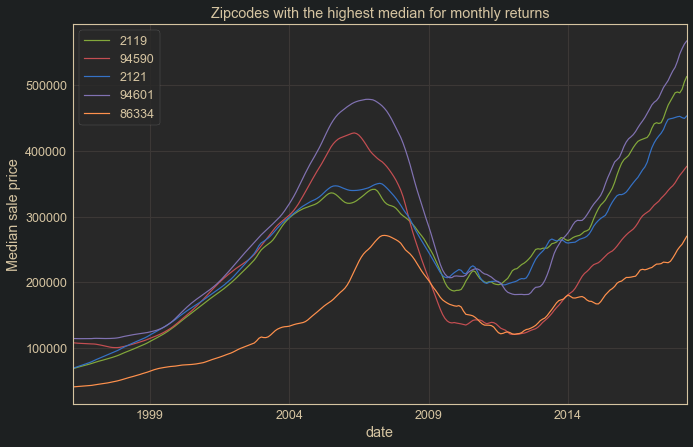

In [58]:
# We can see immediately that these values are higher, since the lower outliers have not 
# penalized the average as much. Let's look at a chart of the top 5
for i in range(5):
    name = ten_best_medians.index[i]
    zip_code = groups.get_group(name)
    #display(zip_code.head())
    zip_code.set_index('date').value.plot(label=name)
plt.title("Zipcodes with the highest median for monthly returns")
plt.ylabel("Median sale price")
plt.legend();

In [59]:
# Woof. We can see that these zip codes did not handle the crash nearly as well. Most of these
# lost over half of their value during the recession. These are much more middle-class homes,
# and these would have been the houses that people were taking loans that turned out to be
# out of their ability to pay, which ultimately got foreclosed on. However, it should be noted
# that the rate of their recovery was very solid after around 2013

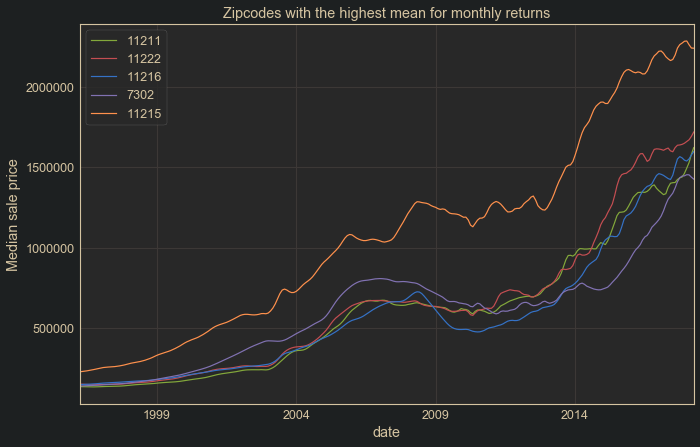

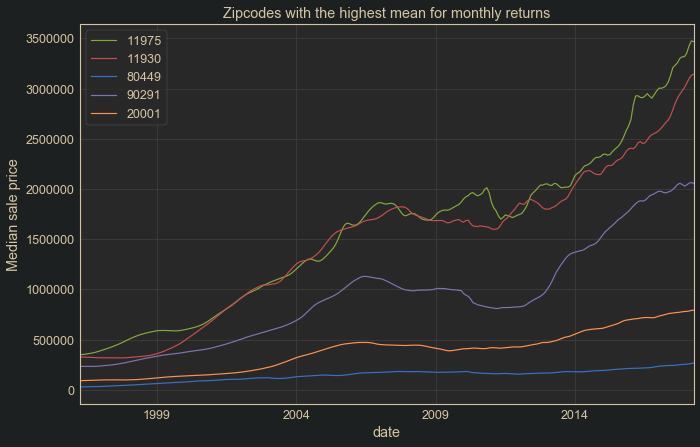

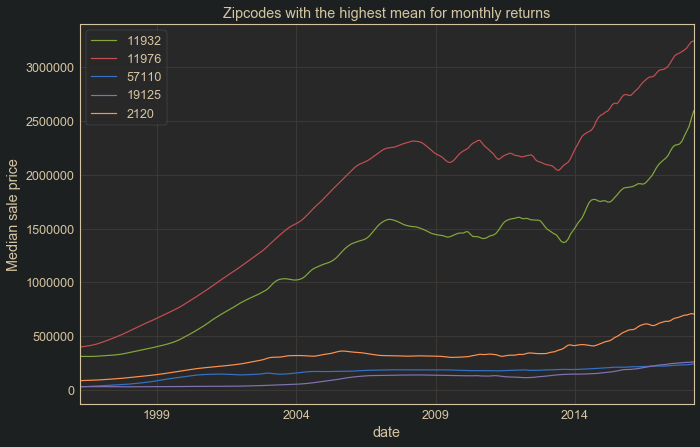

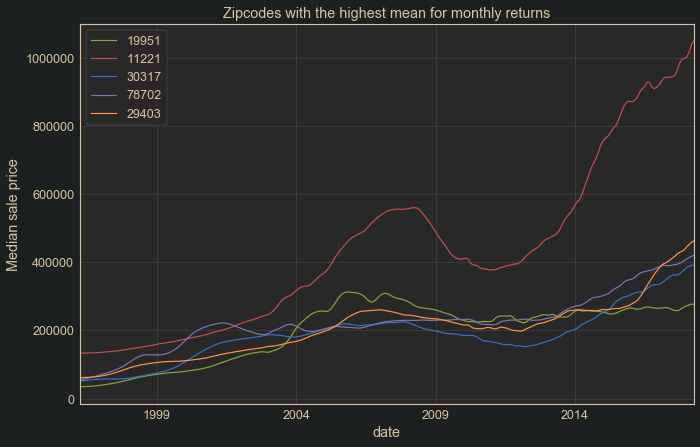

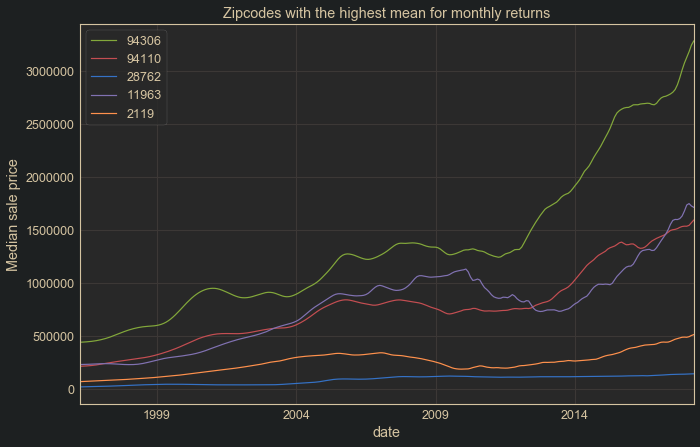

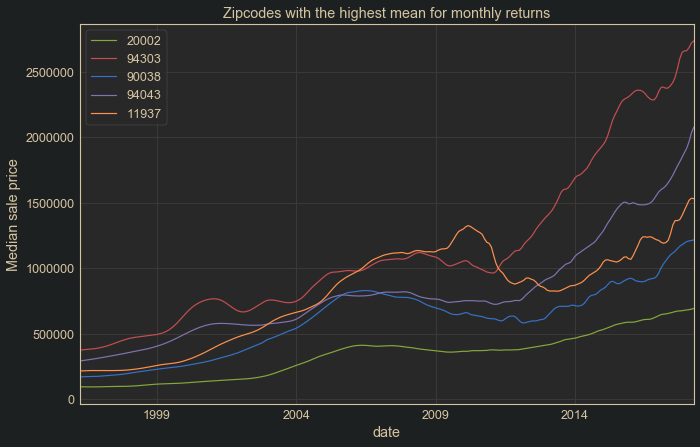

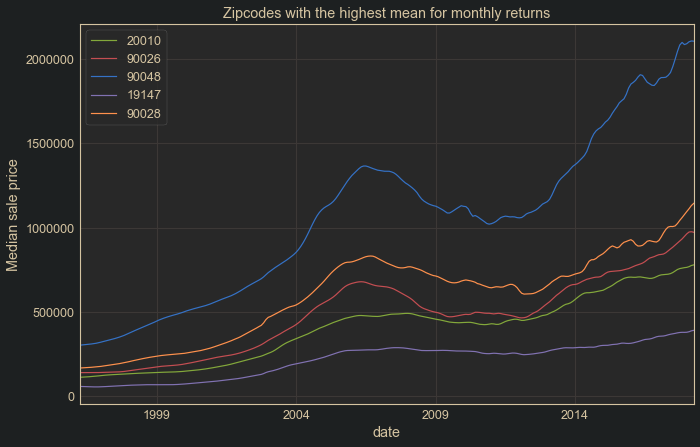

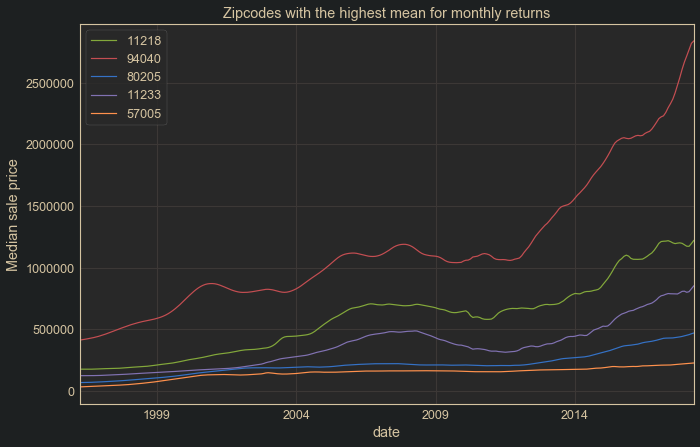

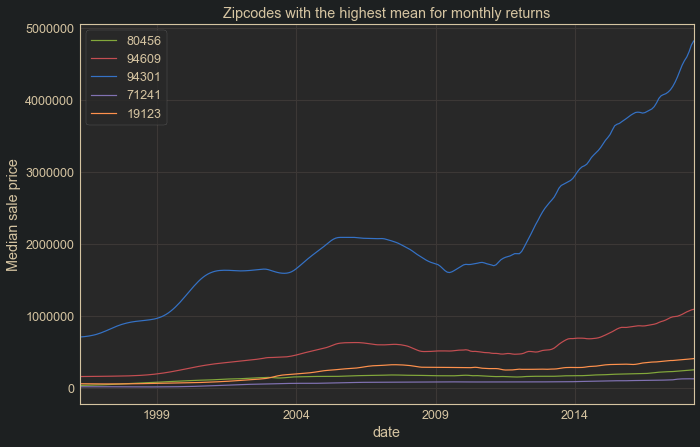

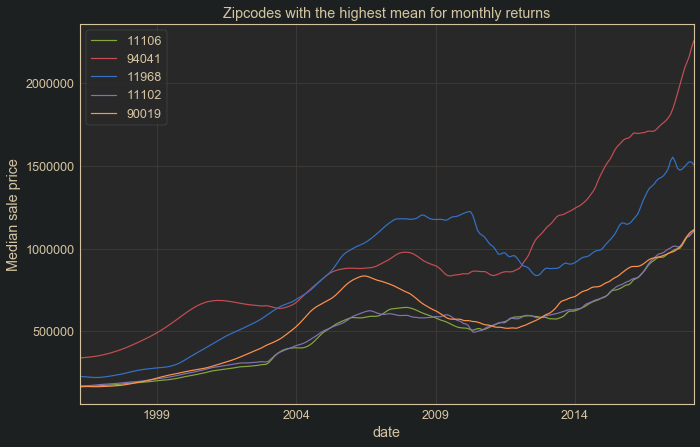

In [60]:
# What I will do now, to see if I can find any zip codes which were resilient, but also don't 
# cost a fortune to invest in, is iterate over the highest mean returns a few times, 5 at a time
# to see what I can find.
best_means = log_ret_means.loc[indices].sort_values(ascending=False).iloc[:50]
n = 0
for i in range(10):
    for j in range(5):
        name = best_means.index[n]
        zip_code = groups.get_group(name)
        #display(zip_code.head())
        zip_code.set_index('date').value.plot(label=name)
        n += 1
    plt.title("Zipcodes with the highest mean for monthly returns")
    plt.ylabel("Median sale price")
    plt.legend()
    plt.show()

In [61]:
# A look at the scores for these zipcodes for comparison
best_means

zipcode
11211    0.009472
11222    0.009263
11216    0.009063
7302     0.008872
11215    0.008700
11975    0.008692
11930    0.008553
80449    0.008290
90291    0.008228
20001    0.008161
11932    0.008005
11976    0.007925
57110    0.007925
19125    0.007898
2120     0.007891
19951    0.007889
11221    0.007802
30317    0.007662
78702    0.007658
29403    0.007644
94306    0.007610
94110    0.007608
28762    0.007606
11963    0.007605
2119     0.007602
20002    0.007546
94303    0.007532
90038    0.007451
94043    0.007432
11937    0.007429
20010    0.007394
90026    0.007392
90048    0.007369
19147    0.007339
90028    0.007322
11218    0.007311
94040    0.007301
80205    0.007292
11233    0.007286
57005    0.007266
80456    0.007263
94609    0.007262
94301    0.007256
71241    0.007252
19123    0.007211
11106    0.007210
94041    0.007174
11968    0.007152
11102    0.007146
90019    0.007142
dtype: float64

Now that we have narrowed our view to zipcodes that have performed very well over the time frame, we notice that some of these zipcodes contain very expensive properties on average, up in the millions of dollars. Since buying and holding properties in hopes of capital appreciation comes with costs (property tax, insurance, maintenance, lost risk-free-rate investment), a real estate investment company would need to consider renting the properties it is holding over the investment horizon. This leads us to some questions: if the goal is to rent properties in the short term, what are the differences in renting luxury houses (million dollar homes) vs utility houses? Are there renters for luxury homes? What is the difference in profitability of renting luxury homes vs utility homes?<br>
<br>
A [very informative article](https://www.financialsamurai.com/real-estate-investing-rule-rent-luxury-buy-utility/) written by Sam Dogen, founder of Financial Samurai, explains the scenario from the perspective of a real estate investor and consultant. Dogen explains a principle that he calls BURL (Buy Utility, Rent Luxury), explaining that luxury homes, especially in coastal cities, tend to not have near the yearly profitability through renting as utility homes, and often have no profitability at all, with the rent merely covering the expenses of ownership, and in some cases not even doing that. He also mentions that the "valuations are stretched in expensive coastal cities." <br>
<br>
Here is an informative graphic from the article, sourced from [Zillow](https://www.zillow.com/research/where-rent-covers-mortgage-15624/):
![Zillow Analysis Graphic](https://i2.wp.com/financialsamurai.com/wp-content/uploads/2017/06/where-it-pays-to-be-a-landlord.jpg?fit=1456,9999)<br>

We can see from the chart that big expensive coastal cities have a low chance of profitability for renting out properties. Dogen makes clear in the article that it is better to buy less expensive properties in non-luxury cities, especially those in the Midwest, which can be rented for a much higher ratio to their value, in order to generate income. This means that for our client, we should be looking for the zip codes with the strongest growth and best resilience that do not predominantly contain expensive luxury homes. I will then hand select some of the zip codes shown above that currently have median values less than $ 500,000, and look more closely at them. 

In [62]:
# 15 zip codes meeting our criteria so far
good_zips = [80449, 19125, 57110, 19951, 30317, 78702, 29403, 28762, 2119, 19147, 80205,
             57005, 80456, 71241, 19123
            ]
best_means.loc[good_zips]

zipcode
80449    0.008290
19125    0.007898
57110    0.007925
19951    0.007889
30317    0.007662
78702    0.007658
29403    0.007644
28762    0.007606
2119     0.007602
19147    0.007339
80205    0.007292
57005    0.007266
80456    0.007263
71241    0.007252
19123    0.007211
dtype: float64

City State         Metro    CountyName   avgReturn
80449       Hartsel    CO        Denver          Park  0.00829042
19125  Philadelphia    PA  Philadelphia  Philadelphia   0.0078984
57110   Sioux Falls    SD   Sioux Falls     Minnehaha  0.00792513
19951      Harbeson    DE     Salisbury        Sussex    0.007889
30317       Atlanta    GA       Atlanta        Fulton  0.00766231

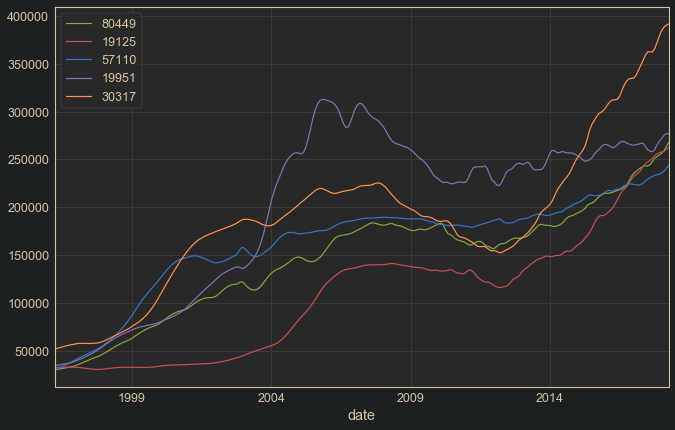

City State         Metro    CountyName   avgReturn
78702        Austin    TX        Austin        Travis  0.00765756
29403    Charleston    SC    Charleston    Charleston   0.0076441
28762      Old Fort    NC        Marion      McDowell  0.00760581
2119         Boston    MA        Boston       Suffolk  0.00760167
19147  Philadelphia    PA  Philadelphia  Philadelphia  0.00733891

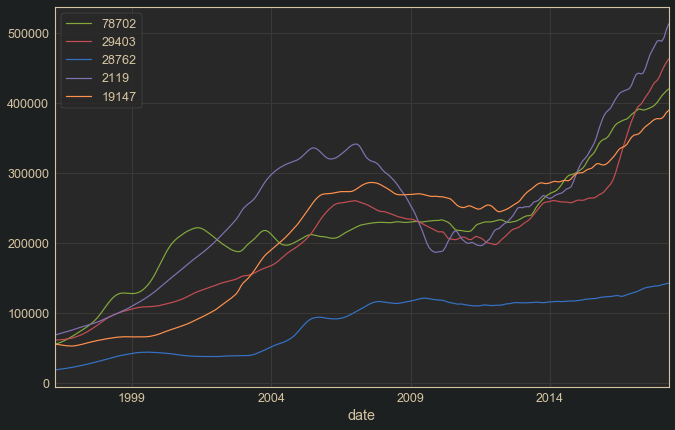

City State         Metro    CountyName   avgReturn
80205        Denver    CO        Denver        Denver  0.00729196
57005       Brandon    SD   Sioux Falls     Minnehaha  0.00726574
80456     Jefferson    CO        Denver          Park  0.00726346
71241   Farmerville    LA        Monroe         Union  0.00725226
19123  Philadelphia    PA  Philadelphia  Philadelphia  0.00721051

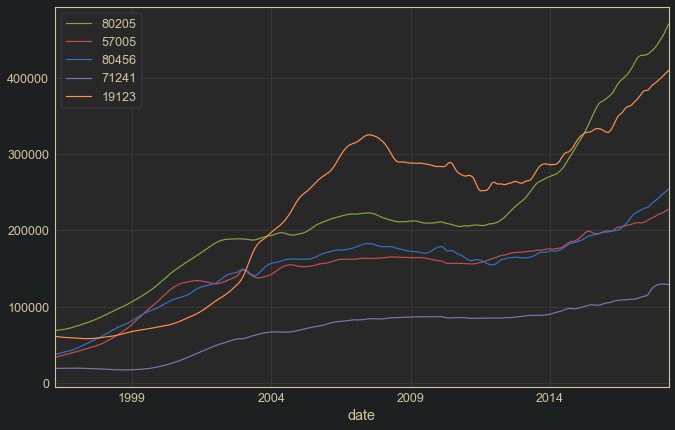

In [63]:
zips_df = df.set_index('zipcode').loc[good_zips][['City', 
                                                  'State', 
                                                  'Metro', 
                                                  'CountyName']].merge(pd.Series(best_means.loc[good_zips], 
                                                                                 name='avgReturn'), 
                                                                       left_index=True, 
                                                                       right_on='zipcode')

i = 1
view_df = pd.DataFrame()
for idx in good_zips:
    grp = groups.get_group(idx)
    view_df = pd.concat([view_df, pd.DataFrame(zips_df.loc[idx]).T], axis=0)
    grp.set_index('date').value.plot(label=idx)
    if i % 5 == 0:
        display(view_df)
        view_df = pd.DataFrame()
        plt.legend()
        plt.show()
    i += 1

A few things to note now that we have narrowed our view down to 15 zip codes is that among these candidates, some had better growth before the crash, then have mostly leveled off since then, while others have shown very strong growth more recently. Since our client would be investing in the current market, it is likely that it would be better to select the zip codes which are currently showing momentum. <br>
<br>
Looking at the actual locations of these candidates, there are a few we can probably dismiss. Boston is a no-go, and Austin does not look promising either. Philadelphia is a maybe, and there are three results from this area in this list. All of these have shown strong recent growth.
<br>
Sioux Falls, SD looks like a gem, with a nice linear upward trend, and a location which is not considered luxury. Brandon is in the same area, with a similar growth curve.<br>
<br>
Hartsel, CO looks goood, because it is in the Denver metro area, but a wikipedia and google search shows that it is a 2hr drive, with a population of 667, up in the mountains, so it may be somewhat of a luxury area. Nevertheless, the property is appreciating nicely, with the highest average monthly return on this list, so it might be worth consideration. A google search led me to [Xome.com](https://www.xome.com/homes-for-sale/CO/Hartsel), which says that in Hartsel, "approximately 31.24% of Hartsel homes are owned, compared to 0.48% rented, while 68.28% are vacant." Therefore, this is not a good prospect for real estate investors. Jefferson, CO is similarly located over an hour outside of Denver in a rural area with a small population.<br>
<br>
Harbeson can probably be ignored, because it has not had strong growth in the recent years. It is on this list mostly because of its resiliency to the crash and its rapid growth prior to it.<br>
<br>
The Atlanta zipcode has shown very strong growth in recent years. Sometimes fast growth means an upcoming pull back, but we'll keep this zip code in mind, as Atlanta is quite high up on the above Zillow list. A Google search reveals that this zip code is right outside of downtown, making it quite urban.<br>
<br>
Old Fort is intriguing. It has low prices, and was quite resilient to the crash. I am actually familiar with the town, as I used to drive past it on my way in and out of Asheville, NC, which is a rapidly growing area with high real estate prices. Old Fort is only 37 minutes away, and much cheaper, so it stands to reason that people might invest in Old Fort and commute to Asheville.<br>
<br>
Farmerville, LA is probably too small to consider, with not much more than a Wal-Mart, in a rural area of Louisiana.

#### A note on investment diversity and risk exposure:
In finance, portfolio managers diversify investments in order to limit the amount of certain types of risk the portfolio is exposed to. This is often thought of in terms of sector (technology, financials, etc), but risk can be regional as well. This means that for a real estate investor, putting all of your eggs in one geographical basket is more risky than spreading them around, because something that affects one area may not affect another, and also something that affects metropolitan areas may affect more rural areas differently. In the context of this client, it stands to reason that they should invest in various areas, with some in urban areas, and some in more (but not completely) rural areas.

#### Notes so far:
Taking everything into consideration so far, it looks like Sioux Falls and Old Fort are good investment opportunities. Sioux Falls is much larger than Old Fort, but Old Fort is very close to Asheville, NC, which is a rapidly growing area, and a google search reveals that 45.38% of households in Old Fort are rentals. Atlanta looks very promising as an urban investment, with powerful recent growth, and the zipcode is right outside of downtown. Three seperate zipcodes from Philadelphia appeared in our list, all showing powerful recent growth as well as resilience to the crash. The best of these three should be considered a good investment opportunity. This gives us four prospects so far, and we have not yet looked at any of the zip codes which had missing data. One thing to note about zip codes with missing data is that they may have newer construction, which is always appealing, and new construction is generally placed in areas with expected growth. Let's move on now to inspect the zip codes that had missing data.

### Looking at zipcodes with missing data

In [64]:
# Let's take a fresh look at the dictionary of zipcodes that were missing data, and how many
# NaNs they contained
for k, v in res.items():
    print('{}: {}'.format(k, v))

2116: 219
4009: 219
16625: 219
19954: 219
22625: 219
28039: 219
28088: 219
31527: 219
32435: 219
35759: 219
35760: 219
35810: 219
35816: 219
35824: 219
39202: 219
39216: 219
43406: 219
43443: 219
43450: 219
43466: 219
43619: 219
44491: 219
45872: 219
46320: 219
46327: 219
47336: 219
47371: 219
47373: 219
47512: 219
48157: 219
49245: 219
49253: 219
49636: 219
49950: 219
53015: 219
54230: 219
56441: 219
62215: 219
62216: 219
62440: 219
62870: 219
62882: 219
62922: 219
65259: 219
66739: 219
67544: 219
68730: 219
70431: 219
70515: 219
70647: 219
72718: 219
73173: 219
74857: 219
97435: 219
97467: 219
97499: 219
10456: 213
11749: 213
12428: 213
12458: 213
13797: 213
15943: 213
21225: 213
27980: 213
29405: 213
30288: 213
32764: 213
35773: 213
35806: 213
37184: 213
38858: 213
38862: 213
38868: 213
43013: 213
43206: 213
43211: 213
43219: 213
43569: 213
44411: 213
44449: 213
49284: 213
49799: 213
50233: 213
62401: 213
65020: 213
65556: 213
65786: 213
67062: 213
67117: 213
67156: 213
70615: 213
7

In [65]:
# I think the best way to deal with the variety of time windows missing from these zipcodes
# is to split them into lists which correspond to their amount of missing data, stored in 
# a dictionary, then iterate through the various missing data lengths, dropping any zip codes
# which have more missing data, then running a full comparison, and seeing if any of the newly
# added zip codes at any missing data length appear in the list of top 50 performing zip codes
# that result.
# First, I'm going to regenerate the original dictionary with ascending values
res = dict(sorted(counts.items(), key = itemgetter(1), reverse = False)) 
res

{23047: 15,
 23015: 21,
 23192: 21,
 2301: 87,
 2302: 87,
 3256: 87,
 4037: 87,
 4963: 87,
 10459: 87,
 11944: 87,
 12775: 87,
 12783: 87,
 12790: 87,
 14025: 87,
 14030: 87,
 14032: 87,
 14033: 87,
 14080: 87,
 14222: 87,
 16102: 87,
 16112: 87,
 16116: 87,
 16120: 87,
 16142: 87,
 16143: 87,
 16156: 87,
 16157: 87,
 18326: 87,
 18332: 87,
 18344: 87,
 18350: 87,
 18372: 87,
 19939: 87,
 19945: 87,
 20871: 87,
 21738: 87,
 21875: 87,
 24013: 87,
 24016: 87,
 27939: 87,
 27948: 87,
 27949: 87,
 27954: 87,
 27958: 87,
 28574: 87,
 28634: 87,
 28660: 87,
 30103: 87,
 30120: 87,
 30121: 87,
 30139: 87,
 30145: 87,
 30171: 87,
 30178: 87,
 30184: 87,
 31523: 87,
 31757: 87,
 32033: 87,
 32343: 87,
 32465: 87,
 33859: 87,
 34288: 87,
 34773: 87,
 37882: 87,
 42776: 87,
 45305: 87,
 45314: 87,
 45335: 87,
 45370: 87,
 45385: 87,
 45387: 87,
 45430: 87,
 48650: 87,
 48708: 87,
 49620: 87,
 50109: 87,
 50323: 87,
 55129: 87,
 55360: 87,
 56096: 87,
 57018: 87,
 57020: 87,
 57033: 87,
 57035: 8

In [66]:
last_length = 0
zip_groups = {}
lst = []
for k, v in res.items():
    if v != last_length:
        if len(lst) > 0:
            zip_groups[last_length] = lst
        lst = [k]
        last_length = v
    else:
        lst.append(k)

In [67]:
zip_groups

{15: [23047],
 21: [23015, 23192],
 87: [2301,
  2302,
  3256,
  4037,
  4963,
  10459,
  11944,
  12775,
  12783,
  12790,
  14025,
  14030,
  14032,
  14033,
  14080,
  14222,
  16102,
  16112,
  16116,
  16120,
  16142,
  16143,
  16156,
  16157,
  18326,
  18332,
  18344,
  18350,
  18372,
  19939,
  19945,
  20871,
  21738,
  21875,
  24013,
  24016,
  27939,
  27948,
  27949,
  27954,
  27958,
  28574,
  28634,
  28660,
  30103,
  30120,
  30121,
  30139,
  30145,
  30171,
  30178,
  30184,
  31523,
  31757,
  32033,
  32343,
  32465,
  33859,
  34288,
  34773,
  37882,
  42776,
  45305,
  45314,
  45335,
  45370,
  45385,
  45387,
  45430,
  48650,
  48708,
  49620,
  50109,
  50323,
  55129,
  55360,
  56096,
  57018,
  57020,
  57033,
  57035,
  57078,
  57104,
  57105,
  57106,
  57107,
  61011,
  63101,
  68832,
  72764,
  73150,
  78616,
  79415,
  80642,
  83263,
  86315,
  86413,
  89448,
  89449,
  93529,
  93546,
  93664,
  95228,
  95249,
  95453,
  96020,
  96708,
  9

In [68]:
# checking how using the dictionary keys with iloc would work
log_rets.iloc[15:][23047].head()

1997-07         NaN
1997-08    0.042354
1997-09    0.041769
1997-10    0.040094
1997-11    0.038549
Name: 23047, dtype: float64

In [69]:
# we can see that we'll need to add 1 to each key to correctly limit the time window
log_rets.iloc[15+1:][23047].head()

1997-08    0.042354
1997-09    0.041769
1997-10    0.040094
1997-11    0.038549
1997-12    0.041158
Name: 23047, dtype: float64

zipcode
11238    0.008528
11217    0.007365
68526    0.006950
11231    0.006692
dtype: float64

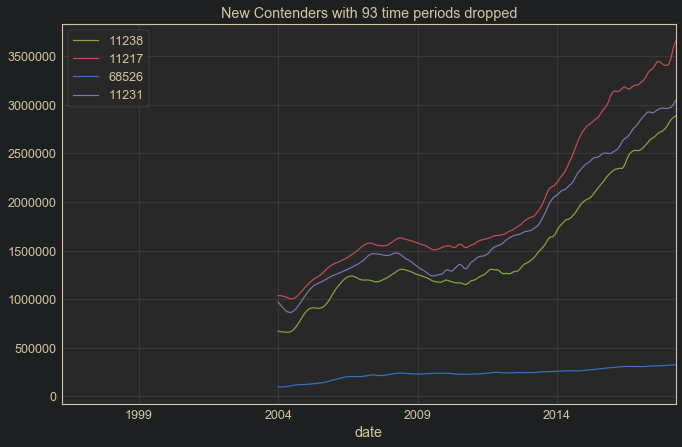

zipcode
10011    0.007016
dtype: float64

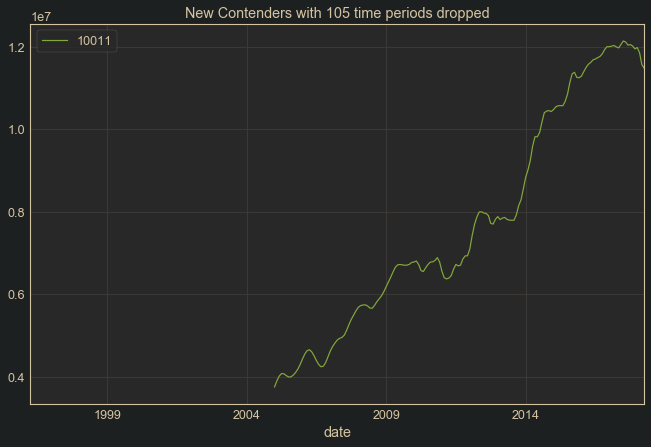

zipcode
58801    0.008190
96771    0.005774
dtype: float64

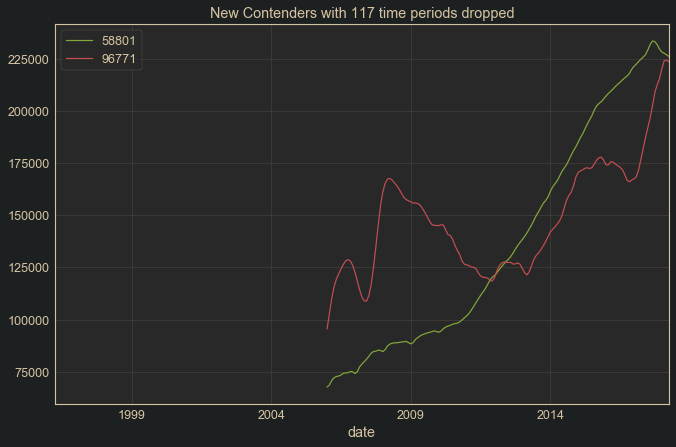

zipcode
58318    0.00611
dtype: float64

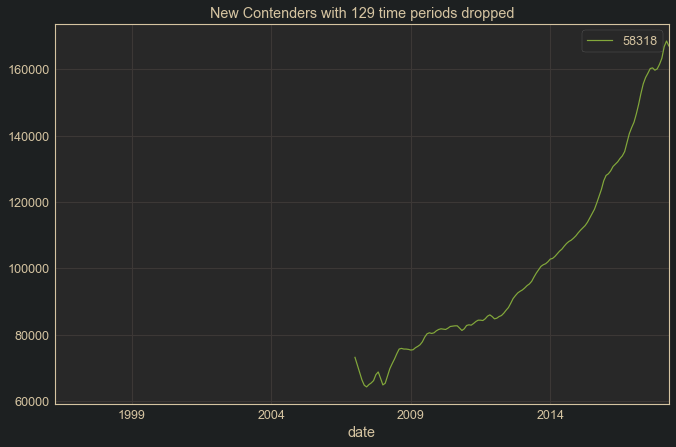

zipcode
85035    0.012214
94608    0.010032
dtype: float64

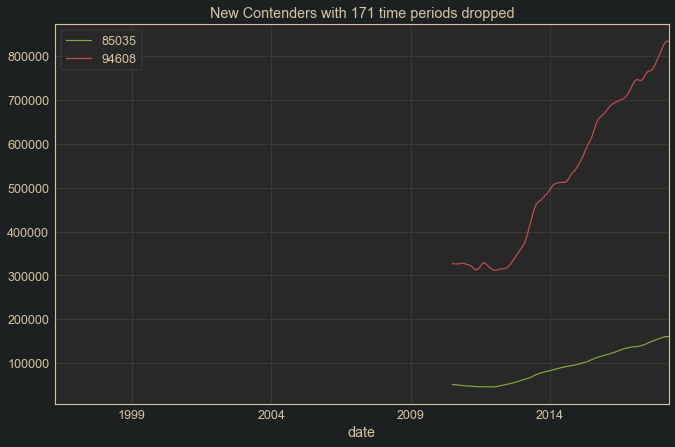

zipcode
33974    0.012062
33976    0.012003
dtype: float64

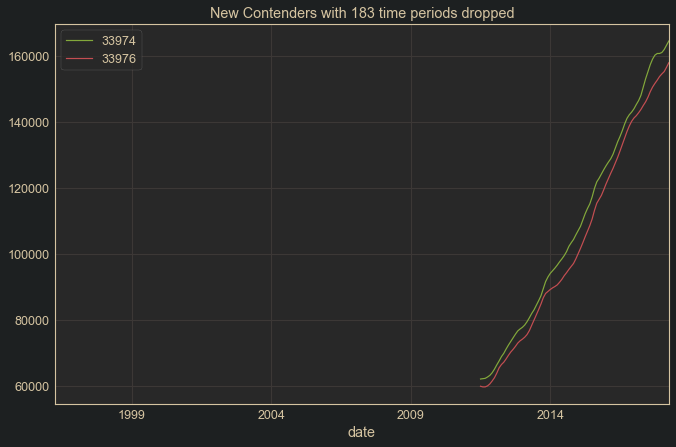

zipcode
80216    0.016964
dtype: float64

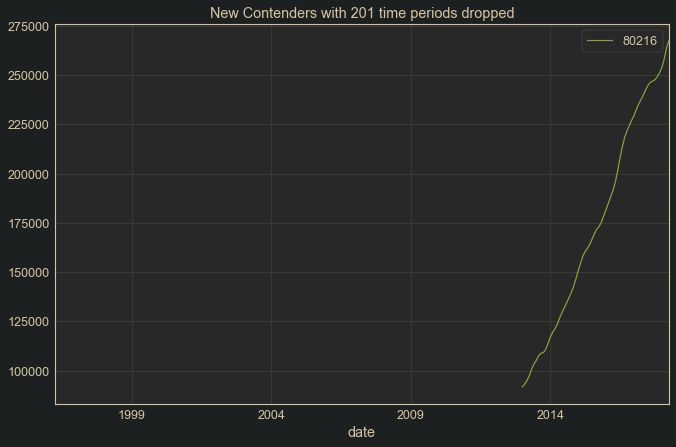

zipcode
30032    0.020352
89030    0.015623
94621    0.015365
dtype: float64

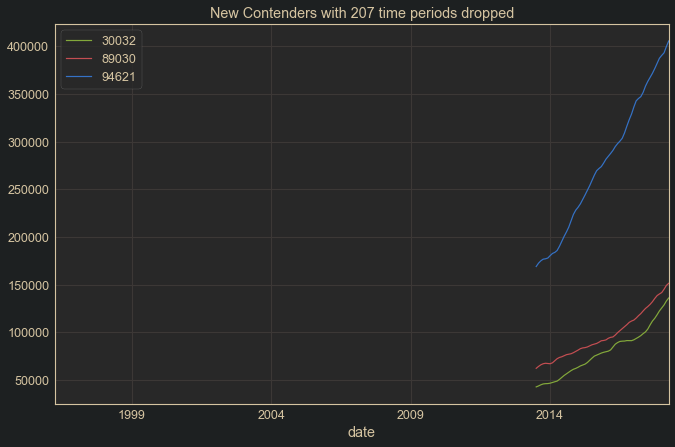

zipcode
27980    0.021365
dtype: float64

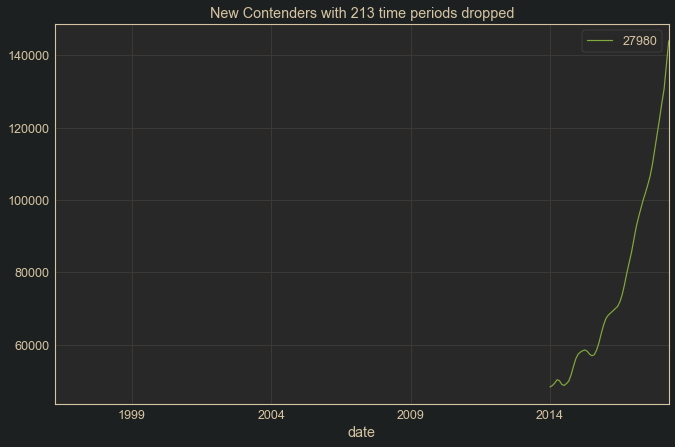

In [70]:
# The dictionary is ready, now to make comparisons on each time window
contenders = {}
for k, v in zip_groups.items():
    to_drop = []
    for key, val, in zip_groups.items():
        if key > k:
            to_drop.append(val)
    to_drop = [item for sublist in to_drop for item in sublist]
    
    lrmeans = log_rets.iloc[k+1:].mean()
    indices = [ind for ind in lrmeans.index if ind not in to_drop]
    fifty_best = lrmeans.loc[indices].sort_values(ascending=False).iloc[:50]
    new_contenders = [x for x in fifty_best.index if x in v]
    new_contenders = fifty_best.loc[new_contenders]
    contenders[k] = {}
    contenders[k]['contenders'] = new_contenders
    contenders[k]['fifty_best'] = fifty_best
    
    if len(new_contenders) > 0:
        display(new_contenders)
        for cont in new_contenders.index:
            grp = groups.get_group(cont)
            grp.set_index('date').value.plot(label=cont)
        plt.title('New Contenders with {} time periods dropped'.format(k))
        plt.legend()
    plt.show()

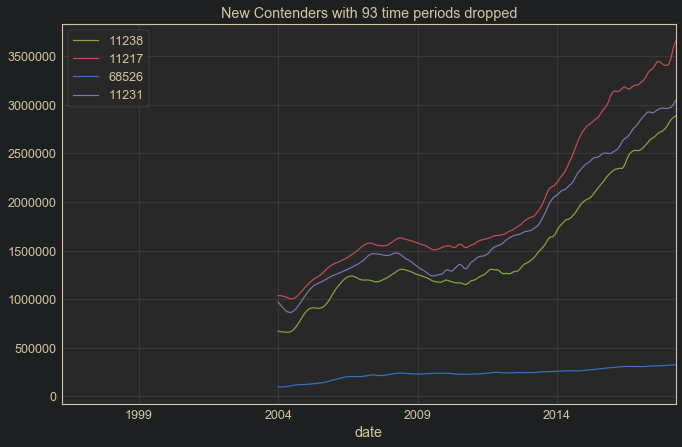

Average mean return of top fifty zip codes for time period: 0.007150373586415396


City State     Metro CountyName  avgReturn
zipcode                                                
11238    New York    NY  New York      Kings   0.008528
11217    New York    NY  New York      Kings   0.007365
68526     Lincoln    NE   Lincoln  Lancaster   0.006950
11231    New York    NY  New York   New York   0.006692

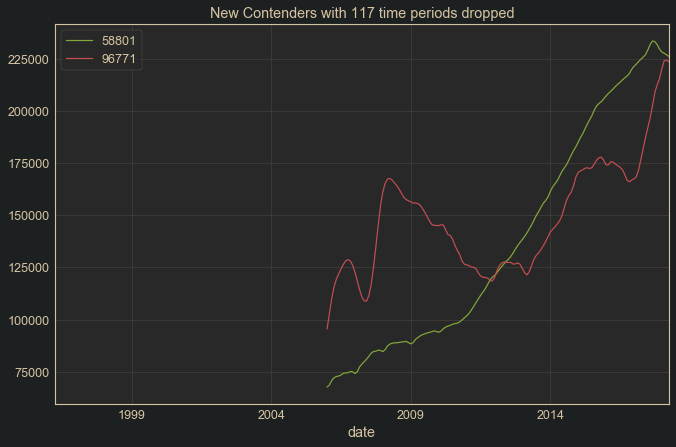

Average mean return of top fifty zip codes for time period: 0.006624902794140936


City State      Metro CountyName  avgReturn
zipcode                                                      
58801        Williston    ND  Williston   Williams   0.008190
96771    Mountain View    HI       Hilo     Hawaii   0.005774

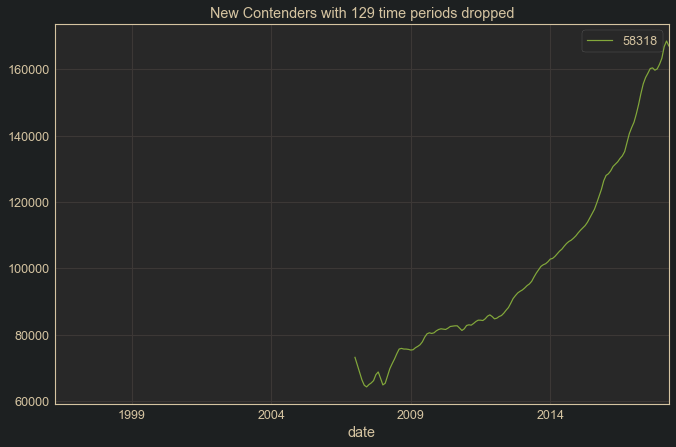

Average mean return of top fifty zip codes for time period: 0.006717214501357673


City State Metro CountyName  avgReturn
zipcode                                             
58318    Bottineau    ND   NaN  Bottineau    0.00611

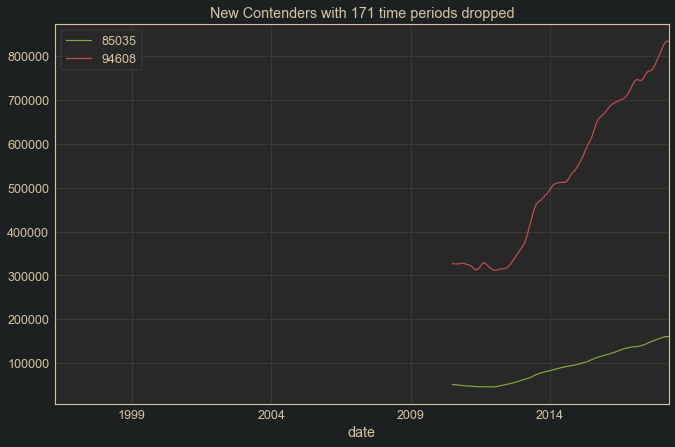

Average mean return of top fifty zip codes for time period: 0.010455729787478472


City State          Metro CountyName  avgReturn
zipcode                                                    
85035    Phoenix    AZ        Phoenix   Maricopa   0.012214
94608    Oakland    CA  San Francisco    Alameda   0.010032

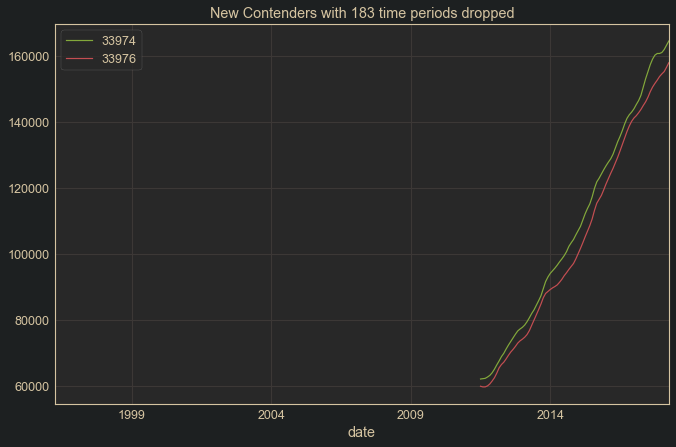

Average mean return of top fifty zip codes for time period: 0.012615718348460394


City State       Metro CountyName  avgReturn
zipcode                                                      
33974    Lehigh Acres    FL  Fort Myers        Lee   0.012062
33976    Lehigh Acres    FL  Fort Myers        Lee   0.012003

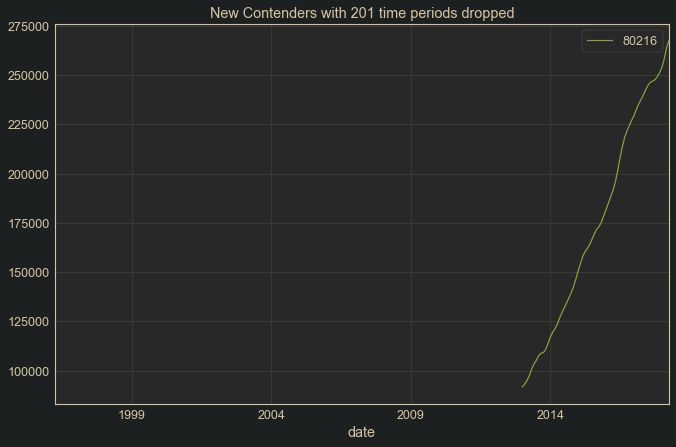

Average mean return of top fifty zip codes for time period: 0.014806659730997236


City State   Metro CountyName  avgReturn
zipcode                                            
80216    Denver    CO  Denver     Denver   0.016964

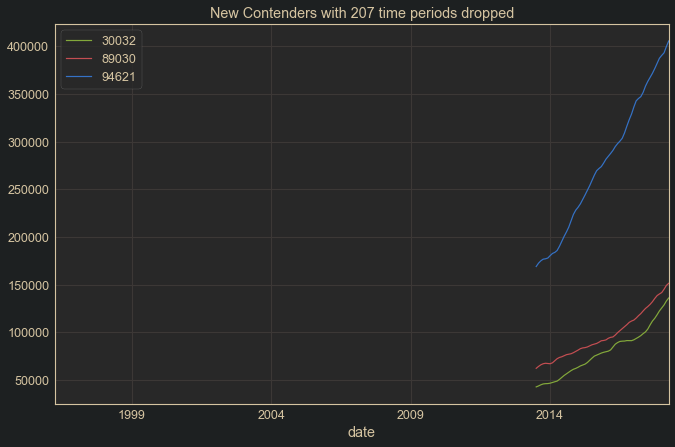

Average mean return of top fifty zip codes for time period: 0.014679695609137068


City State          Metro CountyName  avgReturn
zipcode                                                            
30032     Candler-Mcafee    GA        Atlanta     Dekalb   0.020352
89030    North Las Vegas    NV      Las Vegas      Clark   0.015623
94621            Oakland    CA  San Francisco    Alameda   0.015365

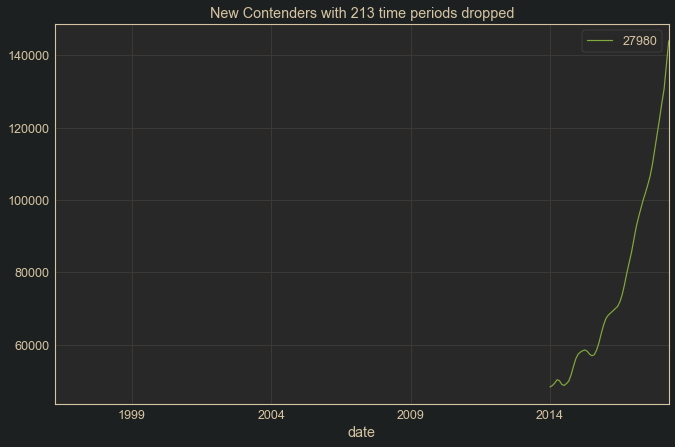

Average mean return of top fifty zip codes for time period: 0.015083719392837886


City State           Metro  CountyName  avgReturn
zipcode                                                       
27980    Hertford    NC  Elizabeth City  Perquimans   0.021365

In [71]:
# We can see some promising contenders, and some to be ignored. I will ignore the 105 period
# drop, because we aren't in the market for $10 million houses
# We will also need to view these contenders in their relations to the other best zip codes
# in the time frames, so I will print the average mean return of the top fifty to see how
# the new contenders compare to the mean value
for k, v in contenders.items():
    if k == 105:
        continue
    if len(v['contenders']) > 0:
        idx = v['contenders'].index
        for cont in idx:
            grp = groups.get_group(cont)
            grp.set_index('date').value.plot(label=cont)
        plt.title('New Contenders with {} time periods dropped'.format(k))
        plt.legend()
        plt.show()
        print('Average mean return of top fifty zip codes for time period: {}'.format(v['fifty_best'].mean()))
        zips_df = df.set_index('zipcode').loc[idx][['City', 
                                                  'State', 
                                                  'Metro', 
                                                  'CountyName']].merge(pd.Series(v['contenders'], 
                                                                                 name='avgReturn'), 
                                                                       left_index=True, 
                                                                       right_on='zipcode')
        display(zips_df)
        #idx = v['fifty_best'].index
        #zips_df = df.set_index('zipcode').loc[idx][['City', 
        #                                          'State', 
        #                                          'Metro', 
        #                                          'CountyName']].merge(pd.Series(v['fifty_best'], 
        #                                                                         name='avgReturn'), 
        #                                                               left_index=True, 
        #                                                               right_on='zipcode')        
        #display(zips_df)
        print('===============================================================================')

#### Notes:
In the first time window we see three NYC zip codes, with expensive properties, so these are out. However, the fourth is Lincoln, Nebraska, which fits our criteria for good real estate investment, as it is in the Midwest, the median price is falling below 500k, and these prices appear to have been resilient during the crash.<br>
<br>
In the second time window we see a volatile zipcode in Hawaii which underperformed the average of the top fifty of this window, but we also see a promising zip code in Williston, North Dakota, which is certainly meeting our criteria for good investment, with rapid recent growth, resilience during the crash, and Midwestern location.<br>
<br>
In the third time window, we see another promising North Dakota zip code, with strong recent growth. This is a much smaller town than the other ND zip code, however, with only a tenth of the population of Williston, so it may not be as good of a candidate for investment.<br>
<br>
In the fourth time window, we see a San Francisco zip code, which is right out. However, the other zip code is Phoenix, AZ, which is promising indeed. The growth rate is high, the Zillow chart shows that rentals are profitable, and it is a populous area with businesses, home to 1.66 million people.<br>
<br>
In the next time window we see two zipcodes from the same town in Florida called Lehigh Acres, which has shown excellent growth. At this point, no commentary on resiliency to the crash can be made, as it is outside the time window.<br>
<br>
The next window has a zipcode from Denver with reasonable prices and a good growth rate. Denver appears pretty low on our chart from earlier, nearby Austin, so it may not be a good choice.
<br>
The next window shows three zip codes with reasonable prices outperforming the mean of the top 50 zip codes over this time period. The San Francisco one can probably be ignored, but the other two are promising. The one near Atlanta, Candler-McCafee has tremendous growth. The other is in Las Vegas, which appeared high on the Zillow Chart, and could be a good prospect.<br>
<br>
The final window shows a town called Hertford, NC, showing explosive growth since 2014, far exceeding the mean of performance of the top 50 zip codes over this time period. This is a small town on the Pariquimans River in eastern NC.

#### Notes so far:
This investigation has given us plently to choose from. In order to narrow down our candidates, I have found a useful metric and related data in [this Zillow Research article](https://www.zillow.com/research/where-rent-covers-mortgage-15624/) called Price to Rent Ratio. This ratio and parts of this article were also referenced in Sam Dogen's Investment Samurai article mentioned earlier. The article talks about the importance of an investor being sure that the amount that they can charge to rent a property is high enough to cover the costs of owning and maintaining the property. Both articles agree that this is most of an issue in larger metros on the West Coast and Northeast US. In some areas, the amount one can charge for rent will not cover the costs of ownership, so an investor needs to make sure that they are not buying in an area where this is a typical problem. But since breaking even with rent isn't as nice as profiting from rent, the ratio can help a keen investor get the most bang for their buck.<br>
<br>
The nationwide average (at the time of the article) of the Price-to-Rent Ratio was 11.4, meaning that it would take 11.4 years of rent to cover the cost of the house. In Sam Dogen's article, he recommended to invest in houses that trade at or below 9.6. Using this information, we should be able to narrow our choices down. It is likely that the more rural town on our list of contenders will not appear in this dataset, but we were hoping to diversify between rural and urban areas, so this should help us pinpoint which cities are most profitable. This is important since an investor with widely spread assets geographically will need to hire property management companies to attend to the maintenance and related issues of landlordship for their properties, which will take a cut. According to [this Zillow article](https://www.zillow.com/rental-manager/resources/hiring-a-property-manager/), a property management company will usually take a cut between 7% and 10% of monthly rent.

In [72]:
# Importing the data
p2r = pd.read_csv('price_to_rent.csv')
p2r.head()

Region Name Region Name (group)  National Average    P2R      Zhvi
0        Yuma, AZ               Other             11.44  12.18  $134,200
1   Yuba City, CA               Other             11.44  14.90  $249,400
2  Youngstown, OH               Other             11.44   8.86   $85,400
3        York, PA               Other             11.44  10.55  $163,600
4      Yakima, WA               Other             11.44  13.51  $181,700

Let's make a concise list of the zip codes that have caught our attention so far:
1. 57110 - Sioux Falls, SD
2. 28762 - Old Fort, NC (Marion)
3. 19125 - Philadelphia, PA
4. 30317 - Atlanta, GA
5. 68526 - Lincoln, NE
6. 58801 - Williston, ND
7. 85035 - Phoenix, AZ
8. 33974 - Lehigh Acres, FL (Fort Myers)
9. 30032 - Candler-Mcafee, GA (Atlanta)
10. 89030 - North Las Vegas, NV (Las Vegas)
11. 27980 - Hertford, NC (Elizabeth City)

In [73]:
# Let's get a dataframe going of our candidates:
selections = [57110, 28762, 19125, 30317, 68526, 58801, 85035, 33974, 30032, 89030, 27980]
selections = df.set_index('zipcode').loc[selections]
selections

City State           Metro    CountyName  1996-04  \
zipcode                                                                 
57110        Sioux Falls    SD     Sioux Falls     Minnehaha  30100.0   
28762           Old Fort    NC          Marion      McDowell  19200.0   
19125       Philadelphia    PA    Philadelphia  Philadelphia  32600.0   
30317            Atlanta    GA         Atlanta        Fulton  51800.0   
68526            Lincoln    NE         Lincoln     Lancaster      NaN   
58801          Williston    ND       Williston      Williams      NaN   
85035            Phoenix    AZ         Phoenix      Maricopa      NaN   
33974       Lehigh Acres    FL      Fort Myers           Lee      NaN   
30032     Candler-Mcafee    GA         Atlanta        Dekalb      NaN   
89030    North Las Vegas    NV       Las Vegas         Clark      NaN   
27980           Hertford    NC  Elizabeth City    Perquimans      NaN   

         1996-05  1996-06  1996-07  1996-08  1996-09  ...  2017-07  2017-08  \
zipcode                                               ...                     
57110    31200.0  32300.0  33400.0  34600.0  35800.0  ...   229500   230900   
28762    19700.0  20100.0  20600.0  21000.0  21500.0  ...   137100   137600   
19125    32700.0  32800.0  32800.0  32900.0  32900.0  ...   247500   249000   
30317    52500.0  53200.0  53900.0  54500.0  55200.0  ...   362500   362500   
68526        NaN      NaN      NaN      NaN      NaN  ...   313600   315000   
58801        NaN      NaN      NaN      NaN      NaN  ...   229200   231800   
85035        NaN      NaN      NaN      NaN      NaN  ...   146100   148800   
33974        NaN      NaN      NaN      NaN      NaN  ...   155400   157500   
30032        NaN      NaN      NaN      NaN      NaN  ...   103300   107700   
89030        NaN      NaN      NaN      NaN      NaN  ...   126900   129200   
27980        NaN      NaN      NaN      NaN      NaN  ...   104200   106600   

         2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
zipcode                                                                  
57110     232200   233500   234000   234700   236000   237700   240800   
28762     138100   138800   139000   139400   140600   141400   142100   
19125     251600   253900   255700   257100   258000   258500   260500   
30317     362300   366000   372400   379200   384900   388400   390400   
68526     315500   315800   316600   318200   319700   321300   323100   
58801     233400   233100   231600   229500   228100   227500   226800   
85035     150800   152500   154600   156800   158600   160200   161000   
33974     159200   160400   160900   160900   161200   162100   163400   
30032     111700   114600   118300   122300   125400   128600   132800   
89030     132000   135400   138400   140100   141600   145100   149100   
27980     109900   114000   118100   122200   126600   130600   137300   

         2018-04  
zipcode           
57110     243900  
28762     143000  
19125     262300  
30317     391600  
68526     324900  
58801     226000  
85035     161000  
33974     164700  
30032     135900  
89030     151300  
27980     143900  

[11 rows x 269 columns]

In [74]:
# Creating a new column in a similar format to the p2r data
selections['cityState'] = selections.Metro + ', ' + selections.State
selections

City State           Metro    CountyName  1996-04  \
zipcode                                                                 
57110        Sioux Falls    SD     Sioux Falls     Minnehaha  30100.0   
28762           Old Fort    NC          Marion      McDowell  19200.0   
19125       Philadelphia    PA    Philadelphia  Philadelphia  32600.0   
30317            Atlanta    GA         Atlanta        Fulton  51800.0   
68526            Lincoln    NE         Lincoln     Lancaster      NaN   
58801          Williston    ND       Williston      Williams      NaN   
85035            Phoenix    AZ         Phoenix      Maricopa      NaN   
33974       Lehigh Acres    FL      Fort Myers           Lee      NaN   
30032     Candler-Mcafee    GA         Atlanta        Dekalb      NaN   
89030    North Las Vegas    NV       Las Vegas         Clark      NaN   
27980           Hertford    NC  Elizabeth City    Perquimans      NaN   

         1996-05  1996-06  1996-07  1996-08  1996-09  ...  2017-08  2017-09  \
zipcode                                               ...                     
57110    31200.0  32300.0  33400.0  34600.0  35800.0  ...   230900   232200   
28762    19700.0  20100.0  20600.0  21000.0  21500.0  ...   137600   138100   
19125    32700.0  32800.0  32800.0  32900.0  32900.0  ...   249000   251600   
30317    52500.0  53200.0  53900.0  54500.0  55200.0  ...   362500   362300   
68526        NaN      NaN      NaN      NaN      NaN  ...   315000   315500   
58801        NaN      NaN      NaN      NaN      NaN  ...   231800   233400   
85035        NaN      NaN      NaN      NaN      NaN  ...   148800   150800   
33974        NaN      NaN      NaN      NaN      NaN  ...   157500   159200   
30032        NaN      NaN      NaN      NaN      NaN  ...   107700   111700   
89030        NaN      NaN      NaN      NaN      NaN  ...   129200   132000   
27980        NaN      NaN      NaN      NaN      NaN  ...   106600   109900   

         2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
zipcode                                                                  
57110     233500   234000   234700   236000   237700   240800   243900   
28762     138800   139000   139400   140600   141400   142100   143000   
19125     253900   255700   257100   258000   258500   260500   262300   
30317     366000   372400   379200   384900   388400   390400   391600   
68526     315800   316600   318200   319700   321300   323100   324900   
58801     233100   231600   229500   228100   227500   226800   226000   
85035     152500   154600   156800   158600   160200   161000   161000   
33974     160400   160900   160900   161200   162100   163400   164700   
30032     114600   118300   122300   125400   128600   132800   135900   
89030     135400   138400   140100   141600   145100   149100   151300   
27980     114000   118100   122200   126600   130600   137300   143900   

                  cityState  
zipcode                      
57110       Sioux Falls, SD  
28762            Marion, NC  
19125      Philadelphia, PA  
30317           Atlanta, GA  
68526           Lincoln, NE  
58801         Williston, ND  
85035           Phoenix, AZ  
33974        Fort Myers, FL  
30032           Atlanta, GA  
89030         Las Vegas, NV  
27980    Elizabeth City, NC  

[11 rows x 270 columns]

In [75]:
# Now to see which of the selection has a corresponding entry in the p2r data
p2r[p2r['Region Name'].isin(selections.cityState)]

Region Name Region Name (group)  National Average    P2R      Zhvi
168       Phoenix, AZ               Other             11.44  14.48  $231,700
169  Philadelphia, PA               Other             11.44  11.20  $215,400
251        Marion, NC               Other             11.44  10.43  $119,600
272       Lincoln, NE               Other             11.44  10.45  $156,400
282     Las Vegas, NV               Other             11.44  14.36  $217,800
390    Fort Myers, FL               Other             11.44  10.80  $222,900
548       Atlanta, GA               Other             11.44  10.93  $175,200

In [76]:
# This has worked, although none of the p2r values of our list of selections actually falls
# below the recommended 9.6. This is likely due to the fact that we originally filtered for zip
# codes with promising captial appreciation rates, and it stands to reason that the highest
# performing zip codes may not have the best p2r ratios. However, many of our selections do have
# p2r ratios which are below the national average, so this is not bad, and could be considered
# a satisfactory result, especially since the article the data was sourced from mentioned that
# the vast majority of american cities had houses which could be rented for a profit, so beating
# the national average of p2r means that you're going to be profiting, and at a better rate than
# the majority of cities in the US.

In [77]:
# A quick check for Denver
p2r[p2r['Region Name'] == 'Denver, CO']

Region Name Region Name (group)  National Average    P2R      Zhvi
433  Denver, CO               Other             11.44  14.65  $359,100

In [78]:
# I'd like to see if I can get p2r info for the selections we missed by finding the closest
# metro that the p2r data contains.
# First to try Sioux Falls
p2r[p2r['Region Name'].str.contains('SD')]

Empty DataFrame
Columns: [Region Name, Region Name (group), National Average, P2R, Zhvi]
Index: []

In [79]:
# It appears no data from South Dakota is available, let's try the closest city
p2r[p2r['Region Name'].str.contains('MN')]

Region Name Region Name (group)  National Average    P2R  \
8                 Winona, MN               Other             11.44  10.29   
12               Willmar, MN               Other             11.44  11.31   
134            Rochester, MN               Other             11.44  11.36   
182             Owatonna, MN               Other             11.44  10.72   
235  Minneapolis-St Paul, MN               Other             11.44  12.63   
255              Mankato, MN               Other             11.44  11.12   
401            Faribault, MN               Other             11.44  12.41   
426               Duluth, MN               Other             11.44  10.31   
544               Austin, MN               Other             11.44   8.24   

         Zhvi  
8    $143,300  
12   $163,000  
134  $183,900  
182  $156,900  
235  $239,700  
255  $178,700  
401  $204,900  
426  $136,300  
544   $96,200

In [80]:
# Sioux Falls is close to Austin, MN, which is closer to the metro than Sioux Falls, so it can
# be assumed that the p2r is similar between the two. 8.24 is a good result.
# Now let's look for Williston, ND proxies
p2r[p2r['Region Name'].str.contains('ND')]

Region Name Region Name (group)  National Average    P2R      Zhvi
234        Minot, ND               Other             11.44  12.57  $203,900
321    Jamestown, ND               Other             11.44  11.29  $163,300
372  Grand Forks, ND               Other             11.44  10.43  $149,500
402        Fargo, ND               Other             11.44  12.71  $205,300
430    Dickinson, ND               Other             11.44  12.36  $201,000
517     Bismarck, ND               Other             11.44  13.66  $242,400

In [81]:
# It looks as though renters in North Dakota aren't willing to pay very much, the closest
# on the above list to Williston is Minot, which has a high p2r. Not ideal.
# The last one to try for is Hertford/Elizabeth City
p2r[p2r['Region Name'].str.contains('NC')]

Region Name Region Name (group)  National Average    P2R      Zhvi
7    Winston-Salem, NC               Other             11.44  10.52  $129,700
10          Wilson, NC               Other             11.44   9.94  $123,500
11      Wilmington, NC               Other             11.44  12.69  $208,600
111        Sanford, NC               Other             11.44  10.18  $121,400
131    Rocky Mount, NC               Other             11.44   8.65   $82,000
147        Raleigh, NC               Other             11.44  12.80  $221,600
180         Oxford, NC               Other             11.44  10.89  $145,700
226  Morehead City, NC               Other             11.44  15.79  $246,300
251         Marion, NC               Other             11.44  10.43  $119,600
322   Jacksonville, NC               Other             11.44  11.97  $129,400
347        Hickory, NC               Other             11.44   9.69  $108,600
349      Henderson, NC               Other             11.44   8.48   $91,500
362     Greensboro, NC               Other             11.44  10.54  $126,300
399   Fayetteville, NC               Other             11.44  11.87  $126,600
422         Durham, NC               Other             11.44  12.39  $208,000
425           Dunn, NC               Other             11.44  11.80  $157,200
481      Charlotte, NC               Other             11.44  11.30  $169,500
498     Burlington, NC               Other             11.44  11.44  $133,800
552      Asheville, NC               Other             11.44  13.79  $216,600
566      Albemarle, NC               Other             11.44  10.46  $129,600

In [82]:
# The closest on the above list is Rocky Mount, with 8.65, which is a good result.
# A Google search shows that 51.21% of households in Hertford are rentals.

#### Notes so far:
So far we have narrowed down prospect by a number of criteria. For zip codes which we had enough data, we checked for resilience to the market crash. We have selected based on overall growth, and then we were able to find which zip codes were part of metros with acceptable Price-to-Rent ratios. We should also take into account whether people actually rent in these places, so I will try and add that to a convenient dataframe now. It would also be helpful to compare our selections average returns over the same time period, to see if they are all beating the average growth in the last few years.

In [83]:
# From our selections, we will remove those with p2r ratios above the national average, this
# included Las Vegas, Phoenix, and our North Dakota selection of Williston
select2 = selections.drop(index=[85035, 58801, 89030])
select2

City State           Metro    CountyName  1996-04  1996-05  \
zipcode                                                                         
57110       Sioux Falls    SD     Sioux Falls     Minnehaha  30100.0  31200.0   
28762          Old Fort    NC          Marion      McDowell  19200.0  19700.0   
19125      Philadelphia    PA    Philadelphia  Philadelphia  32600.0  32700.0   
30317           Atlanta    GA         Atlanta        Fulton  51800.0  52500.0   
68526           Lincoln    NE         Lincoln     Lancaster      NaN      NaN   
33974      Lehigh Acres    FL      Fort Myers           Lee      NaN      NaN   
30032    Candler-Mcafee    GA         Atlanta        Dekalb      NaN      NaN   
27980          Hertford    NC  Elizabeth City    Perquimans      NaN      NaN   

         1996-06  1996-07  1996-08  1996-09  ...  2017-08  2017-09  2017-10  \
zipcode                                      ...                              
57110    32300.0  33400.0  34600.0  35800.0  ...   230900   232200   233500   
28762    20100.0  20600.0  21000.0  21500.0  ...   137600   138100   138800   
19125    32800.0  32800.0  32900.0  32900.0  ...   249000   251600   253900   
30317    53200.0  53900.0  54500.0  55200.0  ...   362500   362300   366000   
68526        NaN      NaN      NaN      NaN  ...   315000   315500   315800   
33974        NaN      NaN      NaN      NaN  ...   157500   159200   160400   
30032        NaN      NaN      NaN      NaN  ...   107700   111700   114600   
27980        NaN      NaN      NaN      NaN  ...   106600   109900   114000   

         2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  \
zipcode                                                         
57110     234000   234700   236000   237700   240800   243900   
28762     139000   139400   140600   141400   142100   143000   
19125     255700   257100   258000   258500   260500   262300   
30317     372400   379200   384900   388400   390400   391600   
68526     316600   318200   319700   321300   323100   324900   
33974     160900   160900   161200   162100   163400   164700   
30032     118300   122300   125400   128600   132800   135900   
27980     118100   122200   126600   130600   137300   143900   

                  cityState  
zipcode                      
57110       Sioux Falls, SD  
28762            Marion, NC  
19125      Philadelphia, PA  
30317           Atlanta, GA  
68526           Lincoln, NE  
33974        Fort Myers, FL  
30032           Atlanta, GA  
27980    Elizabeth City, NC  

[8 rows x 270 columns]

In [84]:
# Now let's make a summary dataframe with comparative recent growth rates, and p2r info and
# renter info
select_summary = select2[['City', 'State', 'Metro', 'CountyName', 'cityState']]
mean_rtn = pd.Series(name='avg_return')
for zipcode in select2.index:
    grpmean = log_rets.iloc[214:][zipcode].mean()
    mean_rtn.loc[zipcode] = grpmean
select_summary = select_summary.merge(mean_rtn, left_index=True, right_index=True)
select_summary

City State           Metro    CountyName           cityState  \
57110     Sioux Falls    SD     Sioux Falls     Minnehaha     Sioux Falls, SD   
28762        Old Fort    NC          Marion      McDowell          Marion, NC   
19125    Philadelphia    PA    Philadelphia  Philadelphia    Philadelphia, PA   
30317         Atlanta    GA         Atlanta        Fulton         Atlanta, GA   
68526         Lincoln    NE         Lincoln     Lancaster         Lincoln, NE   
33974    Lehigh Acres    FL      Fort Myers           Lee      Fort Myers, FL   
30032  Candler-Mcafee    GA         Atlanta        Dekalb         Atlanta, GA   
27980        Hertford    NC  Elizabeth City    Perquimans  Elizabeth City, NC   

       avg_return  
57110    0.004702  
28762    0.004069  
19125    0.011195  
30317    0.012835  
68526    0.004528  
33974    0.010976  
30032    0.021029  
27980    0.021365

In [85]:
# One zip code I ignored earlier was Charleston, SC. Let's see what the p2r is here
p2r[p2r['Region Name'].str.contains('SC')]

Region Name Region Name (group)  National Average    P2R  \
69               Sumter, SC               Other             11.44   9.42   
89          Spartanburg, SC               Other             11.44   8.92   
100              Seneca, SC               Other             11.44  12.52   
186          Orangeburg, SC               Other             11.44   7.79   
217        Myrtle Beach, SC               Other             11.44  11.07   
344  Hilton Head Island, SC               Other             11.44  12.28   
360          Greenville, SC               Other             11.44  10.25   
376          Georgetown, SC               Other             11.44  12.11   
394            Florence, SC               Other             11.44   8.59   
463            Columbia, SC               Other             11.44   9.39   

         Zhvi  
69    $87,900  
89   $118,900  
100  $143,400  
186   $83,200  
217  $166,500  
344  $276,800  
360  $150,700  
376  $213,800  
394  $102,200  
463  $124,900

In [86]:
# Charleston is closest to Columnbia, with a nice p2r ratio. Let's add Charleston to the list
charleston = df.set_index('zipcode').loc[[29403],['City', 'State', 'Metro', 'CountyName']]
charleston['avg_return'] = log_rets.iloc[214:][29403].mean()
charleston

City State       Metro  CountyName  avg_return
zipcode                                                      
29403    Charleston    SC  Charleston  Charleston    0.011332

In [87]:
select_summary = pd.concat([select_summary, charleston])
select_summary

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


City    CountyName           Metro State  avg_return  \
57110     Sioux Falls     Minnehaha     Sioux Falls    SD    0.004702   
28762        Old Fort      McDowell          Marion    NC    0.004069   
19125    Philadelphia  Philadelphia    Philadelphia    PA    0.011195   
30317         Atlanta        Fulton         Atlanta    GA    0.012835   
68526         Lincoln     Lancaster         Lincoln    NE    0.004528   
33974    Lehigh Acres           Lee      Fort Myers    FL    0.010976   
30032  Candler-Mcafee        Dekalb         Atlanta    GA    0.021029   
27980        Hertford    Perquimans  Elizabeth City    NC    0.021365   
29403      Charleston    Charleston      Charleston    SC    0.011332   

                cityState  
57110     Sioux Falls, SD  
28762          Marion, NC  
19125    Philadelphia, PA  
30317         Atlanta, GA  
68526         Lincoln, NE  
33974      Fort Myers, FL  
30032         Atlanta, GA  
27980  Elizabeth City, NC  
29403                 NaN

In [88]:
# National average of monthly returns
print("National average of monthly returns over shared time window:")
log_rets.iloc[214:].mean().mean()

National average of monthly returns over shared time window:


0.004622523927970145

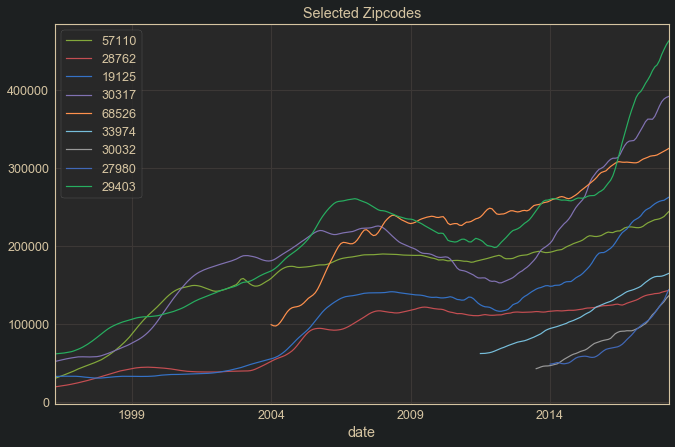

In [89]:
for zipcode in select_summary.index:
    grp = groups.get_group(zipcode)
    grp.set_index('date').value.plot(label=zipcode)
plt.title('Selected Zipcodes')
plt.legend();

#### Notes:
Viewing our selections together, it looks like Old Fort may not be growing as fast as we would like, and it is a tiny town, with the only real advantage it has being proximity to Asheville, NC.<br>
<br>
Some Google searching reveals that the Atlanta and Candler-Mcafee zip codes are directly adjacent to each other, with the latter being the next thing outward from downtown Atlanta. A look at [this site](http://www.city-data.com/zips/30317.html) informs us that 30317 is a nicer, richer area, while 30032 is a poorer area, but with a nice growth rate over the past few years. [Bestplaces.net](https://www.bestplaces.net/crime/zip-code/georgia/candler-mcafee/30032) exposes the fact that there is a crime problem in 30032, and the other site showed that it had quite a number of registered sex offenders living in it, so this may not be the best place to invest, despite the recent growth rate. Growth rates have a tendency to look very high when assests are not very valuable to begin with, also.<br>
<br>
Lincoln, NE is a great pick. It is growing, reasonably priced, and was stable through the crash. 19125 in Philadelphia also seems like a good pick, which shows recent growth and resilience through the crash. Both of these picks have below average Price-to-Rent ratios.<br>
<br>
Sioux Falls I believe is still a good pick, despite it's relatively unexciting growth rate. It is reasonably priced, showed resilience in the crash, and has a great Price-to-Rent ratio around its area, making it a stable, profitable pick.<br>
<br>
The 33974 in Lehigh Acres in FL looks like a good pick. It has shown stable, constant growth, and is in an area with a good Price-to-Rent ratio.<br>
<br>
Charleston has an exciting recent growth rate, but its current prices are quite high, which concerns me in thinking they may not be as profitable for renting, and that the growth may taper off.<br>
<br>
I believe that the 30317 zip code near downtown Atlanta would make a good addition to the portfolio. It would be the most expensive zip code to invest in, but it is close to downtown in a thriving city with a Price-to-Rent ratio below the national average. The site linked to earlier revealed that this is a relatively well-to-do area in ATL, and one can expect the property value to appreciate.

### Conclusions:
From this analysis of various zip codes in their relative performances in returns over various time frames, as well as their locations, their Price-to-Rent ratios, and other availiable information, we have narrowed down our interest to 5 zip codes worthy of investment:

1. 57110 - Sioux Falls, SD
2. 19125 - Philadelphia, PA
3. 30317 - Atlanta, GA
4. 68526 - Lincoln, NE
5. 33974 - Lehigh Acres, FL
<br><br>
I will make a dataframe of all pertinent information.

In [90]:
best_5 = [57110, 19125, 30317, 68526, 33974]
best_5 = select_summary.loc[best_5]
idx = best_5.index
best_5 = best_5.merge(p2r, left_index=False, how='left', left_on='cityState', right_on='Region Name')
best_5.index = idx
best_5

City    CountyName         Metro State  avg_return  \
57110   Sioux Falls     Minnehaha   Sioux Falls    SD    0.004702   
19125  Philadelphia  Philadelphia  Philadelphia    PA    0.011195   
30317       Atlanta        Fulton       Atlanta    GA    0.012835   
68526       Lincoln     Lancaster       Lincoln    NE    0.004528   
33974  Lehigh Acres           Lee    Fort Myers    FL    0.010976   

              cityState       Region Name Region Name (group)  \
57110   Sioux Falls, SD               NaN                 NaN   
19125  Philadelphia, PA  Philadelphia, PA               Other   
30317       Atlanta, GA       Atlanta, GA               Other   
68526       Lincoln, NE       Lincoln, NE               Other   
33974    Fort Myers, FL    Fort Myers, FL               Other   

       National Average    P2R      Zhvi  
57110               NaN    NaN       NaN  
19125             11.44  11.20  $215,400  
30317             11.44  10.93  $175,200  
68526             11.44  10.45  $156,400  
33974             11.44  10.80  $222,900

A look at [this Zillow page](https://www.zillow.com/sioux-falls-sd/home-values/) can provide us with the missing data for our table. Since our p2r data, including the national average used for comparisons, comes from a Zillow article written in June 2017, it is appropriate to fill the table using values from this time, for accurate comparison.

In [91]:
sioux_Zhvi = '$187,000'
sioux_p2r = 187000.0 / (1278 * 12)
sioux_na = 11.44
best_5.loc[57110, ['Zhvi','National Average', 'P2R']] = [sioux_Zhvi, sioux_na, sioux_p2r]
best_5

City    CountyName         Metro State  avg_return  \
57110   Sioux Falls     Minnehaha   Sioux Falls    SD    0.004702   
19125  Philadelphia  Philadelphia  Philadelphia    PA    0.011195   
30317       Atlanta        Fulton       Atlanta    GA    0.012835   
68526       Lincoln     Lancaster       Lincoln    NE    0.004528   
33974  Lehigh Acres           Lee    Fort Myers    FL    0.010976   

              cityState       Region Name Region Name (group)  \
57110   Sioux Falls, SD               NaN                 NaN   
19125  Philadelphia, PA  Philadelphia, PA               Other   
30317       Atlanta, GA       Atlanta, GA               Other   
68526       Lincoln, NE       Lincoln, NE               Other   
33974    Fort Myers, FL    Fort Myers, FL               Other   

       National Average        P2R      Zhvi  
57110             11.44  12.193532  $187,000  
19125             11.44  11.200000  $215,400  
30317             11.44  10.930000  $175,200  
68526             11.44  10.450000  $156,400  
33974             11.44  10.800000  $222,900

In [92]:
best_5.drop(columns=['avg_return', 'cityState','Region Name', 'Region Name (group)', 'Zhvi'])

City    CountyName         Metro State  National Average  \
57110   Sioux Falls     Minnehaha   Sioux Falls    SD             11.44   
19125  Philadelphia  Philadelphia  Philadelphia    PA             11.44   
30317       Atlanta        Fulton       Atlanta    GA             11.44   
68526       Lincoln     Lancaster       Lincoln    NE             11.44   
33974  Lehigh Acres           Lee    Fort Myers    FL             11.44   

             P2R  
57110  12.193532  
19125  11.200000  
30317  10.930000  
68526  10.450000  
33974  10.800000

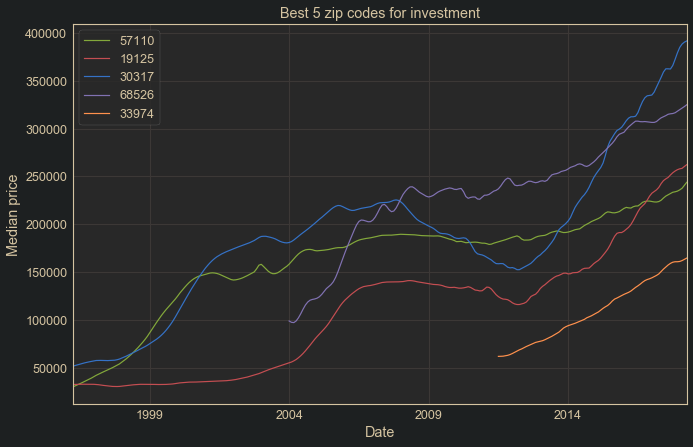

In [93]:
for zipcode in best_5.index:
    grp = groups.get_group(zipcode).set_index('date')
    grp.value.plot(label=zipcode)
plt.legend()
plt.title('Best 5 zip codes for investment')
plt.ylabel('Median price')
plt.xlabel('Date')
plt.show()

## Looking at the whole real estate market within the data
Since there are so many individual zipcodes, it will be useful to do some investigation with a more broad view by taking the average of the median sale prices of all the zipcodes for each month. This will give us an overall view of what generally happened with the market over the time period.

Median for 1996-04: 99500.0
Mean for 1996-04: 118299.12306343175
Normality Test Results for ['1996-04']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-04 
 Statistic 
 1.0 
 0.669048 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-04 
 704.744235 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-04 
 
 
 
 
 Statistic 
 3.184048e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.186575e+00 
 
 
 Kurtosis 
 2.387458e+02

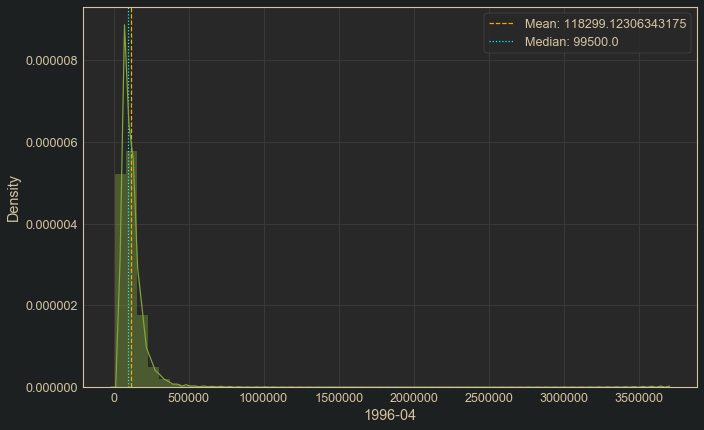

Median for 1996-05: 99500.0
Mean for 1996-05: 118419.0441391406
Normality Test Results for ['1996-05']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-05 
 Statistic 
 1.0 
 0.667243 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-05 
 709.007375 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-05 
 
 
 
 
 Statistic 
 3.321174e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.277905e+00 
 
 
 Kurtosis 
 2.437801e+02

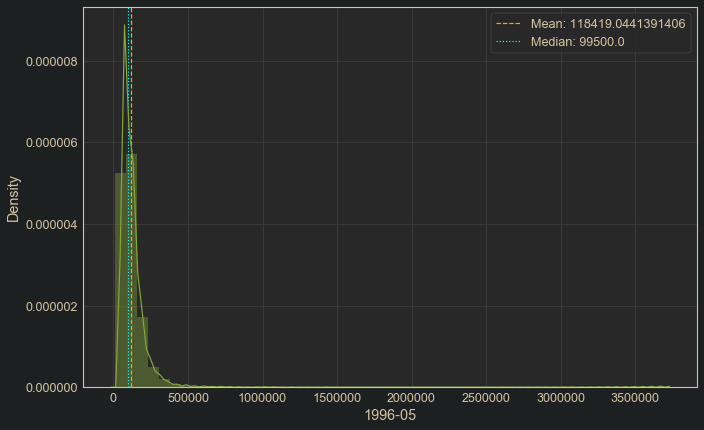

Median for 1996-06: 99700.0
Mean for 1996-06: 118537.42326805028
Normality Test Results for ['1996-06']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-06 
 Statistic 
 1.0 
 0.665485 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-06 
 713.330173 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-06 
 
 
 
 
 Statistic 
 3.449232e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.362241e+00 
 
 
 Kurtosis 
 2.483884e+02

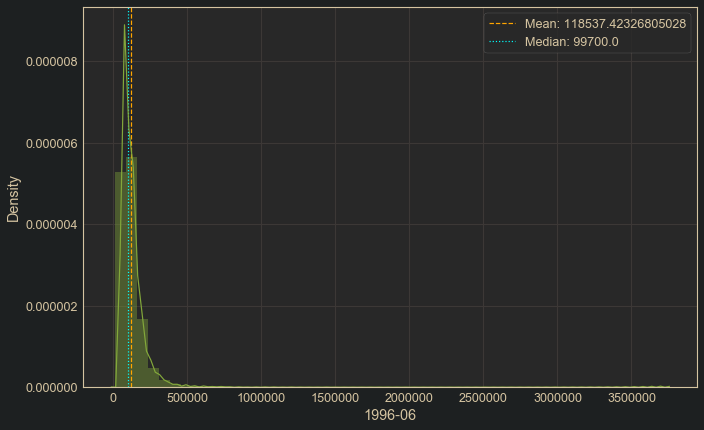

Median for 1996-07: 99700.0
Mean for 1996-07: 118653.06927798889
Normality Test Results for ['1996-07']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-07 
 Statistic 
 1.0 
 0.66371 
 
 
 p-value 
 0.0 
 0.00000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-07 
 717.804874 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-07 
 
 
 
 
 Statistic 
 3.577506e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.445455e+00 
 
 
 Kurtosis 
 2.529192e+02

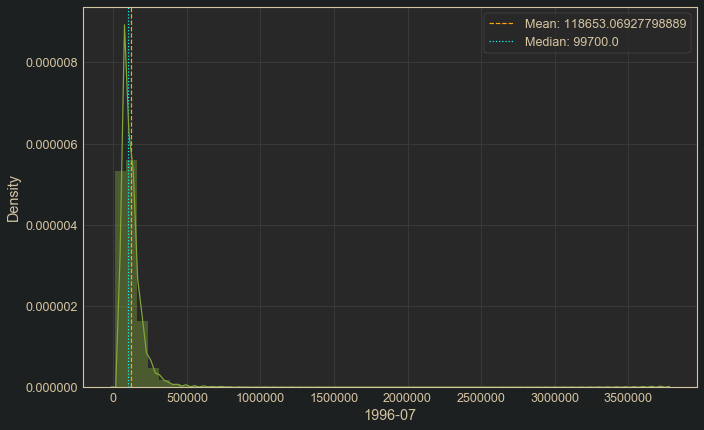

Median for 1996-08: 99800.0
Mean for 1996-08: 118780.25431160479
Normality Test Results for ['1996-08']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-08 
 Statistic 
 1.0 
 0.661852 
 
 
 p-value 
 0.0 
 0.000000 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-08 
 722.401212 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-08 
 
 
 
 
 Statistic 
 3.718596e+07 
 
 
 p-value 
 0.000000e+00 
 
 
 Skew 
 8.534637e+00 
 
 
 Kurtosis 
 2.578099e+02

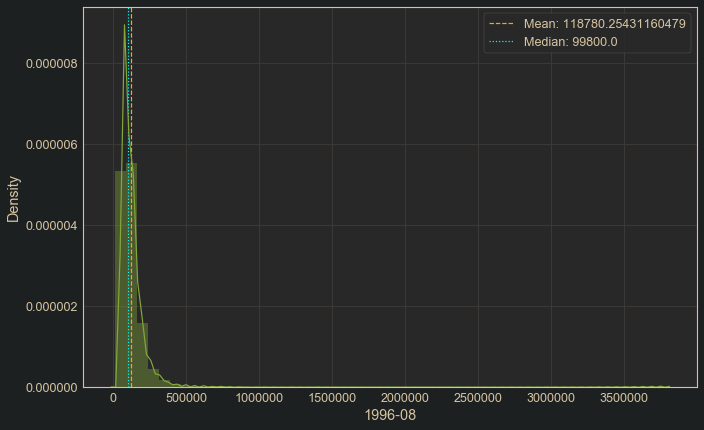

In [94]:
# Checking to see if mean is a reliable statistic:
datezips = df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName'])
for i in range(5):
    subset = datezips.iloc[:, i].dropna()
    fig, ax = plt.subplots()
    ax.axvline(subset.mean(), ls='--', c='orange', label='Mean: {}'.format(subset.mean()))
    ax.axvline(subset.median(), ls=':', c='cyan', label='Median: {}'.format(subset.median()))
    sns.distplot(subset)
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Median for 1996-04: 11.507912923146684
Mean for 1996-04: 11.514263656083454
Normality Test Results for ['1996-04']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-04 
 Statistic 
 1.0 
 9.964508e-01 
 
 
 p-value 
 0.0 
 1.173114e-17 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-04 
 5.471796 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-04 
 
 
 
 
 Statistic 
 2.592146e+02 
 
 
 p-value 
 5.155377e-57 
 
 
 Skew 
 1.697598e-01 
 
 
 Kurtosis 
 3.582543e+00

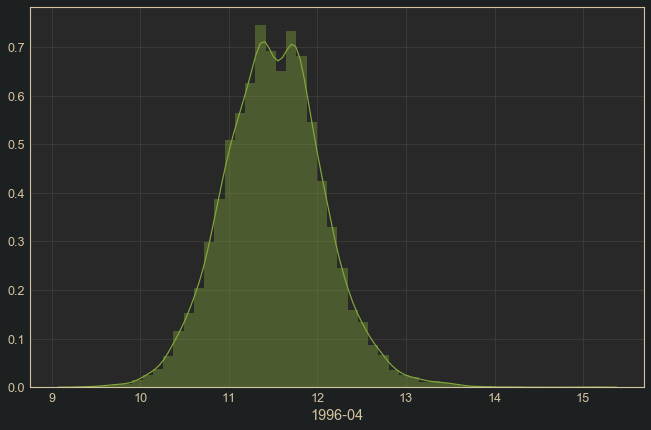

Median for 1996-05: 11.507912923146684
Mean for 1996-05: 11.515620114910819
Normality Test Results for ['1996-05']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-05 
 Statistic 
 1.0 
 9.963446e-01 
 
 
 p-value 
 0.0 
 5.902393e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-05 
 5.646196 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-05 
 
 
 
 
 Statistic 
 2.680339e+02 
 
 
 p-value 
 6.268676e-59 
 
 
 Skew 
 1.748670e-01 
 
 
 Kurtosis 
 3.589732e+00

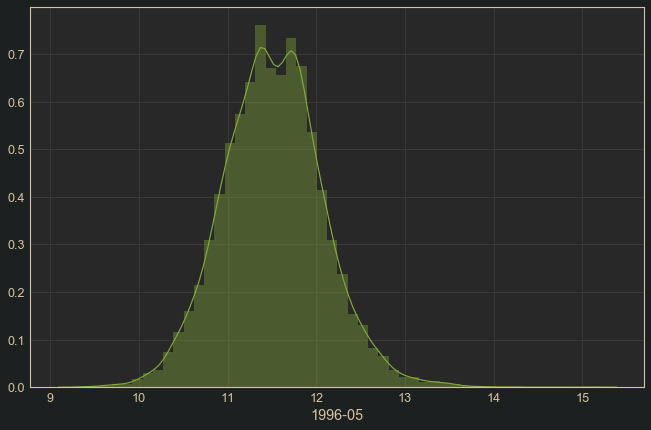

Median for 1996-06: 11.50992095594993
Mean for 1996-06: 11.516948575182408
Normality Test Results for ['1996-06']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-06 
 Statistic 
 1.0 
 9.962552e-01 
 
 
 p-value 
 0.0 
 3.346901e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-06 
 5.833936 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-06 
 
 
 
 
 Statistic 
 2.773738e+02 
 
 
 p-value 
 5.875499e-61 
 
 
 Skew 
 1.800722e-01 
 
 
 Kurtosis 
 3.597306e+00

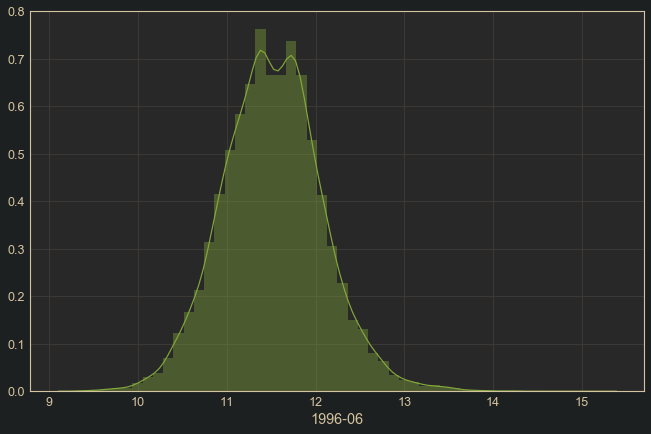

Median for 1996-07: 11.50992095594993
Mean for 1996-07: 11.518235757662946
Normality Test Results for ['1996-07']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-07 
 Statistic 
 1.0 
 9.961358e-01 
 
 
 p-value 
 0.0 
 1.591792e-18 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-07 
 6.034485 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-07 
 
 
 
 
 Statistic 
 2.870832e+02 
 
 
 p-value 
 4.577968e-63 
 
 
 Skew 
 1.854644e-01 
 
 
 Kurtosis 
 3.604913e+00

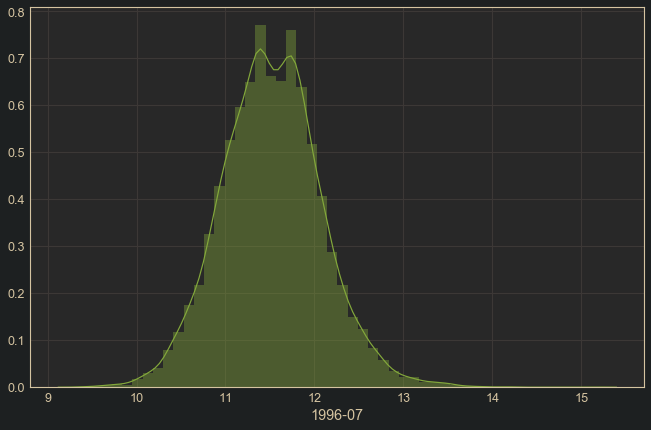

Median for 1996-08: 11.510923462299555
Mean for 1996-08: 11.519575746755715
Normality Test Results for ['1996-08']:
-------------------------------------------------------------------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


K-S and Shapiro-Wilk: 
 
 
 
 
 K-S 
 Shapiro-Wilk 
 
 
 
 
 1996-08 
 Statistic 
 1.0 
 9.960376e-01 
 
 
 p-value 
 0.0 
 8.740750e-19 
 
 
 Anderson-Darling: 
 
 
 
 statistic 
 critical 
 
 
 
 
 1996-08 
 6.244039 
 0.787 
 
 
 Jarque-Bera: 
 
 
 
 1996-08 
 
 
 
 
 Statistic 
 2.970940e+02 
 
 
 p-value 
 3.067993e-65 
 
 
 Skew 
 1.905442e-01 
 
 
 Kurtosis 
 3.613055e+00

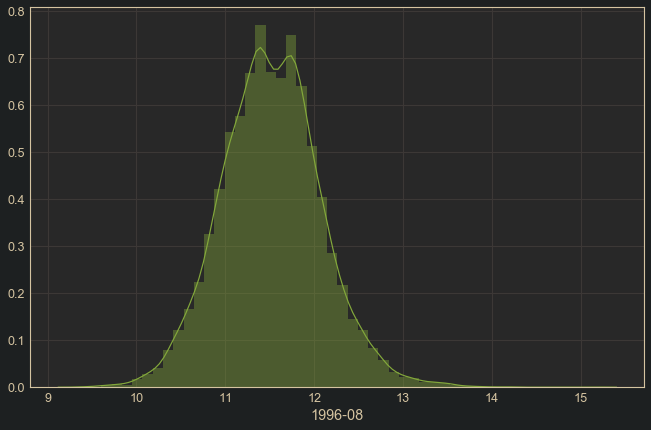

In [95]:
# We can see the prices among the zipcodes for each month are heavily positively skewed,
# log transformations may help this, but it may be more appropriate to use median values.
# Looking at the effect of log transformations:
for i in range(5):
    subset = np.log(datezips.iloc[:, i])
    sns.distplot(subset.dropna())
    print("Median for {}: {}".format(subset.name, subset.median()))
    print("Mean for {}: {}".format(subset.name, subset.mean()))
    mf.check_normality(subset, [subset.name])
    plt.show()

In [96]:
# It looks as though the log transformations have made the prices for each zip code
# per month much more normal. The tests are still rejecting the null-hypothesis of normality,
# but as the warnings above make clear, this may be (and probably is) due to the very large
# sample size of 14k+ zip codes. Looking at the median and means from this, we can see that
# they are all very similar, meaning the distribution is centered, also indicated by the
# relatively low skew. Since I will ultimately be modeling log returns, which are differenced
# log values of the sales, it would be appropriate to use the median prices rather than the
# log prices, so that we are still dealing with price data before the log returns are taken.
# However, see the following note.

### Important Note:
Although it is common practice to use median, rather than mean as a robust statistic for heavily skewed distributions because this prevents the large outliers from having too large of an effect on measures of central tendency, it turns out for this project that approach is not as effective. After performing ARIMA-GARCH modeling on both the medians and means in R, it was the means that actually gave more insight into the markets. This may be because the median prices are reflecting the movements in price of the vast majority of cheaper homes, but that the movements of the prices of more expensive homes are important to consider when discussing the housing market as a whole.<br>
<br>
To demonstrate this, below is a graph that plots the conditional standard deviation of an ARIMA-GARCH model fit on the log returns of mean prices of all zipcodes over time. Notice that the conditional volatility spikes before major trend reversals:
![ARIMA-GARCH using log returns of means](images/means_cond_SD.png)<br>
<br>
Now, let's look at a similar graph from a model produced from the log returns of the median prices of all zipcodes over time:
![ARIMA-GARCH using log returns of means](images/medians_cond_SD.png)<br>
<br>
We can see that the model using the means was able to generate a spike in conditional volatility preceding the housing crash, meaning that giving the extra weight to the movements of zip codes with more expensive houses actually generated better insight into the movement of the markets.<br>
<br>
Having established this, I will continue to look at the market in terms of means, rather than medians, in this notebook.

In [97]:
# Getting a series of means for each month
means = df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName']).mean()
means

1996-04    118299.123063
1996-05    118419.044139
1996-06    118537.423268
1996-07    118653.069278
1996-08    118780.254312
               ...      
2017-12    281095.320247
2018-01    282657.060382
2018-02    284368.688447
2018-03    286511.376757
2018-04    288039.944305
Length: 265, dtype: float64

In [98]:
# Making a second series which omits zip codes that had missing data:
means2 = df.set_index('zipcode').drop(columns=['City', 'State', 'Metro', 'CountyName'],
                                      index=counts.keys()
                                     ).mean()
means2

1996-04    118299.123063
1996-05    118419.044139
1996-06    118537.423268
1996-07    118653.069278
1996-08    118780.254312
               ...      
2017-12    286596.346098
2018-01    288225.876937
2018-02    290006.767027
2018-03    292255.152002
2018-04    293867.553347
Length: 265, dtype: float64

In [99]:
# Setting index to datetime format and checking result
means.index = pd.to_datetime(means.index, format='%Y-%m')
means2.index = pd.to_datetime(means2.index, format='%Y-%m')
means.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [100]:
# Checking for any null values
print("Number of missing values:", means.isna().sum())

Number of missing values: 0


In [101]:
means = pd.DataFrame(means)
means.columns = ['mean price']
means.head()

mean price
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312

In [102]:
means2 = pd.DataFrame(means2)
means2.columns = ['mean price']
means2.head()

mean price
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312

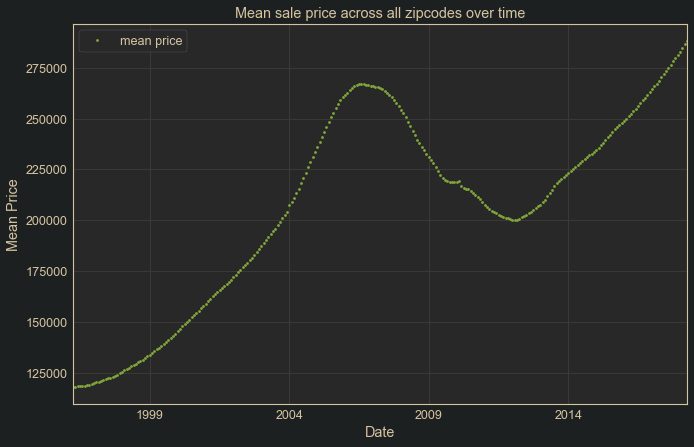

In [103]:
means.plot(style='.b', figsize=(11,7))
plt.title("Mean sale price across all zipcodes over time")
plt.xlabel("Date")
plt.ylabel("Mean Price");

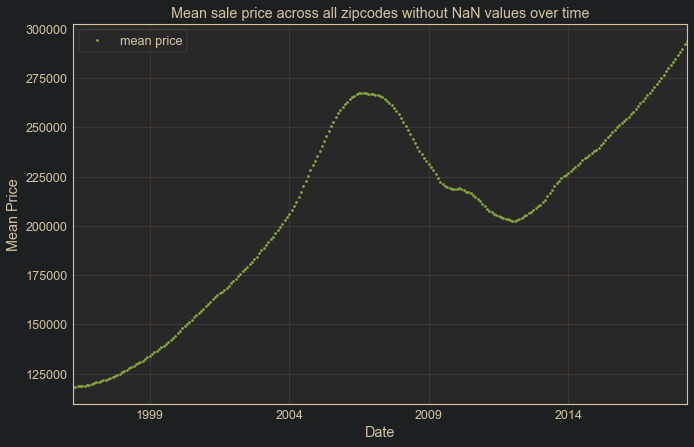

In [104]:
means2.plot(style='.b', figsize=(11,7))
plt.title("Mean sale price across all zipcodes without NaN values over time")
plt.xlabel("Date")
plt.ylabel("Mean Price");

Above we can see that the curves generated by the full dataset and the dataset without the zipcodes containing NaN values are nearly identical, so there does not seem to be much of an impact including the zipcodes with missing data in the means, but this will have to be verified. We can also see no clear intra-year seasonality, but we definitely do see a pattern. It is a reminder that the housing market crashed in the [Subprime Mortgage Crisis](https://en.wikipedia.org/wiki/Subprime_mortgage_crisis) between 2007 and 2010, due to too many subprime mortgages being written out by banks (which they then sold on the securities market), many of which were ultimately foreclosed on. After the dip, we see another period of price inflation, but can we expect to see another "bubble pop" in another 5 years or so? That would have to consider whether the circumstances that led to the 2008 crash were truly unique, or whether there is a cyclic period of deflation that is known to happen even without questionable banking practices occuring in a widespread fashion. More historical data would be helpful to look for such a recurring trend, but is not available in the dataset. Another important consideration is that the data only goes through April of 2018, and that it is currently the end of July 2020, so the pattern may already be changing, if only we had more data to show it.<br>
<br>
Turning to outside research, an <a href='https://www.investopedia.com/investing/next-housing-recession-2020-predicts-zillow/'>article</a> posted in investopedia.com on October 2, 2019, states that researchers at Zillow (the same company that provided the data being used) predicted the next housing recession would manifest itself in 2020, though not for the same reasons as the 2008 crash. Their concerns were instead focused on rising federal interest rates, which would lead to mortgages being more expensive for potential homebuyers, potentially driving them out of the market. The article mentioned that very low unemployment, steady economic growth, and limited housing supply were overshadowing those concerns at the time of the research.<br>
<br>
There are some important things to mention in response to this. First is that around the time the article was written, the fed began to reduce interest rates. Then, in 2020, the Covid-19 pandemic struck and the federal interest rates plummeted to 0.25%, whereas they had been close to 2% when the article was published. This can be seen in the chart below:

<u>Historic Fed Interest Rates:</u>
![Historic Fed Interest Rates](images/fed_rates_chart.png)

This would mean that interest rates will likely not be the leading factor in a housing market recession, if it were to happen this year. Instead, vast unemployment and financial hardship due to the virus will be likely to drive housing prices down. Thus, though the reasoning may be different, it is not unlikely to see a declining housing market in 2020. This is another good reason to determine the zipcodes which were most resilient during the last downturn.<br>
<br>
A more recent <a href=https://www.redfin.com/blog/charting-coronavirus-housing-market-trends/>article</a> posted on Redfin.com corroborates the theory of another downturn occurring due to the pandemic. It shows that year-on-year price growth has indeed stagnated amidst the Covid-19 pandemic. The article mentions that lagged competition has given buyers more room to negotiate better prices, but stresses that sellers are not yet willing to reduce prices, knowing that supply is still low. This is summed up in a quote from Redfin agent David Palmer: "There’s fear on both sides. We have a bunch of buyers who want 40,000 dollar price reductions or credit that really should have been 15,000 dollars to 20,000 dollars. We’re calling it the ‘coronavirus credit’. I’d say it is getting a little closer to a level playing field, but sellers know that inventory is low and they’re trying to stick to their guns."

A further update to this line of thinking is the current eviction crisis. Homeowners may be looking to sell properties if they cannot find stable tenants to occupy them during the crisis, and this may lead to a surplus in supply, and a decrease in demand, leading to lower prices over the next year at least.

In [116]:
# exporting .csv file of means for use in R notebook:
means.to_csv('housing_means.csv')

In [356]:
means2.to_csv('housing_means2.csv')

### Checking Stationarity

In [116]:
from statsmodels.tsa.stattools import adfuller

Text(0.5, 1.0, 'Differenced means across all zipcodes')

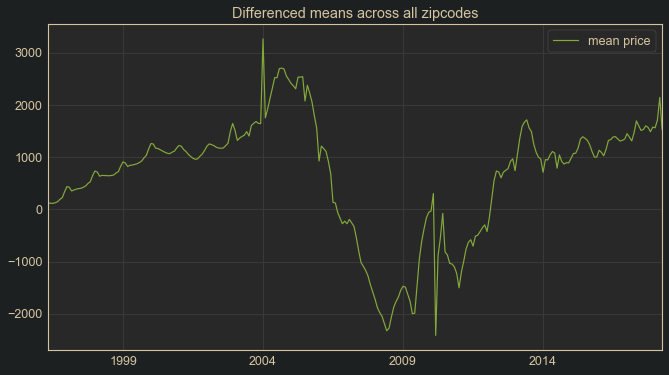

In [117]:
# I want to see what the total average market data would look like differenced
# This will give me an idea of how to transform each of the zipcodes when modeling them
# individually
# Also dropping the NaN created in differencing
means_diff = means.diff().dropna()
means_diff.plot(figsize=(11,6))
plt.title("Differenced means across all zipcodes")

In [118]:
# After differencing, we can still see the large trend caused by the crash and recovery of the
# market, indicating that the series is still not stationary.
# Also, we can see what may be yearly seasonality starting to appear

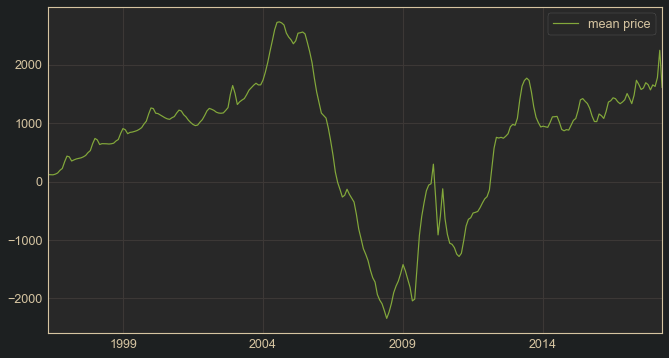

In [355]:
# I want to make sure the means2 shows all the same patterns
means2.diff().dropna().plot(figsize=(11,6))

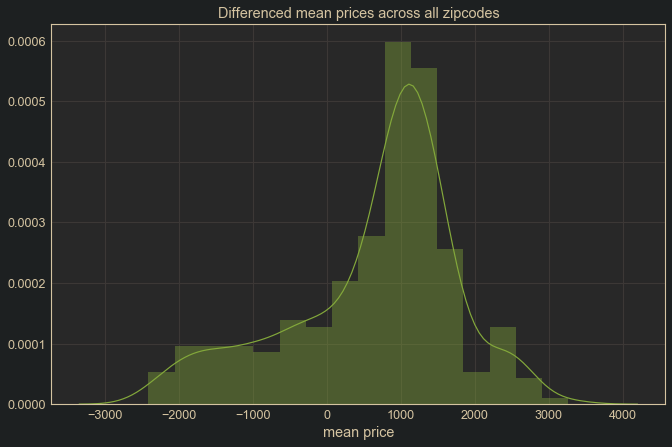

In [119]:
# We can see that these values are not quite normally distributed
import seaborn as sns
sns.distplot(means_diff['mean price'])
plt.title("Differenced mean prices across all zipcodes");

In [120]:
# Using Dickey-Fuller test on stationarity of differenced means
dftest = adfuller(means_diff['mean price'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced Means:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced Means:
 Test Statistic                  -2.548782
p-value                          0.104052
#Lags Used                      13.000000
Number of Observations Used    250.000000
dtype: float64


In [121]:
# Above we can see that differencing the means has not made them stationary according to the
# Augmented Dickey-Fuller test, as the null hypothesis of non-stationarity has not been
# rejected. Let's see if further transformations or differencing will fix it

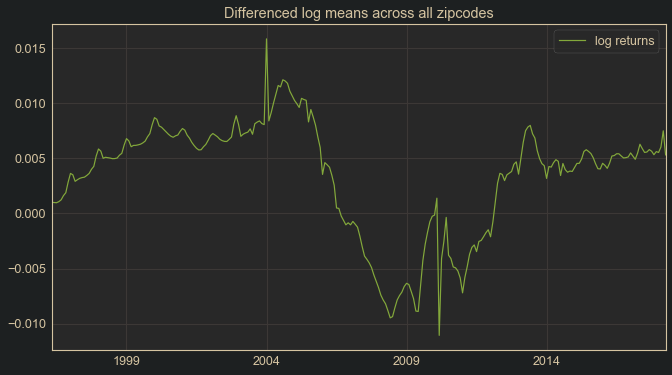

In [141]:
# Now to take the differenced log means and compare
means_diff_log = np.log(means).diff().dropna()
means_diff_log.plot(figsize=(11,6))
plt.legend(['log returns'])
plt.title("Differenced log means across all zipcodes");

Text(0.5, 1.0, 'Differenced log means across all zip codes')

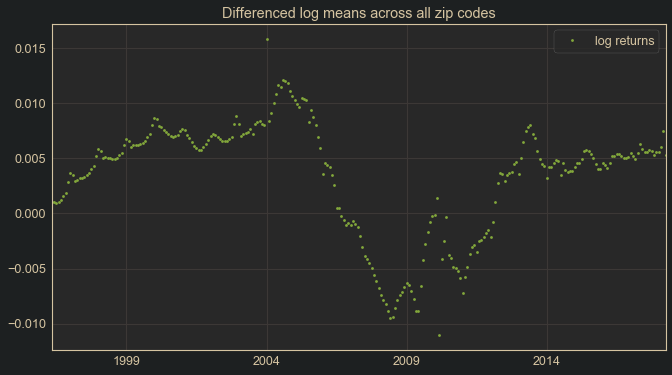

In [353]:
# We can see that there are periods high volatility (volatility clustering)
# The most dramatic parts occur just before major trend reversals. Let's look at the same chart
# with dots to see how individual months are behaving at these times
means_diff_log.plot(figsize=(11,6), style='.b')
plt.legend(['log returns'])
plt.title('Differenced log means across all zip codes')

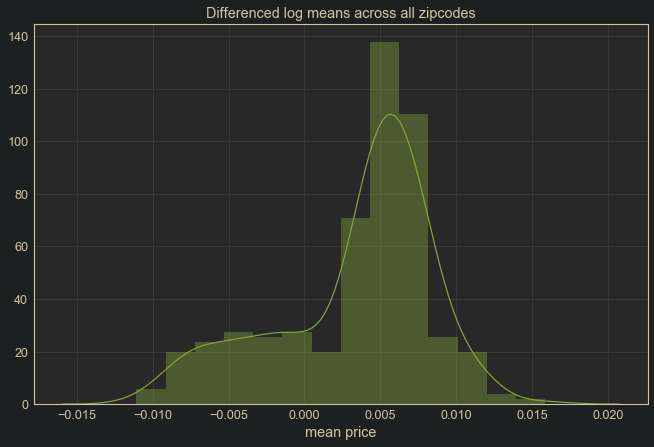

In [123]:
# And a look at the distribution:
sns.distplot(means_diff_log['mean price'])
plt.title("Differenced log means across all zipcodes");

In [124]:
dftest = adfuller(means_diff_log['mean price'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced log means:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced log means:
 Test Statistic                  -2.356598
p-value                          0.154363
#Lags Used                      13.000000
Number of Observations Used    250.000000
dtype: float64


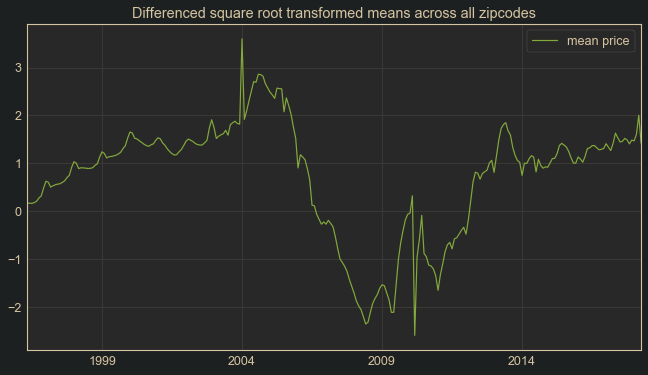

In [125]:
# It is clear this did not make the series more normal, and the Dickey-Fuller test did not 
# improve
# Now to try a square root transform:
means_diff_sqrt = (means ** (1/2)).diff().dropna()
means_diff_sqrt.plot(figsize=(11,6))
plt.title("Differenced square root transformed means across all zipcodes");

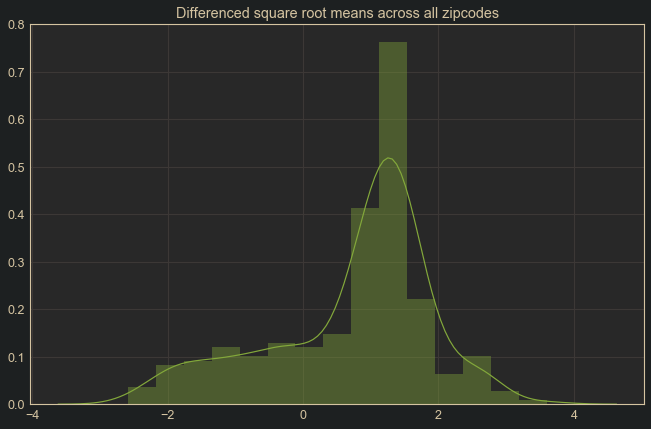

In [126]:
sns.distplot(means_diff_sqrt)
plt.title("Differenced square root means across all zipcodes");

In [127]:
dftest = adfuller(means_diff_sqrt['mean price'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced square root transformed means:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced square root transformed means:
 Test Statistic                  -2.462949
p-value                          0.124751
#Lags Used                      13.000000
Number of Observations Used    250.000000
dtype: float64


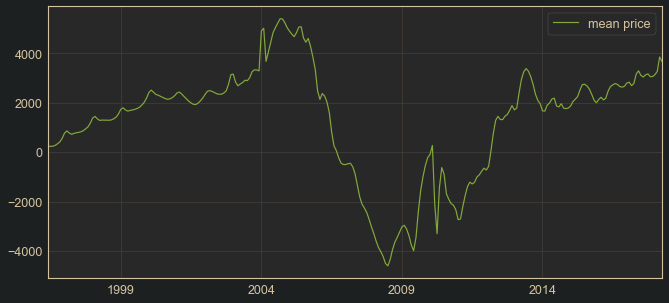

In [128]:
# Neither the log transform nor the square root transform has improved the stationarity
# Now to see how using a differencing period of 2 affects results
means_diff2 = means.diff(2).dropna()
means_diff2.plot(figsize=(11,5))

In [129]:
# We can see the 2 period difference did not help much, but smoothed out some of the noise a bit

In [130]:
dftest = adfuller(means_diff2['mean price'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for 2-period differenced means:\n================================\n",dfoutput)

Dickey-Fuller Results for 2-period differenced means:
 Test Statistic                  -2.403630
p-value                          0.140714
#Lags Used                      11.000000
Number of Observations Used    251.000000
dtype: float64


All of the above transformations did not provide a stationary time series. Upon further reading, I have realized that the d value in an ARIMA model represents recursive application of 1st degree differences. Below, I will see if two 1st order differences make for a stationary series:

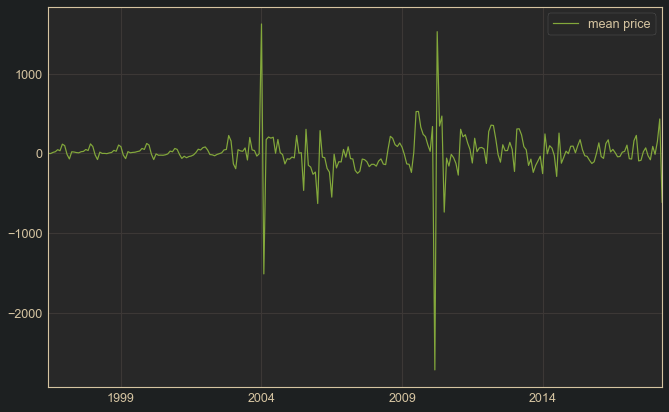

In [131]:
# Since the d value in ARIMA models does not represent the number of periods to difference
# across, but rather how many times a difference of 1 period is done recursively, I would like
# to see what a 2nd order differencing would do for the data:
means_diff_2 = means.diff().diff().dropna()
means_diff_2.plot()

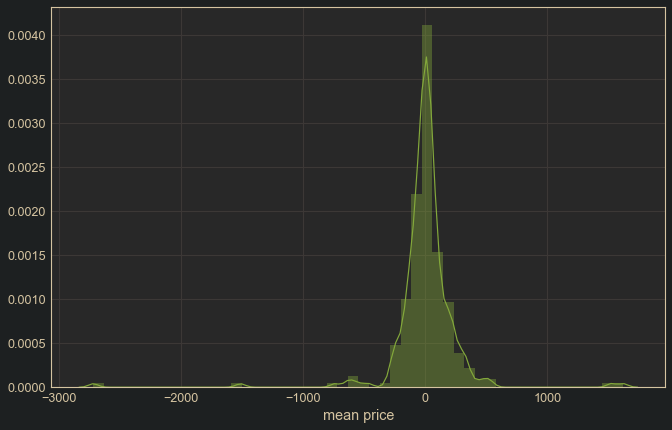

In [132]:
sns.distplot(means_diff_2['mean price'])

In [133]:
dftest = adfuller(means_diff_2['mean price'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced Means:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced Means:
 Test Statistic                 -21.111269
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    262.000000
dtype: float64


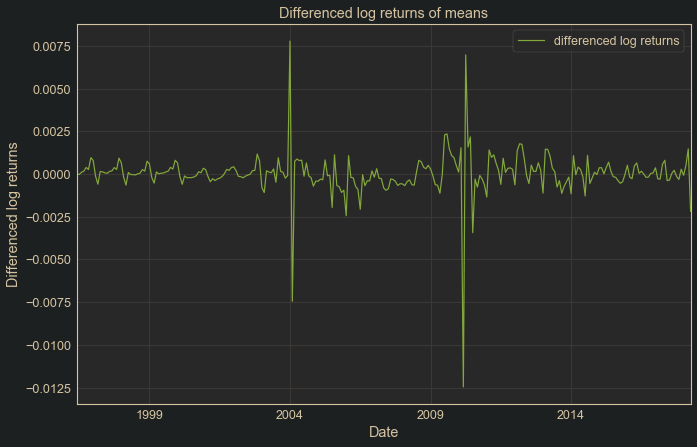

In [143]:
# We can see that this has made the time series stationary in regards to mean, but there is 
# visible heteroskedasticity. Let's see if a log transform would reduce that:
log_means_diff2 = np.log(means).diff().diff().dropna()
log_means_diff2.plot()
plt.title('Differenced log returns of means')
plt.xlabel('Date')
plt.ylabel('Differenced log returns')
plt.legend(['differenced log returns'])

In [68]:
# This transformation did not tame the periods of high volatility. It is starting to look like
# the best option is to limit the time window to some time after the drama of the crash, but
# perhaps there is a way to filter or account for this heteroskedasticity.

It is worth noting at this point that the ADF test rejected the null hypothesis of non-stationarity, but this is misleading, because one of the requirements of a stationary time series is having constant variance across time. As cited in [Stockhammar & Oller (2007)](https://www.diva-portal.org/smash/get/diva2:187599/FULLTEXT01.pdf), a study by Kim and Schmidt (1993) showed that Dickey-Fuller tests tend to reject too often in the presence of conditional heteroscedasticity (pg. 4). In order for a time series to be considered weakly stationary, which is an assumption for ARIMA models, it must have constant mean AND variance. As Stockhammar and Oller go on to discuss in their paper, conditional heteroskedasticity can make it difficult to detect time-varying means, masking non-stationarity. This means that the non-stationarity in variance must be dealt with, or omitted from the data.

### Considering Returns Instead
Upon further reading on modeling financial markets, it has come to my attention that people generally model returns rather than the prices, because these tend to more closely resemble normal distributions, and have better stationarity. Further, returns are generally calculated in practice as log returns, due to their additive properties. When returns are represented as percentages, they are multiplicative of their previous value, whereas log returns can be added together rather than multiplied. This make for more convenient math considering sequential data, since a cumsum() method can combine all of the growth.

In [144]:
# Creating log returns and checking
log_returns = np.log(means).diff().dropna()
log_returns.columns = ['returns']
log_returns.head()

returns
1996-05-01  0.001013
1996-06-01  0.000999
1996-07-01  0.000975
1996-08-01  0.001071
1996-09-01  0.001239

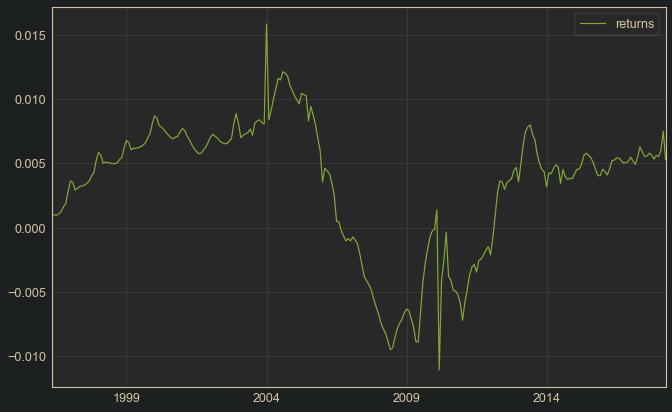

In [145]:
# A look at the plot
log_returns.plot()

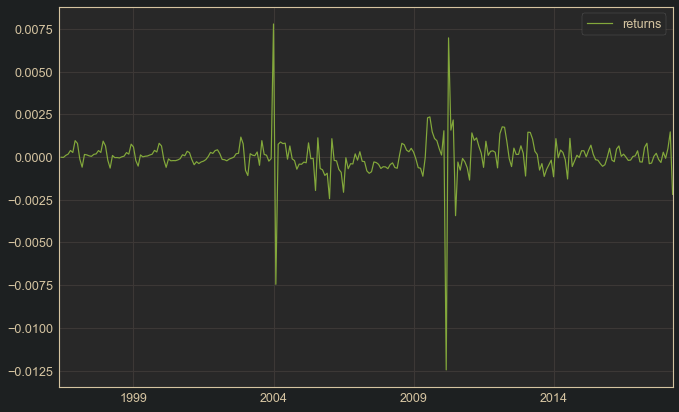

In [146]:
# We can see that this is the same as the step taken earlier, but for a different reason.
# Before, I was counting on the log transformation to make the data more normal and stationary,
# but this time I have done it to represent the returns over the course of the series.
# Since we determined before that 2nd order differencing made the most stationary results,
# and the returns incorporate one order of differencing already, these returns just need to
# be differenced one more time to become more stationary
log_returns.diff().plot()

### Looking at Seasonal Decomposition

I'd like to see what the seasonal_decompose function does with this data.

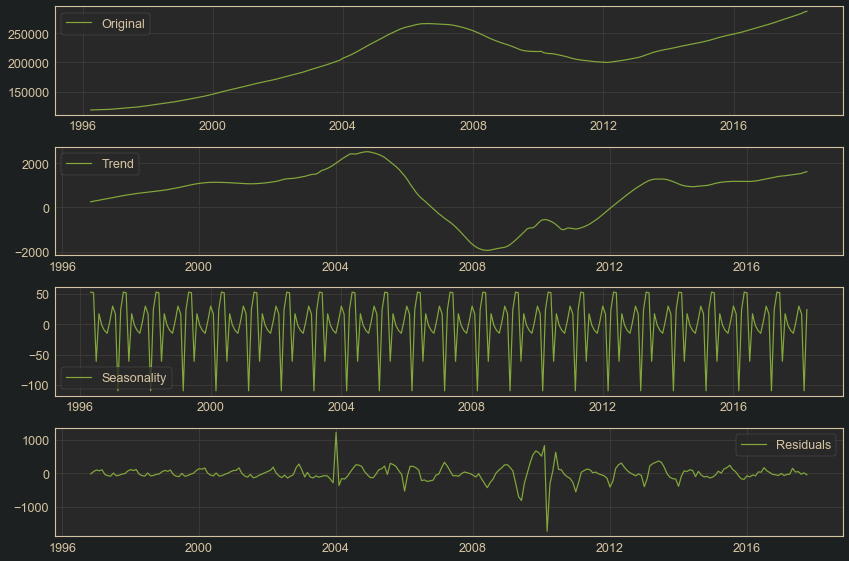

In [147]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(means_diff)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(means.dropna(), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [148]:
# We can see that when the decomposition removes the large sweeping trend
# This decomposition seems to be detecting yearly seasonality as well
# The residuals show heteroscedasticity, with the spikes in the familiar places.

### Using Periodogram to find long-term seasonality

I would now like to see if a periodogram can detect some longer seasonal trends

In [149]:
from scipy.signal import periodogram

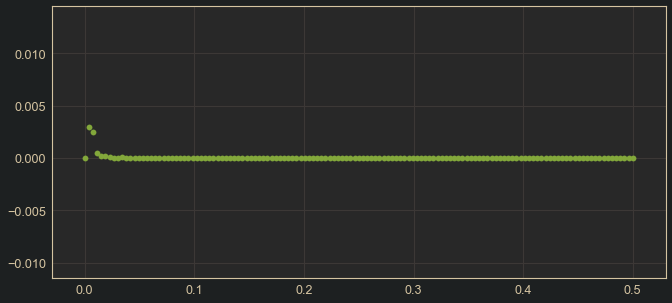

In [150]:
pgram = periodogram(log_returns['returns'])
plt.figure(figsize=(11,5))
plt.scatter(pgram[0], pgram[1]);

In [151]:
# Finding 3 largest specs:
indices = np.argpartition(pgram[1], -3)[-3:]
pd.DataFrame(list(zip((1 / pgram[0][indices])[::-1], pgram[1][indices][::-1])),
             columns=['Period', 'Spec']
            )

Period      Spec
0   132.0  0.002483
1   264.0  0.003004
2    88.0  0.000507

We can see that the most influential periods from the periodogram are periods which correspond to the full length of the dataset, half the length of the dataset, and a third of the length of the dataset. As shown in the investigation in [this notebook](understanding_fourier_series_with_R.ipynb), this is merely an artifact of the math involved in the periodogram, and does not give us conclusive evidence of a long term seasonality. As was shown in the other notebook, a mostly random set of data will show spikes on a periodogram at the full length of the data, and another at the halfway point. It should be noted however that the strength of the spike at the half-period in this series is stronger than expected for random data.

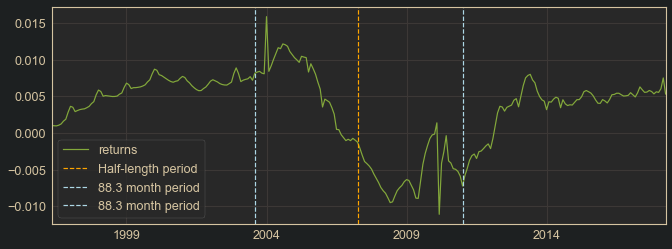

In [152]:
# Here we can observe visually the periods indicated by the periodogram, and see that there is
# no real seasonality at these periods:
ax = log_returns.plot(figsize=(11,4))
ax.axvline(means.index[132], 
           color='orange', 
           ls='--',
           label='Half-length period'
          )
ax.axvline(means.index[88], 
           color='lightblue', 
           ls='--',
           label='88.3 month period'
          )
ax.axvline(means.index[177], 
           color='lightblue', 
           ls='--',
           label='88.3 month period'
          )
plt.legend();

To drive this point home, the reason that a powerful spike will always be present at the period corresponding to the full length of a dataset is because you can take any time series of data, and lay it end on end some number of times, and produce a seasonality. This is shown below.

In [153]:
# Placing the trend data end on end
trend2 = pd.concat([pd.DataFrame(log_returns), 
                    pd.DataFrame(log_returns)], axis=0).reset_index()

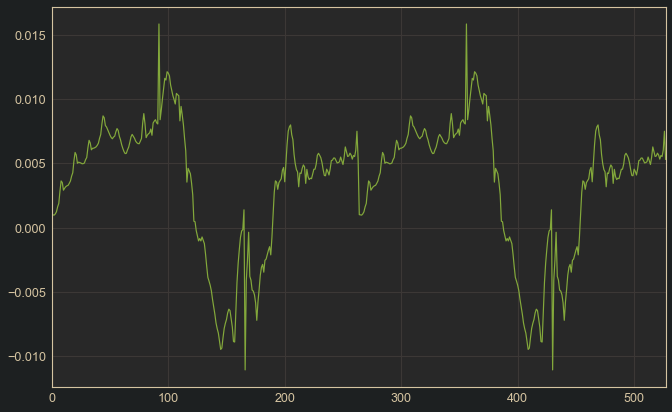

In [154]:
# Here we can see that having a seasonality the full length of data is not a valid assumption
# since repeating data is bound to make seasonality occur
trend2.returns.plot();

### Looking at autocorrelation

In [155]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

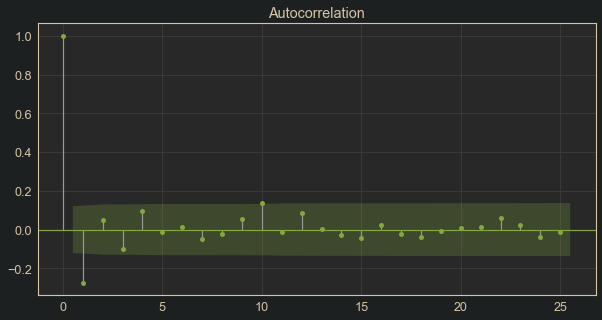

In [156]:
# First a look at an ACF for the stationary series produced by 2nd order differencing
# Note that a sharp dropoff past a certain value would inform us of a potential order for 
# MA terms
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(log_returns.diff().dropna(), 
          #lags = len(trend.dropna())-1, 
          ax=ax);

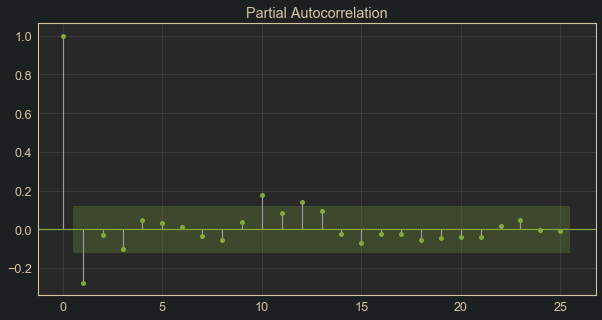

In [157]:
# We can see above that the ACF drops off after 1 lag, meaning an MA(1) model may be appropriate
# Now a look at a PACF for the series. Note that a sharp dropoff after a lag will indicate a
# potential order for AR terms, and a taper past a lag would be further evidence for an order
# of MA terms
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(log_returns.diff().dropna(), 
          #lags = len(trend.dropna())-1, 
          ax=ax);

In [158]:
# Above we can see that a similar dropoff occurs on both the ACF and PACF, meaning some model
# comparisons will be necessary to figure out the proper order for AR and MA

## Modeling:

### Facebook Prophet on full data:
Before going into fitting SARIMAX models on the data, I want to see what kind of predictions fbprophet will make, just as a comparison/benchmark, since prophet's predictions are generally considered to be reliable.

In [159]:
# I am going to do a fbprophet forecast on the mean market data, to see how it behaves
from fbprophet import Prophet as proph

In [160]:
means_proph = means.copy()
means_proph.head()

mean price
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312

In [161]:
# Need to format the new dataframe for prophet
means_proph['ds'] = means_proph.index
means_proph['ds'] = means_proph['ds'].asfreq('MS')
means_proph.rename(columns={'mean price':'y'}, inplace=True)
means_proph.head()

y         ds
1996-04-01  118299.123063 1996-04-01
1996-05-01  118419.044139 1996-05-01
1996-06-01  118537.423268 1996-06-01
1996-07-01  118653.069278 1996-07-01
1996-08-01  118780.254312 1996-08-01

In [162]:
Model = proph(interval_width=0.95)
Model.fit(means_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [163]:
# I will make projections 5yrs into the future, as this seems to be a good time horizon for
# real estate investment.
future_dates = Model.make_future_dataframe(periods=60, freq='MS')
predictions = Model.predict(future_dates)
pred_subset = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

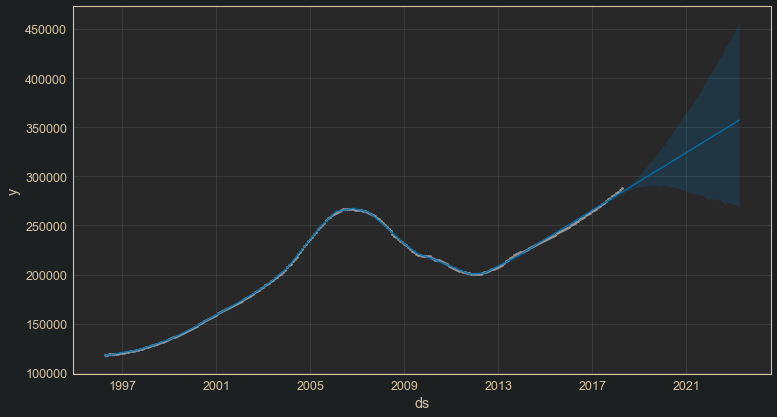

In [164]:
fig, ax = plt.subplots(figsize=(11, 6))
Model.plot(predictions, uncertainty=True, ax=ax);

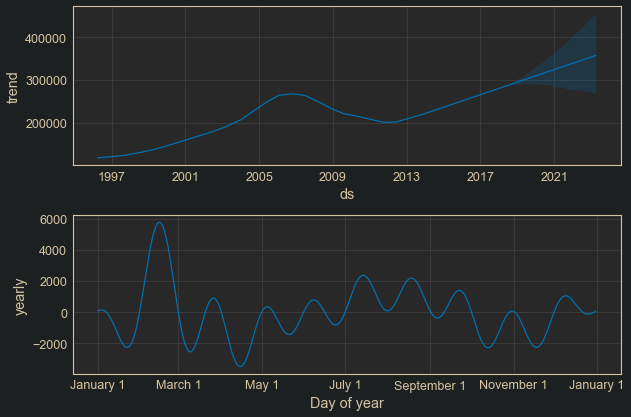

In [165]:
#fig, ax = plt.subplots(figsize=(11, 6))
ax = Model.plot_components(predictions)
ax.set_facecolor(plt.rcParams.get('figure.facecolor'))

We can see that Prophet has done its under-the-hood magic, and produced forecasts that are essentially a linear continuation of the trend after the market crash, with a confidence window that incorporates a possible second crash around the years 2020-2021. This is a pretty good result, considering that it was fast and seems to cover the different scenarios of the future market. It will be interesting to see how this stacks up to an ARIMA model on the same data (knowing that the data will be heteroscedastic, these models will still perform decently).

### Facebook Prophet on Returns:

In [166]:
returns_proph = log_returns.copy()
returns_proph.head()

returns
1996-05-01  0.001013
1996-06-01  0.000999
1996-07-01  0.000975
1996-08-01  0.001071
1996-09-01  0.001239

In [167]:
# Need to format the new dataframe for prophet
returns_proph['ds'] = returns_proph.index
returns_proph['ds'] = returns_proph['ds'].asfreq('MS')
returns_proph.rename(columns={'returns':'y'}, inplace=True)
returns_proph.head()

y         ds
1996-05-01  0.001013 1996-05-01
1996-06-01  0.000999 1996-06-01
1996-07-01  0.000975 1996-07-01
1996-08-01  0.001071 1996-08-01
1996-09-01  0.001239 1996-09-01

In [168]:
Model = proph(interval_width=0.95)
Model.fit(returns_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [169]:
# I will make projections 5yrs into the future, as this seems to be a good time horizon for
# real estate investment.
future_dates = Model.make_future_dataframe(periods=60, freq='MS')
predictions = Model.predict(future_dates)
pred_subset = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

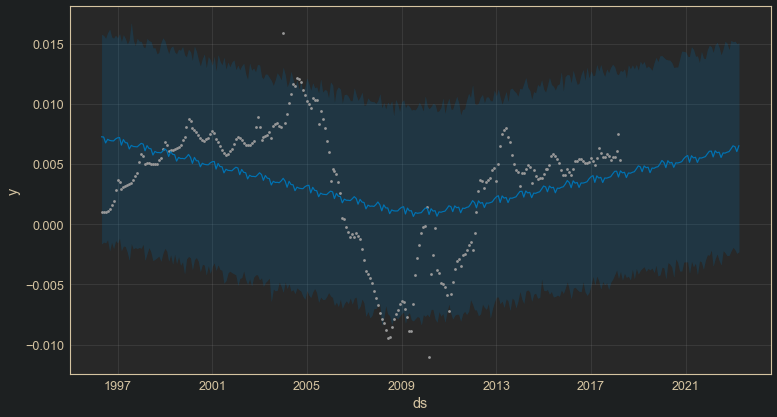

In [170]:
fig, ax = plt.subplots(figsize=(11, 6))
Model.plot(predictions, uncertainty=True, ax=ax);

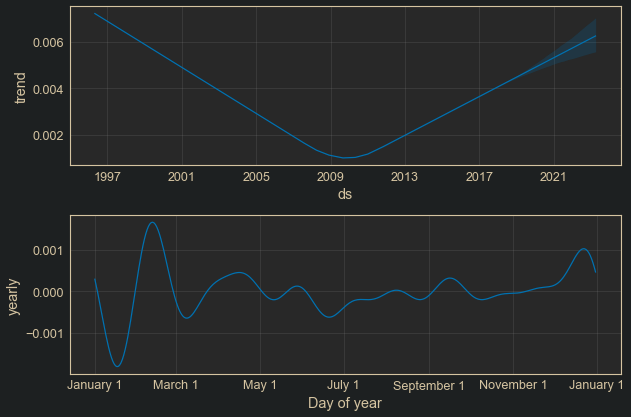

In [171]:
#fig, ax = plt.subplots(figsize=(11, 6))
ax = Model.plot_components(predictions)
ax.set_facecolor(plt.rcParams.get('figure.facecolor'))

Facebook prophet seems to have exhibited some strange behavior on the log returns... But it does seem to have also indicated some yearly seasonality.

### ARIMA on full data:

I'm now going to fit an ARIMA model to the means data, just to compare to facebook prophet, knowing that there is a special event taking place with the crash, and that the conditional heteroscedasticity violates the stationarity assumption.

In [172]:
import itertools
import statsmodels.api as sm

In [173]:
# Checking to see if index has an assigned frequency
means.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [174]:
# Need to fix the dataframe to have an explicit frequency for statsmodels
means_fix = means.asfreq('MS')
means_fix.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq='MS')

In [175]:
# Quick check for NaN values
means_fix.isna().sum()

mean price    0
dtype: int64

In [176]:
# Let's start with letting the max p, d, and q be 2
p = d = q = range(0, 3)

# Generating all combos of p, d, and q
pdq = list(itertools.product(p, d, q))

# Since we saw potential quarterly seasonality earlier, I will use a s value of 3, and make 
# necessary combinations:
pdqs = [(x[0], x[1], x[2], 12) for x in pdq]

In [177]:
# checking pdq
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [178]:
# checking pdqs
pdqs

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [179]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [180]:
len(pdq)*len(pdqs)

729

In [ ]:
# Now to see what a grid search turns up for the price data. Note that at this point, I realize
# that modeling returns is the recommended approach, rather than prices. This section is old
# and part of the process of experimentation with these models

In [181]:
combos = np.zeros(len(pdq)*len(pdqs))
aic_values = np.zeros(len(pdq)*len(pdqs))
scores = {}

for combo in pdq:
    for scombo in pdqs:
        model_params = (combo, scombo)
        scores[model_params] = np.NaN
        try:
            sarimax = SARIMAX(means_fix,
                              order=combo,
                              seasonal_order=scombo,
                              enforce_stationarity=False,
                              enforce_invertibility=False
                             )
            output = sarimax.fit()
            scores[model_params] = output.aic
            
        except:
            print("Error with parameters:", model_params)
            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [131]:
len(scores)

729

In [132]:
# Noting that this is taking a long time, whereas the auto.arima() function in R is very fast,
# it will be interesting to compare the results, after the wait. Note that the result from the
# R notebook was (0, 2, 1) with no seasonality, resulting in an AIC of 3705.08

# Another note is that this is taking a REALLY long time, so that it would not be possible to 
# generate a model in this way for each individual zipcode. It may be necessary to find the
# optimal pdq values generated by a model on the means, then apply those parameters to each
# zipcode, or it might be fast enough to use the auto.arima() function in R for each zipcode,
# allowing for more flexibility with the different data in each zipcode.

In [182]:
# Find the parameters with minimal AIC value
ideal_params = min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params))
#print(ideal_params)

Optimal AIC of 3112.2715927310774 with params: ((1, 2, 2), (1, 2, 2, 12))


In [183]:
model = SARIMAX(means_fix,
                order=ideal_params[0],
                seasonal_order=ideal_params[1],
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                         mean price   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1871.563
Date:                            Fri, 28 Aug 2020   AIC                           3757.127
Time:                                    11:28:59   BIC                           3781.462
Sample:                                04-01-1996   HQIC                          3766.933
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3889     13.445     -0.029      0.977     -26.742      25.964
ma.L1          0.3266     13.441   

In [ ]:
# For some reason, the AIC of this model does not match the score from the grid search...
# I have reviewed the code and have no explanation for this.

In [188]:
# Trying again using the same variable names as the loop
sarimax = SARIMAX(means_fix,
                order=(1,2,2),
                seasonal_order=(1,2,2,12),
                enforce_stationary=False,
                enforce_invertibility=False
               )
output = sarimax.fit()
print(output.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                         mean price   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1871.563
Date:                            Fri, 28 Aug 2020   AIC                           3757.127
Time:                                    12:39:13   BIC                           3781.462
Sample:                                04-01-1996   HQIC                          3766.933
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3889     13.445     -0.029      0.977     -26.742      25.964
ma.L1          0.3266     13.441   

In [186]:
# The AIC is still different, there seems to be a bug
# I will build a nested for loop and see if this gets rid of the bug
scores = {}
rang = range(0,3)

for p in rang:
    for d in rang:
        for q in rang:
            for sp in rang:
                for sd in rang:
                    for sq in rang:
                        model_params = ((p,d,q), (sp,sd,sq,12))
                        scores[model_params] = np.NaN
                        try:
                            sarimax = SARIMAX(means_fix,
                                              order=(p,d,q),
                                              seasonal_order=(sp,sd,sq,12),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False
                                             )
                            output = sarimax.fit()
                            scores[model_params] = output.aic

                        except:
                            print("Error with parameters:", model_params)
                            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [187]:
# Find the parameters with minimal AIC value
ideal_params2= min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params2))
#print(ideal_params)

Optimal AIC of 3112.2715927310774 with params: ((1, 2, 2), (1, 2, 2, 12))


In [ ]:
# Again, the grid search has produced an AIC value that is different from what I get when I run
# the model with the same parameters. Interestingly enough, the misreported AIC values are
# the same from both grid searches.

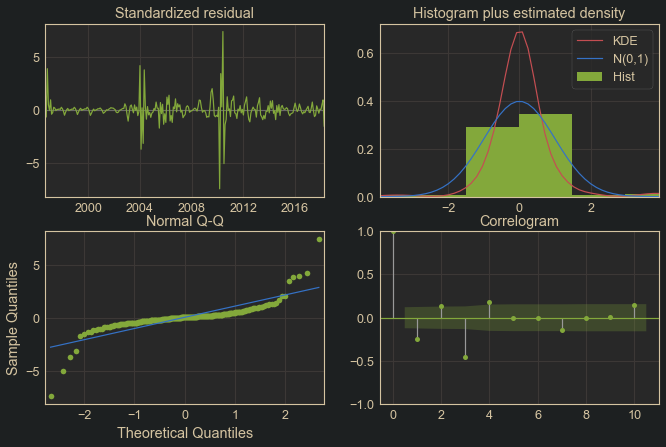

In [299]:
model.plot_diagnostics(figsize=(11,7));

In [ ]:
# Diagnosing the model, we can see that the null hypothesis of the Ljung-Box test that the
# residuals are not autocorrelated is firmly rejected, which is not good.
# We can also see that the null hypothesis of the Heteroskedasticity test, which is that the
# residuals are not heteroskedastic, is not rejected, though it can be seen in the plot
# The kurtosis is quite high and thus the JB test null hypothesis of normal skew and kurtosis
# of residuals is rejected.

In [201]:
# Modeling again, removing the non-significant parameters
model = SARIMAX(means_fix,
                order=(0,2,1),
                seasonal_order=(1,2,1,12),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         mean price   No. Observations:                  265
Model:             SARIMAX(0, 2, 1)x(1, 2, 1, 12)   Log Likelihood               -1871.026
Date:                            Fri, 28 Aug 2020   AIC                           3750.051
Time:                                    12:43:13   BIC                           3763.957
Sample:                                04-01-1996   HQIC                          3755.655
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0730      0.017     -4.379      0.000      -0.106      -0.040
ar.S.L12       0.4743      0.039   

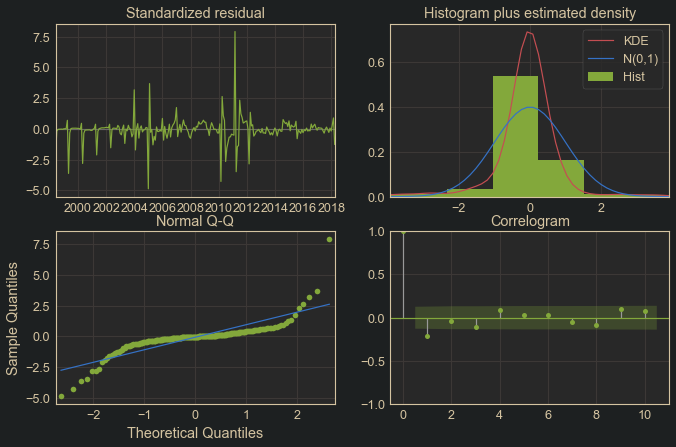

In [202]:
model.plot_diagnostics(figsize=(11,7));

In [203]:
# The null hypothesis of the Ljung-Box test of non-autocorrelated residuals is rejected
# The null hypothesis of the Heteroskedasticity test of homoskedastic residuals is 
# not rejected
# The JB null hypothesis of normal skew and kurtosis is rejected

In [204]:
pd.plotting.register_matplotlib_converters()

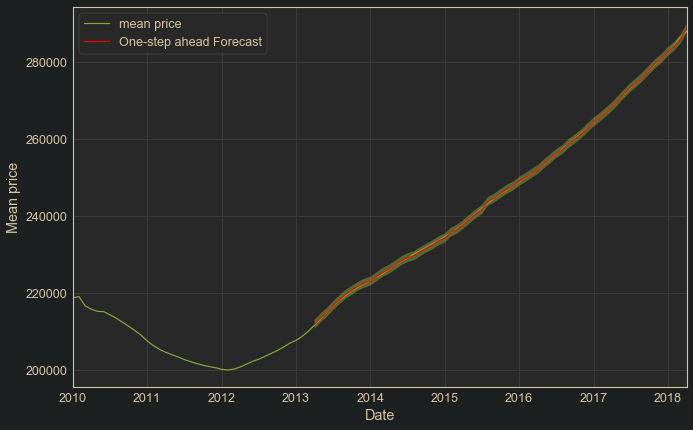

In [205]:
# Get predictions
pred = model.get_prediction('2013-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means['2010':].plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [206]:
forecasted = pred.predicted_mean
truth = means_fix['2013-04':'2018-04']['mean price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 46529.03


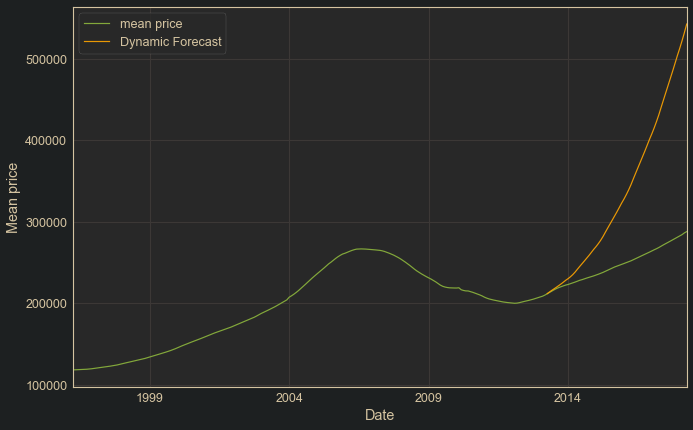

In [207]:
# We can see that the one step ahead forecasts were fairly accurate on the training data,
# let's look now at the dynamic forecast from the same date

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
#ax.fill_between(pred_dynamic_conf.index, 
#                pred_dynamic_conf.iloc[:, 0], 
#                pred_dynamic_conf.iloc[:, 1],
#                alpha=0.5
#               )
#ax.fill_betweenx(ax.get_ylim(), 
#                 pd.to_datetime('2013-04'), 
#                pred_dynamic.predicted_mean.index[-1],
#                alpha=0.1,
#                zorder=-1
#               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [208]:
# We can see that this has not gone well, the forecast is way off of the observed line
# Moving the cutoff point further into the dataset mitigates this, but there is still a lot of
# error.

In [209]:
# Despite the shortcomings of this model, let's see what a 5 year future forecast looks like
# with it
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

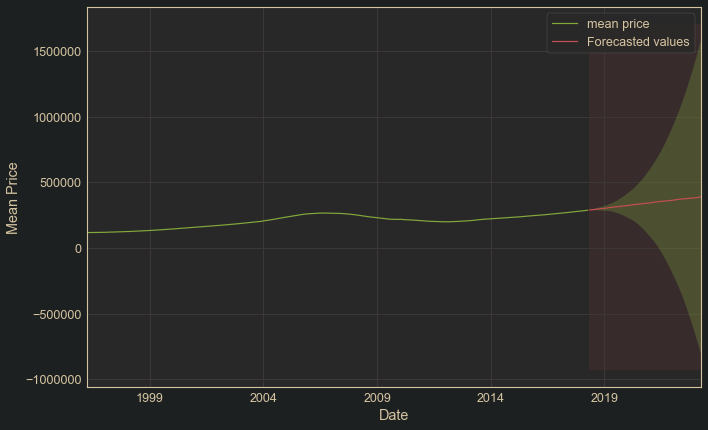

In [210]:
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [211]:
# Again, the results are terrible.
# I want to try a much simpler model, like the one that the auto.arima() function in R
# recommended, to see how it compares.
model = SARIMAX(means_fix,
                order=(0,2,1),
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1857.963
Date:                Fri, 28 Aug 2020   AIC                           3719.926
Time:                        12:44:16   BIC                           3727.071
Sample:                    04-01-1996   HQIC                          3722.798
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0666      0.014     -4.919      0.000      -0.093      -0.040
sigma2      7.702e+04   1565.269     49.203      0.000    7.39e+04    8.01e+04
Ljung-Box (Q):                       34.52   Jarque-

In [212]:
# We can see that this model has a better AIC and log likelihood. Somehow something must have
# gone wrong with the grid search above, because the AIC for the model with the parameters
# that process recommended did not have as good of an AIC as what was printed out with the 
# parameters. Perhaps (0,0,0,4) for a seasonal order is not equivalent to leaving out the
# seasonal component...
# This time, the Ljung-Box test is showing that the residuals are not autocorrelated,
# but there is still a problem with heteroskedasticity. Also, the JB score is quite high due
# to the large amount of kurtosis due to the extreme values in the residuals.

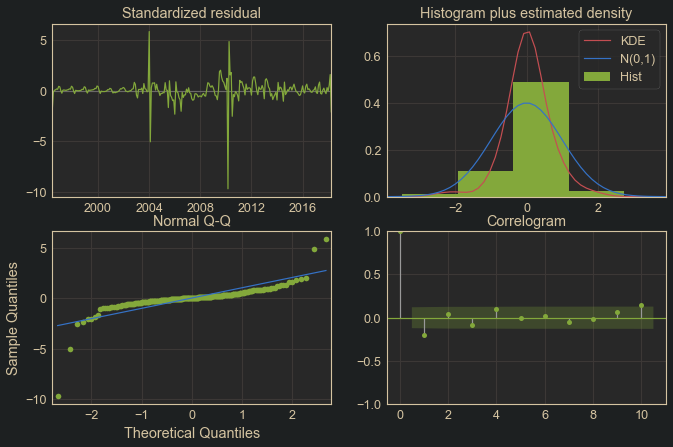

In [213]:
# A look at the diagnostics for this much simpler model:
model.plot_diagnostics(figsize=(11,7));

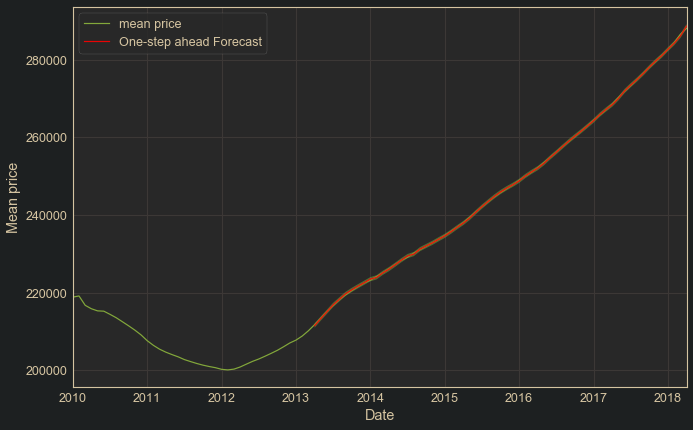

In [214]:
# These results are looking better, with less extreme errors.
# Let's see the predictive behavior of this simple model in
# comparison.
# Get predictions
pred = model.get_prediction('2013-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means_fix['2010':].plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [215]:
forecasted = pred.predicted_mean
truth = means_fix['2013-04':'2018-04']['mean price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22405.72


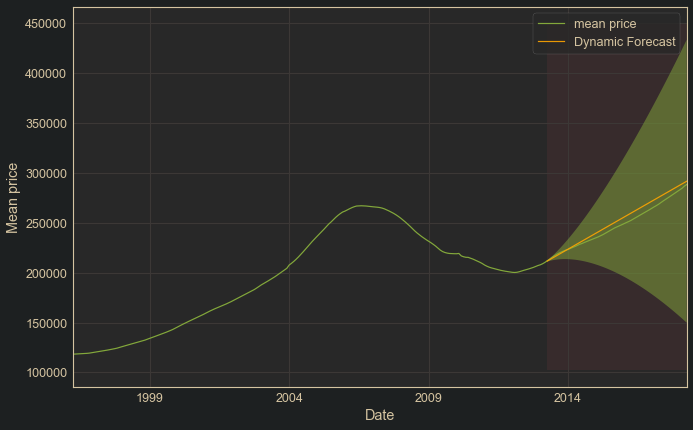

In [216]:
# We can see the simple model is far outperforming the more complex one with seasonality.
# The confidence interval is not even observable on the graph, and the MSE is far lower.
# Let's look now at the dynamic forecasting, with the same 5 year cutoff to most recent data
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

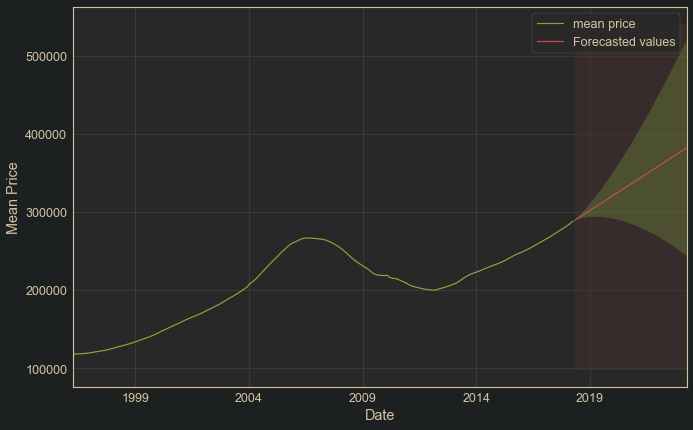

In [217]:
# As we can see, the mean prediction line is fairly spot on, but the confidence interval is 
# very wide, meaning that there would be low confidence for the investor had they not known
# the actual data.
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [218]:
# This looks to be the same result returned from the auto.arima() function in R
# This is not bad, but again the confidence intervals are very wide.

# These results are also similar to those from the fbprophet model, except that the confidence
# bands are wider.

# The diagnostics for this model were fairly good, but we can see from the Q-Q plot of residuals
# that the distribution of residuals has very thin tails. This is due to the periods of
# high volatility around the time of the crash.

In [219]:
# I would now like to do another grid search, this time leaving out the seasonal component
# altogether, to see if python reaches the same result as auto.arima() in this way
scores = {}
for combo in pdq:
    scores[combo] = np.NaN
    sarimax = SARIMAX(means_fix,
                      order=combo,
                      enforce_stationarity=False,
                      enforce_invertibility=False
                     )
    output = sarimax.fit()
    scores[combo] = output.aic

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [220]:
# Find the parameters with minimal AIC value
ideal_params = min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params))

Optimal AIC of 3667.539565439485 with params: (0, 2, 2)


In [221]:
# We can see that instead of giving us a MA(1), this gride search has produced an MA(2)
# Let's make sure the scores were encoded as expected
scores

{(0, 0, 0): 7227.7079129085505,
 (0, 0, 1): 7010.00513809116,
 (0, 0, 2): 6941.573909104385,
 (0, 1, 0): 4522.908195768892,
 (0, 1, 1): 4245.393933165031,
 (0, 1, 2): 4046.795195240322,
 (0, 2, 0): 3709.270568279877,
 (0, 2, 1): 3678.88147914604,
 (0, 2, 2): 3667.539565439485,
 (1, 0, 0): 4475.332919259364,
 (1, 0, 1): 4294.657407073918,
 (1, 0, 2): 4227.693137501441,
 (1, 1, 0): 3721.9022826125192,
 (1, 1, 1): 3693.4678569050784,
 (1, 1, 2): 3681.662481206379,
 (1, 2, 0): 3691.576156191074,
 (1, 2, 1): 3680.438607484998,
 (1, 2, 2): 3668.533715036324,
 (2, 0, 0): 3723.225527949846,
 (2, 0, 1): 3721.67379972293,
 (2, 0, 2): 3698.0347892593973,
 (2, 1, 0): 3692.467177822459,
 (2, 1, 1): 3694.4747650796457,
 (2, 1, 2): 3682.924827113188,
 (2, 2, 0): 3680.4635575126426,
 (2, 2, 1): 3682.5067440537396,
 (2, 2, 2): 3669.852647055137}

In [222]:
# This does seem to produce a lower AIC score, let's see this model
model = SARIMAX(means_fix,
                order=(0,2,2),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -1857.932
Date:                Fri, 28 Aug 2020   AIC                           3721.863
Time:                        15:14:21   BIC                           3732.579
Sample:                    04-01-1996   HQIC                          3726.170
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0647      0.015     -4.273      0.000      -0.094      -0.035
ma.L2          0.0054      0.052      0.103      0.918      -0.097       0.108
sigma2      7.815e+04   1635.899     47.771      0.0

In [223]:
model.aic

3721.863033239001

In [144]:
# Interestingly enough, the grid search has yet again deceived me in the AIC that the model
# parameters produce. This method has simply not paid off so far, instead of troubleshooting
# this inefficient method, I will just stick to using the auto.arima() function in R, since
# it is faster and more reliable.

# Just to review, the ARIMA(0,2,1) suggested by the auto.arima() function outperformed the
# ARIMA(0,2,2) model suggested by the grid search, which had errors in the AIC values due
# to the bug in the statsmodels function.

Before I move on to any more modeling, it has come to my attention that the auto.arima() model from R is faster and more reliable than grid searching for (p, d, q) values in python. It would be ideal to be able to call these functions from python, and apparently there is a way to do that using a package called rpy2. I will now try and get that to work.

The first function in R that I'd like to get to use through python is the fourier() function from the 'forecast' package. It generates a Fourier series for the input data, which can be used as exogenous terms in an ARIMA function.

In [243]:
# Allows you to import r packages
from rpy2.robjects.packages import importr

In [244]:
# How to install r packages from python
#utils = importr('utils')
#utils.install_packages('forecast')

In [245]:
# Import desired package(s)
importr('forecast')

rpy2.robjects.packages.Package as a <module 'forecast'>

In [246]:
# Will convert python lists to a R style FloatVector
from rpy2.robjects import FloatVector

In [247]:
from collections import OrderedDict
from rpy2.robjects import DataFrame

In [248]:
rlist = list(map(FloatVector, [means_fix['mean price']]))

In [249]:
d = OrderedDict(zip(map(str, range(len(rlist))), rlist))
data = DataFrame(d)

In [250]:
# Convert series into a usable format
FloatVector(means_fix['mean price'])

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000001C08B3AD848 / R:0x000001C0D7A00DA8>
[118299.123063, 118419.044139, 118537.423268, 118653.069278, ..., 282657.060382, 284368.688447, 286511.376757, 288039.944305]

In [251]:
from rpy2.robjects import r

First, a bit of a detour into generating Fourier Series from R using python. Note that this ultimately does not come in handy for this project, but definitely could in the future.

In [252]:
# Earlier the periodogram showed a strong spike at the full-length period of the data, and the
# halfway point. I discussed how this is an artifact of the way that the periodogram is made,
# but one thing I noticed is that the half-period spike is higher than it would be for the 
# random data experiment from the R notebook. This means that there may be more to investigate
# here than just an artifact of the math, let's see
fs = r['fourier'](r['ts'](FloatVector(means_fix['mean price']), f=132.5), K=1)

In [253]:
fs

R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000001C081738B08 / R:0x000001C0D7A16F18>
[0.047402, 0.094698, 0.141781, 0.188546, ..., 0.989898, 0.995506, 0.998876, 1.000000]

In [254]:
# We can see that the returned matrix is one dimensional, whereas it should be 2
# Looking at the comparable result from the R notebook, it looks like the columns have been
# laid end to end, we can set up the appropriate dataframe as below
two_d = list(zip(fs[:265], fs[265:]))
two_d

[(0.04740249628668982, 0.9988758698385852),
 (0.0946984194217752, 0.9955060066915807),
 (0.14178143585783998, 0.9898979868885931),
 (0.18854569071715174, 0.9820644187180351),
 (0.23488604578098365, 0.9720229140804107),
 (0.28069831586769994, 0.9597960488921784),
 (0.32587950306816577, 0.9454113123292133),
 (0.37032802831186007, 0.9289010450239843),
 (0.4139439597430692, 0.9103023663553931),
 (0.45662923739371303, 0.8896570909947473),
 (0.4982878936476807, 0.8670116348954942),
 (0.5388262690010142, 0.8424169109380739),
 (0.5781532226328543, 0.8159282144645111),
 (0.616180337313733, 0.7876050989600907),
 (0.6528221181905216, 0.7575112421616201),
 (0.6879961850011169, 0.7257143028933003),
 (0.7216234572867163, 0.6922857689520757),
 (0.7536283321852749, 0.6573007963844566),
 (0.7839388544064212, 0.6208380405161622),
 (0.8124868780056812, 0.5829794791144721),
 (0.8392082195943015, 0.5438102280808652),
 (0.8640428026402155, 0.5034183500883153),
 (0.8869347925357273, 0.4618946565934774),
 (0.

In [255]:
# This can be easily fit into a DataFrame
fourier_series = pd.DataFrame(two_d)
fourier_series.head()

0         1
0  0.047402  0.998876
1  0.094698  0.995506
2  0.141781  0.989898
3  0.188546  0.982064
4  0.234886  0.972023

In [256]:
# Now to make a function to get everything together properly:
def fourier_series(data, freqs, K, h=None):
    if type(data) != pd.core.frame.DataFrame:
        raise ValueError("Input data must be a Pandas DataFrame")
    if len(data.columns) > 1:
        raise ValueError("Input DataFrame must have only one column")
    
    from rpy2.robjects.packages import importr
    from rpy2.robjects import FloatVector
    from rpy2.robjects import r
    importr('forecast')
    
    index = data.index
    length = len(data)
    
    for col in data:
        for freq in freqs:
            rlist = FloatVector(data[col])
            if not h:
                fs = r['fourier'](r['ts'](rlist, f=freq), K=K)
            else:
                fs = r['fourier'](r['ts'](rlist, f=freq), K=K, h=h)
            
            length = int(len(fs)/(2*K))
            fourier_terms = pd.DataFrame()
            for i in range(K):
                columns = ['S'+str(i+1)+'-'+str(round(freq, 2)), 
                           'C'+str(i+1)+'-'+str(round(freq, 2))]
                # split sine and cosine values:
                i *= 2
                s = fs[i*length:(i+1)*length]
                c = fs[(i+1)*length:(i+2)*length]
                fourier_terms = pd.concat([fourier_terms, 
                                           pd.DataFrame(list(zip(s,c)), columns=columns)],
                                          axis=1
                                         )
    if not h:
        fourier_terms.index = index
    
    return fourier_terms

In [257]:
fs = fourier_series(means_fix, freqs=[132.5], K=2)
fs.head()

S1-132.5  C1-132.5  S2-132.5  C2-132.5
1996-04-01  0.047402  0.998876  0.094698  0.995506
1996-05-01  0.094698  0.995506  0.188546  0.982064
1996-06-01  0.141781  0.989898  0.280698  0.959796
1996-07-01  0.188546  0.982064  0.370328  0.928901
1996-08-01  0.234886  0.972023  0.456629  0.889657

In [258]:
pd.plotting.register_matplotlib_converters()

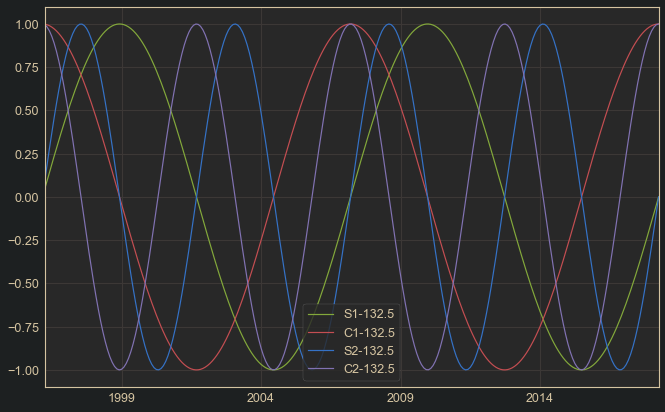

In [259]:
# A quick look at what we made
fs.plot()

In [260]:
# We can see the first and second harmonics of sine and cosine here

In [261]:
# Fitting the simple model using a Fourier Series as exogenous predictors
fs = fourier_series(means_fix, freqs=[132.5], K=1)
model = SARIMAX(means_fix,
                order=(0,2,1),
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1855.174
Date:                Fri, 28 Aug 2020   AIC                           3718.348
Time:                        15:55:56   BIC                           3732.637
Sample:                    04-01-1996   HQIC                          3724.091
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-132.5   -7169.6188   1.07e+04     -0.668      0.504   -2.82e+04    1.39e+04
C1-132.5    1.748e+04   1.38e+04      1.264      0.206   -9620.208    4.46e+04
ma.L1         -0.0956      0.020     -4.742      0.0

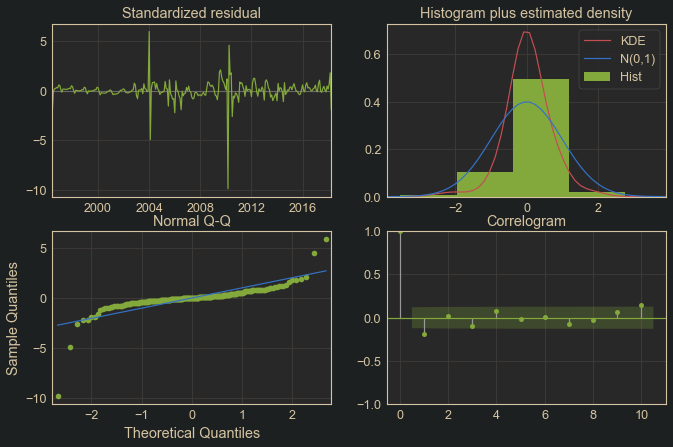

In [169]:
# We can see that the fourier terms did not aid the model much in this case, and has insignificant
# coefficients. This all may come in handy for future datasets, however.
model.plot_diagnostics(figsize=(11,7));

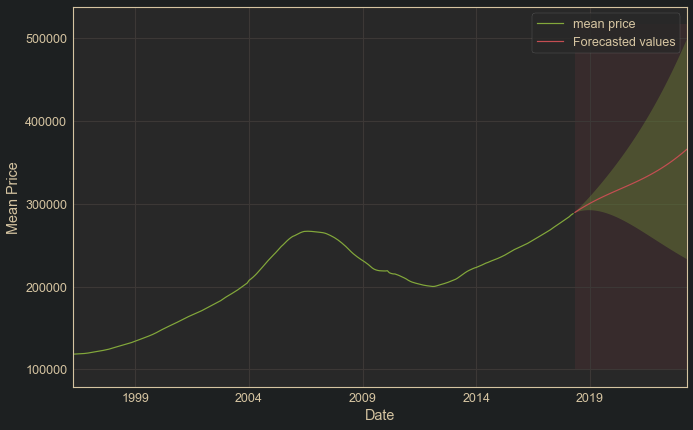

In [171]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60, exog=fourier_series(means_fix, freqs=[132.5], K=1, h=60))

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

That function is working properly, although it does not seem to be useful so far. It should prove useful in the future.<br>
<br>
The second function to get use of in python is the auto.arima() function, also from the 'forecast' package in R. This function is optimized to find the best fitting SARIMA model to data, without having to do a stepwise grid search. This can save a lot of time when generating multiple models.

In [262]:
rlist = FloatVector(means_fix['mean price'])

In [270]:
rmodel = r['auto.arima'](rlist, 
                        seasonal='TRUE'
                       )

In [271]:
print(rmodel)

Series: c(118299.123063432, 118419.044139141, 118537.42326805, 118653.069277989,  118780.254311605, 118927.528500438, 119120.520315697, 119345.352236188,  119685.084770535, 120121.26571178, 120544.241449868, 120896.623794212,  121268.174510377, 121655.897398422, 122053.105817013, 122456.339057362,  122879.926927293, 123327.402265254, 123823.105590062, 124353.737668981,  125002.601388381, 125736.669832688, 126450.778110616, 127086.25703222,  127736.362972163, 128385.014977716, 129032.702564477, 129676.357127201,  130324.519617155, 130982.618543143, 131678.088697304, 132399.342441733,  133224.702272229, 134133.593921239, 135020.881128078, 135841.586907284,  136683.794841821, 137532.147293052, 138391.809746475, 139265.156718054,  140160.604953606, 141084.832322642, 142070.095711259, 143104.04033024,  144261.328267699, 145522.064732958, 146772.26565354, 147943.683787536,  149107.817637174, 150247.760648791, 151364.608752831, 152457.017607949,  153530.934463359, 154597.187111858, 155691.101

We can see that this has worked, and that the parameters of the model can be seen. The output is a little messy, and it turns out that the tuple of parameters is simple to extract from the output. Luckily, converting the entire output to a string first aids the process:

In [265]:
# Extracting the model parameters:
string = str(rmodel).split('ARIMA')[1].split(' ')[0]
param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
print(param)

(0, 2, 1)


In [266]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(means_fix,
                order=(0,2,1),
                #seasonal_order=(0,1,0,12),
                enforce_stationary=False,
                enforce_invertibility=False,
                #exog=fs
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -1857.963
Date:                Fri, 28 Aug 2020   AIC                           3719.926
Time:                        15:57:14   BIC                           3727.071
Sample:                    04-01-1996   HQIC                          3722.798
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0666      0.014     -4.919      0.000      -0.093      -0.040
sigma2      7.702e+04   1565.269     49.203      0.000    7.39e+04    8.01e+04
Ljung-Box (Q):                       34.52   Jarque-

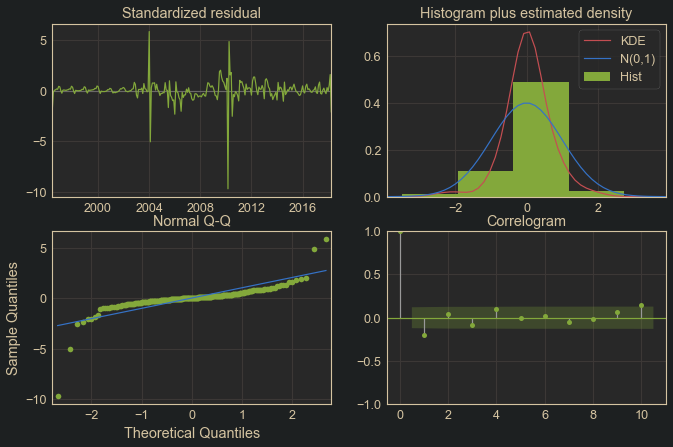

In [267]:
model.plot_diagnostics();

In [272]:
# Now to add a yearly seasonal component to the model, since earlier we were able to see this
# in the data, and see how the model compares
# Note that the auto.arima model did not suggest seasonality, so if this improves the AIC of
# the model, it might mean that auto.arima is not foolproof, and some old fashioned data
# analysis is appropriate for model tuning
model = SARIMAX(means_fix,
                order=(0,2,1),
                seasonal_order=(0,1,1,12),
                enforce_stationary=False,
                enforce_invertibility=False,
                #exog=fs
               ).fit()
print(model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         mean price   No. Observations:                  265
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood               -1848.404
Date:                            Fri, 28 Aug 2020   AIC                           3702.808
Time:                                    15:58:44   BIC                           3713.384
Sample:                                04-01-1996   HQIC                          3707.064
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0540      0.015     -3.721      0.000      -0.082      -0.026
ma.S.L12      -0.0875      0.011   

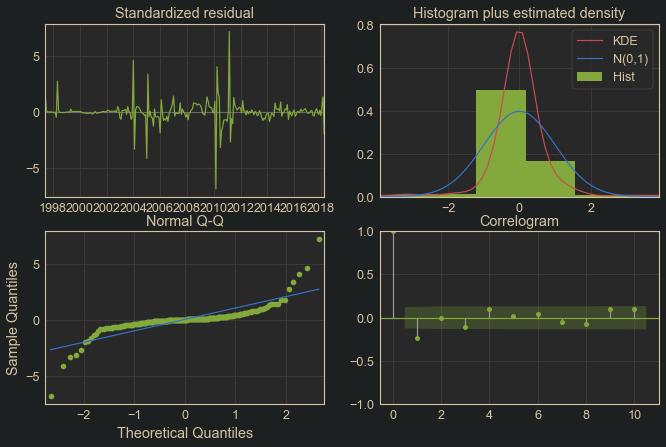

In [269]:
model.plot_diagnostics();

#### Notes:
We have now managed to get the parameter optimizing power of auto.arima() function from R into a python workflow, which means that it will be possible to generate seperate models for each of the zipcodes, which will allow for more flexibility. Also, we have shown that although the auto.arima did not suggest seasonality, our earlier inspections of the data showed that there was possible yearly seasonality in the data, and when this component was added to the model, the AIC improved.

### ARIMA Modeling on Returns

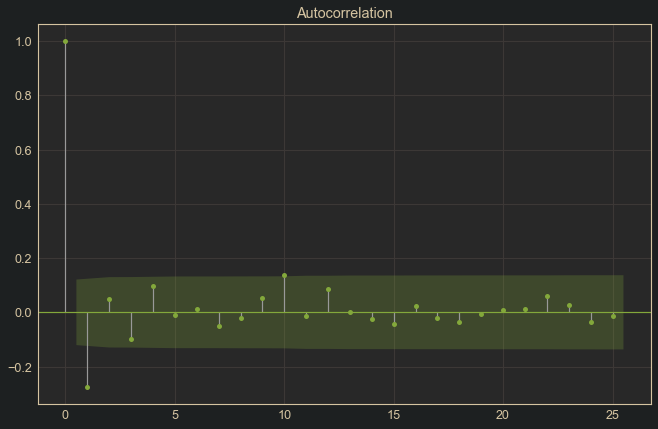

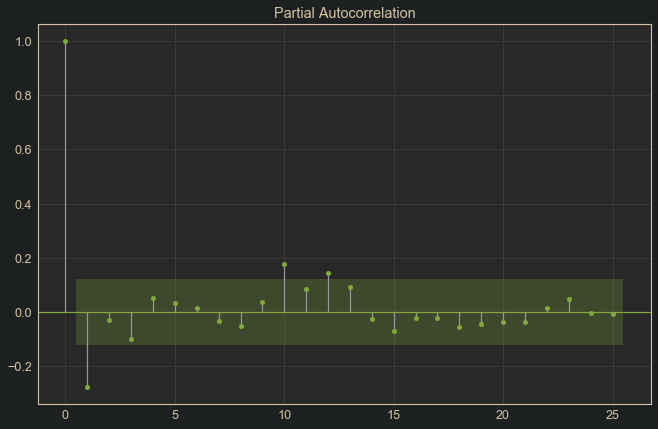

In [276]:
# First a look at the acf and pacf of differenced returns
plot_acf(log_returns['returns'].diff().dropna());
plot_pacf(log_returns['returns'].diff().dropna());

In [277]:
rlist = FloatVector(log_returns['returns'])

In [278]:
rmodel = r['auto.arima'](rlist, 
                        seasonal='TRUE'
                       )

In [279]:
print(rmodel)

Series: c(0.00101319714819503, 0.000999163602102726, 0.000975131995057055,  0.00107133273339954, 0.00123911977921232, 0.00162145296717675,  0.00188565336166846, 0.00284258998446596, 0.00363778041225871,  0.00351505438886512, 0.00291899711504762, 0.00306857982923425,  0.00319213500934801, 0.00325969713934349, 0.00329830699272371,  0.00345312413668708, 0.00363495134065595, 0.00401135319368429,  0.00427624818301453, 0.00520432074347887, 0.00585524986142794,  0.00566332854708662, 0.00501291854273234, 0.00510243047009773,  0.00506520305003377, 0.00503220182146258, 0.00497590530107139,  0.00498585882309932, 0.00503698691141352, 0.00529559054903039,  0.00546245496814812, 0.00621451636790482, 0.00679907946199698,  0.00659316863196935, 0.00605996317417556, 0.00618078661375954,  0.00618749698672438, 0.00623117502512827, 0.00629085495611648,  0.00640922508700648, 0.00657241379588669, 0.00695921043553049,  0.00725135290256773, 0.00805451401263291, 0.00870128827359373,  0.00855444950243189, 0.00794

In [280]:
# Extracting the model parameters:
string = str(rmodel).split('ARIMA')[1].split(' ')[0]
param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
print(param)

(0, 1, 1)


In [281]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(log_returns,
                order=param,
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False,
                #exog=fs
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                returns   No. Observations:                  264
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1382.393
Date:                Fri, 28 Aug 2020   AIC                          -2760.786
Time:                        16:01:49   BIC                          -2753.642
Sample:                    05-01-1996   HQIC                         -2757.915
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2868      0.027    -10.584      0.000      -0.340      -0.234
sigma2      1.587e-06   3.55e-08     44.646      0.000    1.52e-06    1.66e-06
Ljung-Box (Q):                       30.72   Jarque-

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [282]:
# We can see that the null hypothesis of the Ljung-Box test of non-autocorrelated residuals is
# not rejected
# The null hypothesis of no heteroscedasticity is rejected
# The residuals do not appear to be normal

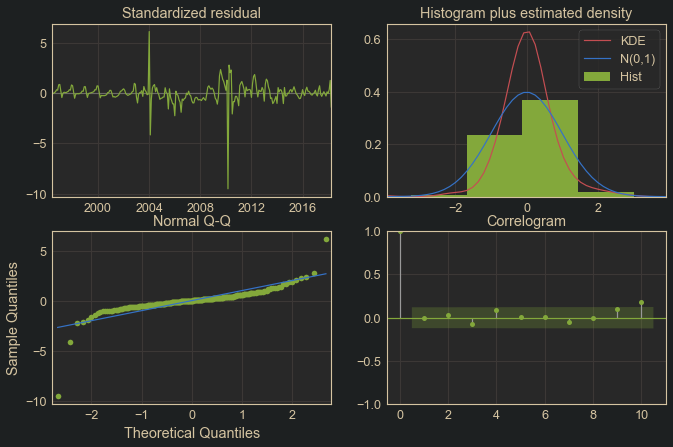

In [283]:
model.plot_diagnostics();

In [297]:
# This model looks pretty good, but there is a slight bump in autocorrelation of the residuals 
# at 10 lags, let's see if adding the yearly seasonality component reduces this, and improves
# the metrics of the model
model = SARIMAX(log_returns,
                order=param,
                seasonal_order=(0,1,1,12),
                enforce_stationary=False,
                enforce_invertibility=False,
                #exog=fs
               ).fit()
print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                            returns   No. Observations:                  264
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                1291.312
Date:                            Fri, 28 Aug 2020   AIC                          -2576.624
Time:                                    16:09:45   BIC                          -2566.048
Sample:                                05-01-1996   HQIC                         -2572.368
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3460      0.034    -10.211      0.000      -0.412      -0.280
ma.S.L12      -0.6669      0.027   

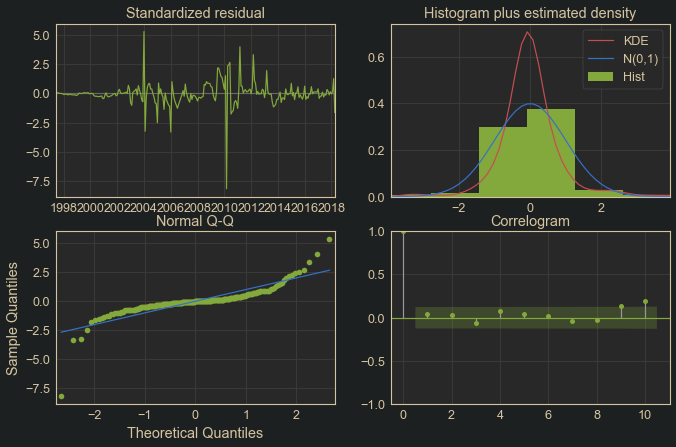

In [298]:
# This has succeeded in improving the Log Likelihood and AIC, as well as made the null
# hypothesis of heteroscedasticity not rejected.
model.plot_diagnostics();

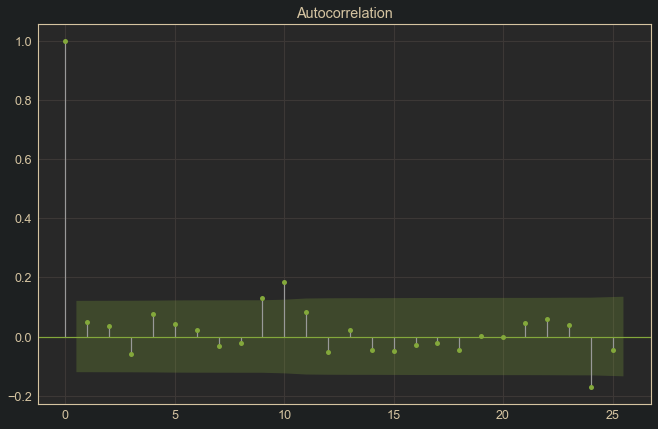

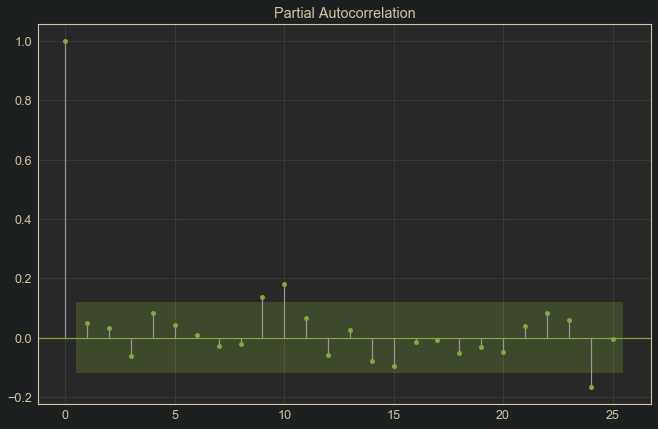

In [305]:
# We can see the bump at 10 lags has not been removed, but the magnitude of the most extreme
# errors has been reduced
# Let's look more closely at the autocorrelation of residuals
plot_acf(model.resid);
plot_pacf(model.resid);

In [329]:
# We can see here that there is a significant spike at 24 lags, or two years. Perhaps our model
# would benefit from a second MA term in the seasonality
model = SARIMAX(log_returns,
                order=param,
                seasonal_order=(0,1,2,12),
                enforce_stationary=False,
                enforce_invertibility=False,
                #exog=fs
               ).fit()
print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                            returns   No. Observations:                  264
Model:             SARIMAX(0, 1, 1)x(0, 1, 2, 12)   Log Likelihood                1301.282
Date:                            Fri, 28 Aug 2020   AIC                          -2594.565
Time:                                    16:23:29   BIC                          -2580.463
Sample:                                05-01-1996   HQIC                         -2588.890
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3460      0.033    -10.358      0.000      -0.412      -0.281
ma.S.L12      -0.7943      0.065   

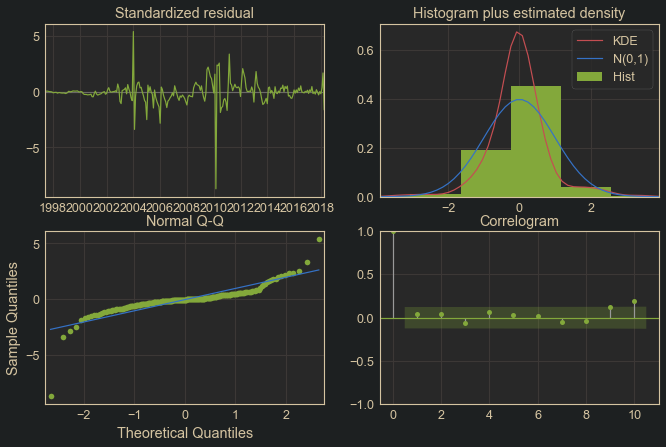

In [330]:
model.plot_diagnostics();

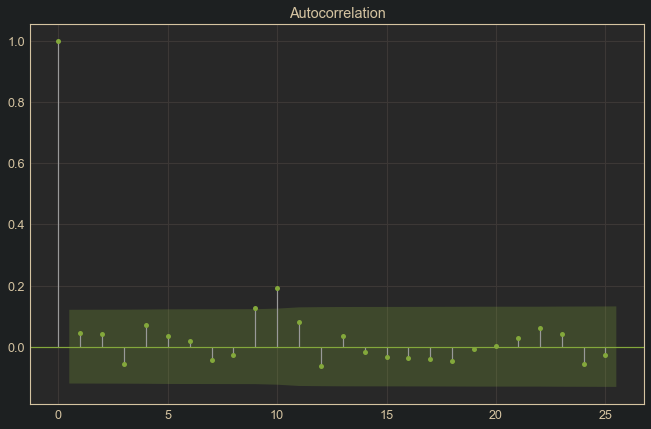

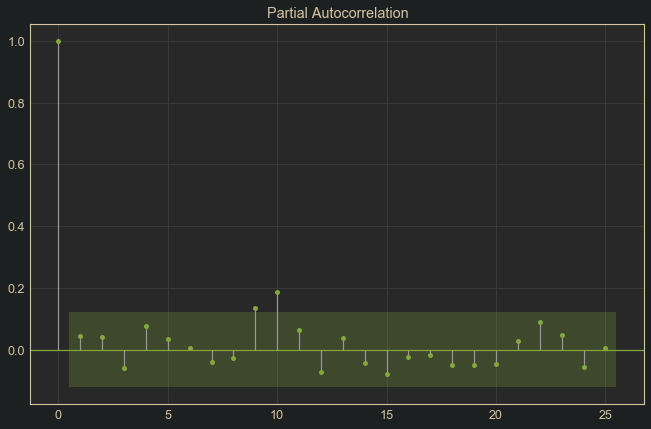

In [331]:
plot_acf(model.resid);
plot_pacf(model.resid);

In [332]:
# Although adding the second MA term to the seasonal component has slightly worsened our AIC
# and Log Likelihood, it has removed the autocorrelation of residuals at 24 lags, and the
# coefficient is statistically significant.

### Filtering Heteroscedasticity:
As Stockhammer & Oller (2007) state in their paper, "the most straightforward way to remove heteroscedasticity in [a time series] is to divide the heteroscedastic series by the conditional volatility estimated from ARCH/GARCH models or from any of their many generalizations."<br>
<br>
Following this advice, I will now fit a ARCH/GARCH model to the residuals from our best model so far, a SARIMA(0,1,1)(0,1,2,12)

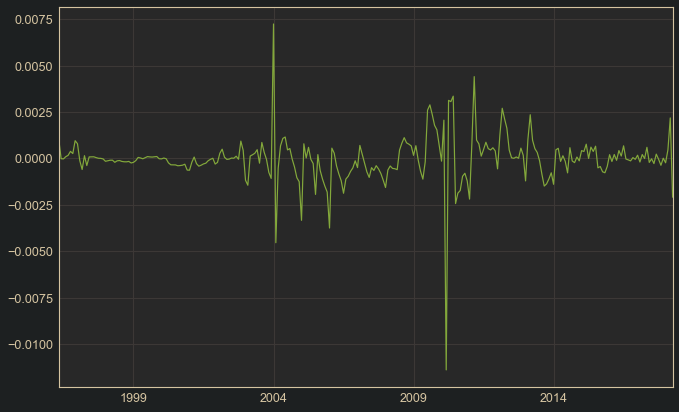

In [333]:
# A look at a plot of the residuals
model.resid.plot()

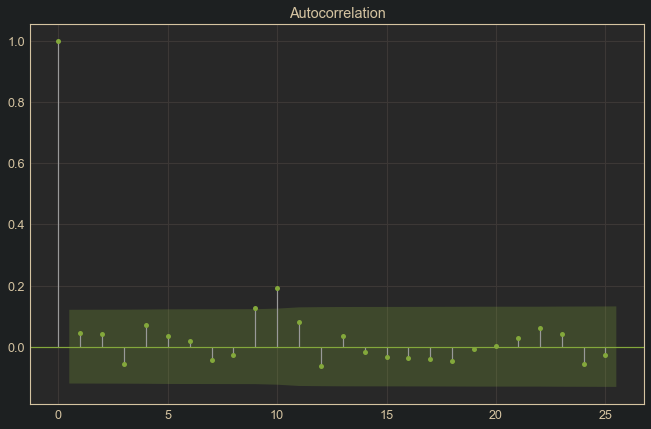

In [334]:
plot_acf(model.resid);

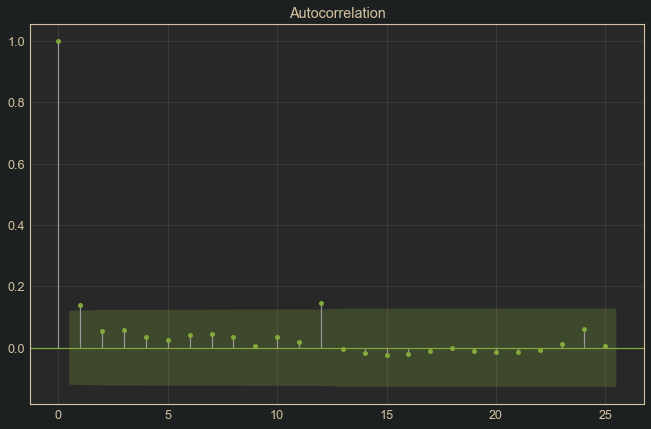

In [335]:
# To test autocorrelation of variance, we need to square these values. Also, when looking at the
# residuals, any autocorrelation is going to occur over a large number of lags, so we need to
# expand the range of lags we are looking at
plot_acf(model.resid**2, 
         #lags=len(model.resid[2:])/2
        );

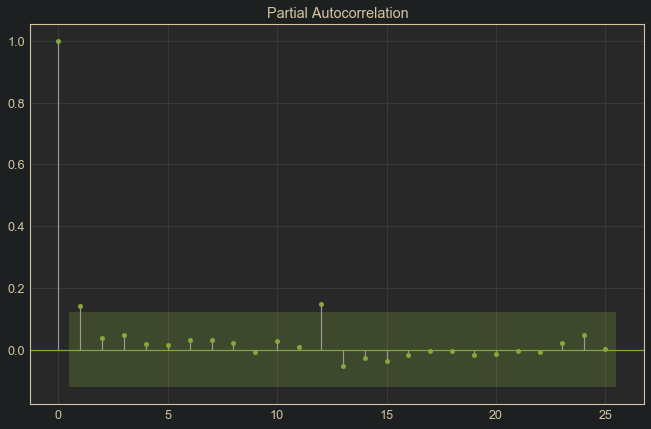

In [336]:
plot_pacf(model.resid**2);

In [187]:
# We can see that there does seem to be some autocorrelation at 1 lag, and also at 12 lags.

In [338]:
from statsmodels.stats.diagnostic import het_arch

In [339]:
# Performing ARCHA-LM test, note that recommended ddof = (p+q) from ARIMA model
results = het_arch(model.resid, 
                   #maxlag=80, 
                   ddof=1
                  )
res_names = ['LM test statistic', 'LM p-value', 'F-statistic', 'F-test p-value']
results = list(zip(res_names, results))
results

[('LM test statistic', 12.418722858284813),
 ('LM p-value', 0.7146879802608574),
 ('F-statistic', 0.7610762342485763),
 ('F-test p-value', 0.7284976340524023)]

The null hypothesis of no autocorrelated heteroscedasticity is not rejected, which isn't quite surprising considering that there are just a couple huge spikes of volatility which don't really establish a time-dependent relationship in the data. This problem is reminiscent of the one I ran into with trying to model the long-term siniusoidal trending of the market. The areas of heightened volatility may be too abrupt and abnormal to model with an ARCH/GARCH approach.

In [340]:
from arch import arch_model

In [341]:
# define model
arch = arch_model(model.resid, 
                  mean='Zero', 
                  vol='GARCH', 
                  #dist='t'
                  rescale=False
                 ).fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1462.6661432742537
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1462.6661419163427
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


In [348]:
print(arch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:                1462.67
Distribution:                  Normal   AIC:                          -2919.33
Method:            Maximum Likelihood   BIC:                          -2908.60
                                        No. Observations:                  264
Date:                Fri, Aug 28 2020   Df Residuals:                      261
Time:                        16:25:19   Df Model:                            3
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.3528e-08  9.257e-10     36.218 3.207e-287 [3.

In [343]:
# While these coefficients are similar to those produced in the R notebook, the
# standard errors are different.

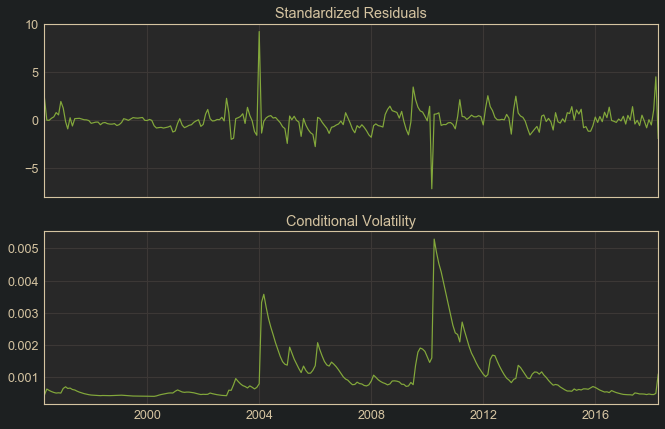

In [344]:
arch.plot();

In [345]:
len(arch.conditional_volatility)

264

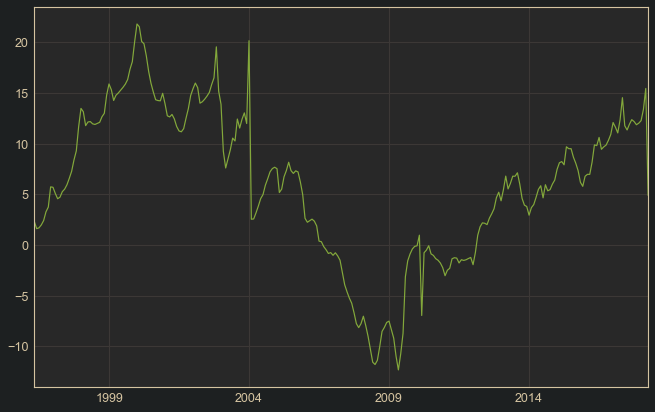

In [351]:
test = log_returns.returns / arch.conditional_volatility
test.plot()

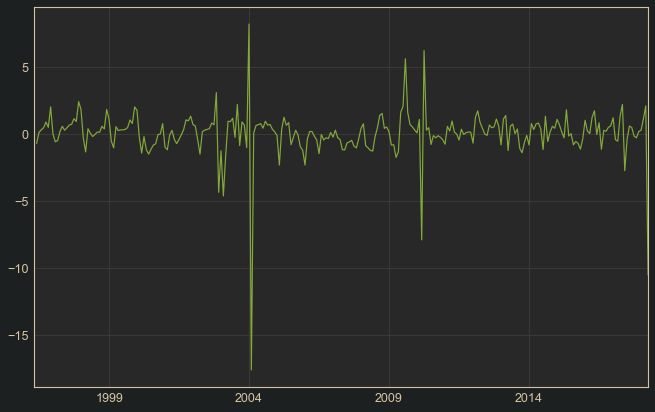

In [352]:
test.diff().plot()

In [ ]:
# it occurs to me that the conditional volatilities are all very low numbers, so when you
# divide another number by them they will make it larger. Perhaps subtracting the

#### Notes so far:
I do not see the advantage of dividing the original series by the output of the GARCH model, I have probably not implemented this properly. It was refreshing to see that the coefficients of the GARCH model here are similar to those generated from the rugarch package in R. All in all, I think that the workflow I have come up with in R is better and outperforms the workflow I've used in this notebook. For one thing, the grid searching in python has proven to be bugging for some reason, and is very slow. In comparison, R has the auto.arima() function, which is very efficient, and generally performs well. Second of all, the rugarch package provides a comprehensive set of functions for fitting the mean and volatility models together, and even uses the ARCH in mean functionality. The graphs generated by the rugarch package are also far more comprehensive.

### Removing the heteroscedasticity by limiting time window

Since the investigation into using fourier terms on this dataset revealed that they will not be useful to model any long-term seasonality of the market, and because the circumstances that led to the 2007 market crash are probably more unique than they are seasonal, I have decided that the best choice moving forward would be to remove data the data before and during the crash, and focus on the price data after all of the drama subsided.<br>
<br>
Let's look again at the plot of the price means to see where a good cutoff point might be:

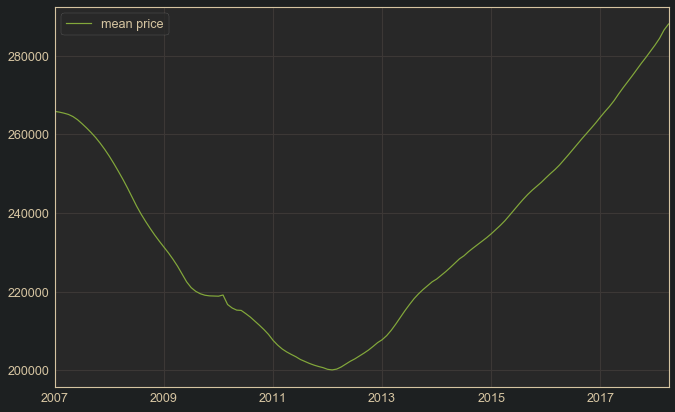

In [177]:
means_fix['2007':].plot(figsize=(11,7))

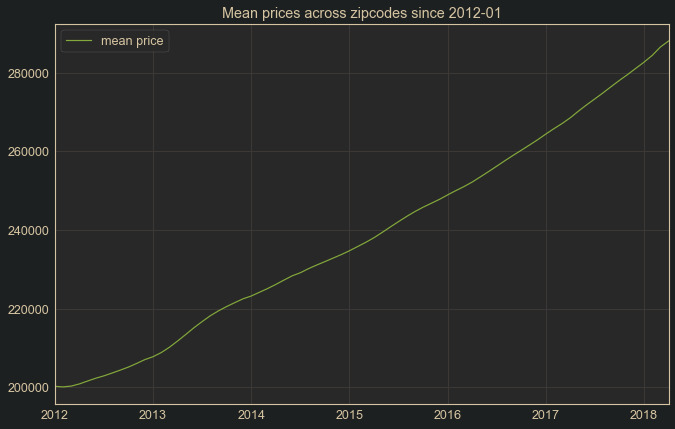

In [178]:
# It looks like the beginning of 2012 would make a good cutoff point, let's see that:
means_fix['2012':].plot(figsize=(11,7))
plt.title("Mean prices across zipcodes since 2012-01");

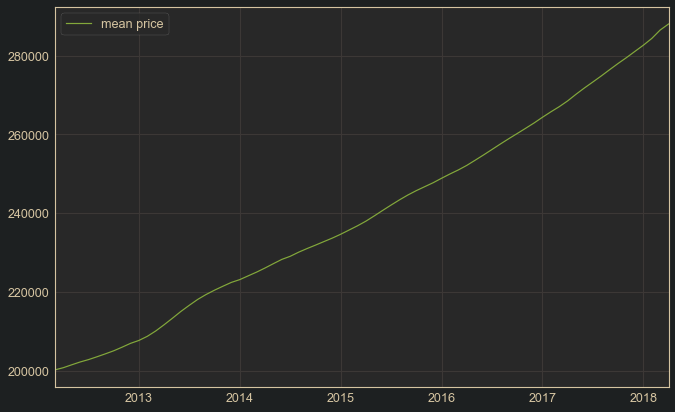

In [179]:
# This still has a bit of a dip in it, I will index a bit further into 2012
means_fix['2012-03':].plot(figsize=(11,7))

In [180]:
# This looks pretty uniform. Let's see how an arima model looks for this data
means_trim = means_fix['2012-03':]
rlist = FloatVector(means_trim['mean price'])
rmodel = r['auto.arima'](rlist)
print(rmodel)

Series: c(200272.349817229, 200824.656872888, 201558.155734878, 202274.412028416,  202879.534339051, 203592.28490735, 204337.92105807, 205118.247571812,  206036.550251429, 207004.656609492, 207745.450178424, 208791.545429591,  210145.42272852, 211730.785067252, 213399.382377162, 215113.127916552,  216674.798138771, 218163.500752703, 219413.008074449, 220509.586697687,  221509.880936089, 222473.737511975, 223183.207199836, 224135.937819595,  225082.573123338, 226124.783527647, 227232.010636122, 228310.622485853,  229099.280038036, 230141.74420974, 231060.035318889, 231927.514772804,  232822.135434354, 233712.307274333, 234691.190654079, 235760.279834273,  236836.426000136, 238009.760239082, 239354.207702235, 240744.121442641,  242103.525096787, 243424.444746315, 244658.269374448, 245764.565645589,  246765.041092169, 247765.170141955, 248896.366229709, 249987.312368403,  251014.310942063, 252164.273585546, 253483.637845548, 254820.084221966,  256205.780071996, 257597.914827141, 258946.02

In [181]:
# Extracting the model parameters:
string = str(rmodel).split('ARIMA')[1].split(' ')[0]
param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
print(param)

# Making an equivalent model in StatsModels
model = SARIMAX(means_trim,
                order=param,
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

(0, 2, 0)
                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                   74
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -464.546
Date:                Mon, 03 Aug 2020   AIC                            931.093
Time:                        12:11:00   BIC                            933.370
Sample:                    03-01-2012   HQIC                           931.999
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.352e+04   2521.377      9.329      0.000    1.86e+04    2.85e+04
Ljung-Box (Q):                       23.51   Jarque-Bera (JB):                33.05
Prob(Q):                             

In [182]:
# The null hypothesis of the Ljung-Box test that the errors are not autocorrelated is not 
# rejected.
# The null hypothesis of the Heteroskedasticity test that the variance is not changing
# throughout the sample is not rejected.
# The null hypothesis of normal skew and kurtosis of the residuals is rejected, but a 
# visual inspection of the histogram of residuals indicates they are normal enough, the issue
# is the kurtosis being too high, meaning long tails

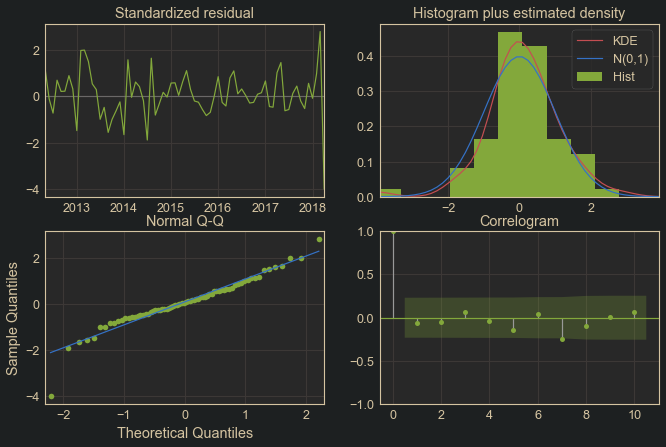

In [183]:
# Checking diagnostics of new model:
model.plot_diagnostics(figsize=(11,7));

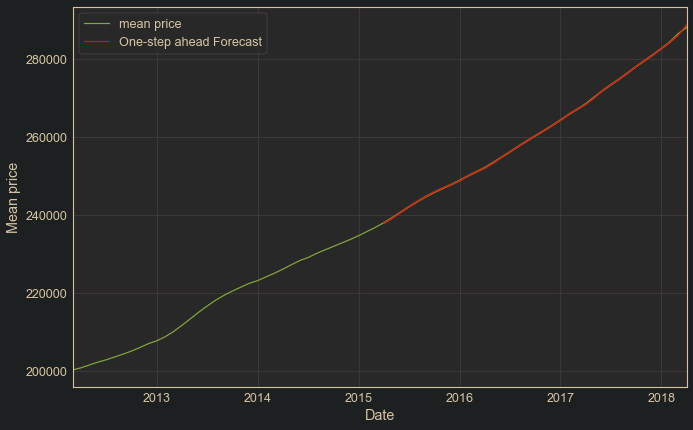

In [364]:
# Get predictions
pred = model.get_prediction('2015-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means_trim.plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [365]:
# We can see the one-step-ahead predictions of this model are pretty spot on, which isn't 
# surprising considering the smooth linear data. Let's look at the MSE
forecasted = pred.predicted_mean
truth = means_trim['2015-04':'2018-04']['mean price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 23522.72


In [ ]:
# This error is pretty good, considering the scale we are considering is in the hundreds of
# thousands

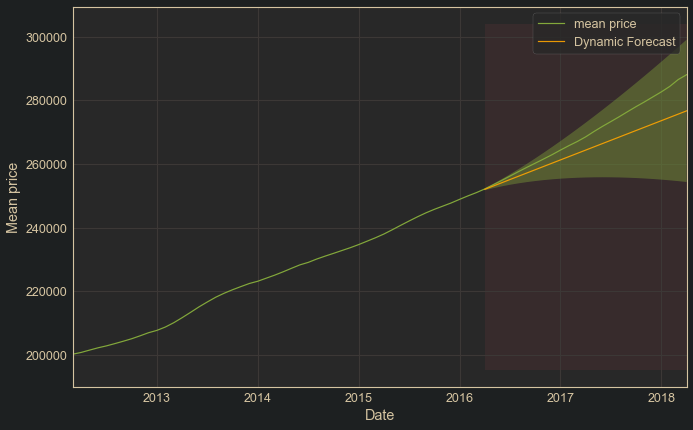

In [366]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2016-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_trim.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.4
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2016-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [ ]:
# The predictions here are a bit conservative, but the slope does increase a bit during the
# period which was isolated from the training data.

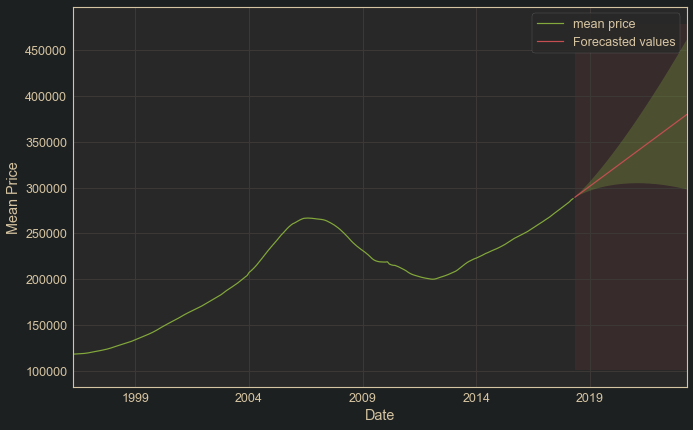

In [368]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [ ]:
# These results are fairly reminiscent of the facebook prophet projections, although the low end
# is a bit more optimistic, probably because the training data only considered an upward trend

In [369]:
# I am wondering how this model, which had no AR or MA terms, compares to one which has at least
# one MA term
# Let's try another basic model, this time with pdq of (0, 2, 1)
model = SARIMAX(means_trim,
                order=(0,2,1),
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:             mean price   No. Observations:                   74
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -463.789
Date:                Sun, 02 Aug 2020   AIC                            931.578
Time:                        17:16:59   BIC                            936.131
Sample:                    03-01-2012   HQIC                           933.391
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0406      0.085     -0.476      0.634      -0.208       0.126
sigma2      2.404e+04   3203.115      7.505      0.000    1.78e+04    3.03e+04
Ljung-Box (Q):                       23.93   Jarque-

In [ ]:
# We can see that the performance is nearly identical, with only a little improvement on the 
# log likelihood and JB scores.
# It can be seen that the p-value for the MA term is far from significant, reinforcing the fact
# that the last model was ideal. This also reinforces the selection of the auto.arima() function

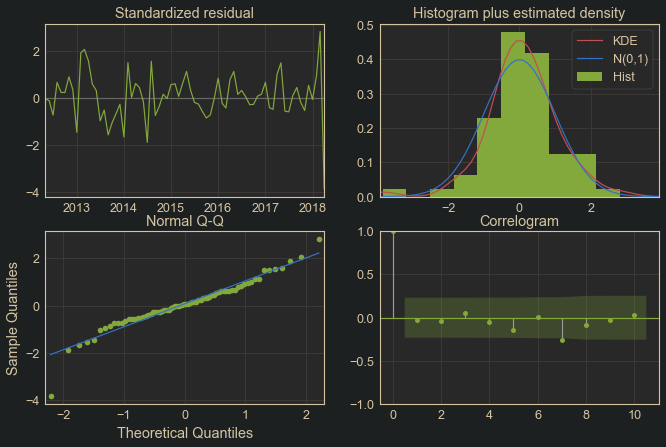

In [370]:
# Checking diagnostics of new model:
model.plot_diagnostics(figsize=(11,7));

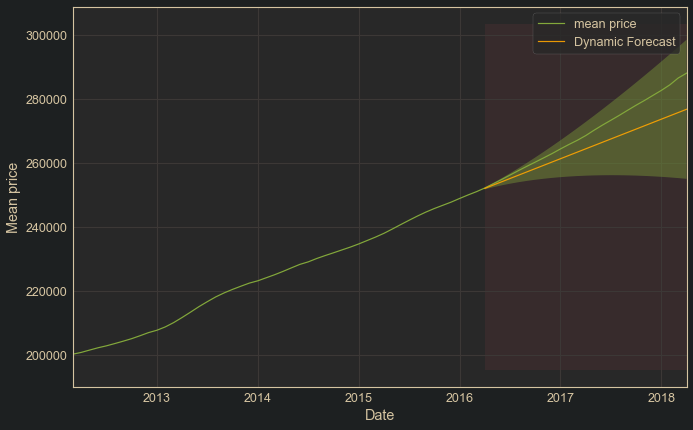

In [371]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2016-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_trim.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.4
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2016-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

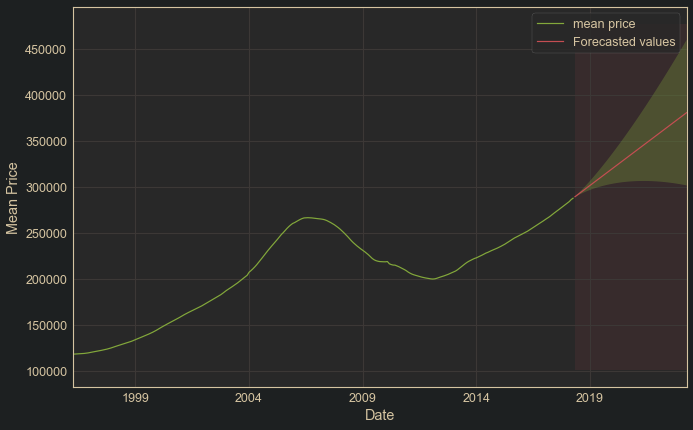

In [372]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()